In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# **Introduction**
Internet đã mở ra một kỷ nguyên mới, cho phép chúng ta có cơ hội được tiếp cận với nhiều nguồn thông tin một cách thuận tiện, nhanh chóng; từ việc đọc báo, giải trí cho đến tìm tòi, chia sẻ kiến thức, quan điểm của bản thân với mọi người. Tất cả đều trở nên dễ dàng và nhannh chóng nhờ có sự can thiệp của Internet.

Trong số đó, việc tìm kiếm câu trả lời cho những thắc mắc của bản thân là một trong những việc được thực hiện nhiều nhất trên Internet. Rất nhiều trang web đã được lập ra để phục vụ cho mục đích đó, Quora là một trang web như vậy. Với Quora, người dùng có thể truy cập và đặt ra những câu hỏi thuộc nhiều lĩnh vực khác nhau và không lâu sau, câu hỏi đó sẽ được những người dùng khác trả lời một cách thấu đáo, chi tiết nhất có thể (đôi khi có thể hơi quá chi tiết). Điều này khiến cho Quora trở thành một trong những nền tảng cung cấp thông tin tri thức nổi tiếng và được sử dụng nhiều nhất trên toàn cầu.

Tuy vậy, bên cạnh những câu hỏi bình thường, mang tính tò mò, tìm tòi đơn thuần, một bộ phận người dùng lại lợi dụng tính công khai, tự do ngôn luận của nền tảng này để đặt ra những câu hỏi gây tranh cãi, vô văn hóa,... nhằm kích động, gây chia rẽ giữa người với người - vốn không nên xuất hiện trên những nền tảng công cộng, với lượng người dùng khổng lồ như Quora.

Nhận thức được điều này, một trong những giải pháp được đặt ra đó là xây dựng một mô hình giúp phân lọai ra những câu hỏi tri thức đơn thuần (ta gọi là **sincere** question) với những câu hỏi gây tranh cãi nêu trên (**insincere** question). Và mục tiêu đó sẽ được giải quyết thông qua mô hình được huấn luyện ngay sau đây.

***Mô tả bài toán***

**Input**: Dữ liệu dạng text về câu hỏi

**Output**: Phân loại câu hỏi **sincere** hoặc **insincere** và được Kaggle đánh giá theo công thức:

F1 =2.(Precision.Recall)/(Precision+Recall)

Trong đó:

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

Ta có hình vẽ biểu diễn hai đại lượng trên như sau:

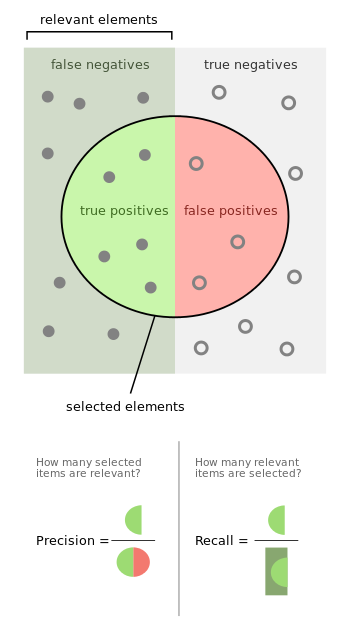!
# **Data**

Tập dữ liệu train bao gồm 1.3 triệu dòng và 3 cột, nhưng theo quan sát thì ta chỉ quan tâm đến 2 features: **question_text** và **target** trong đó:

* **question_text** : Các câu hỏi trên Quora.
* **target** : một câu hỏi có nhãn "**insincere**" mang giá trị là 1 , "**sincere**" là 0.
Thông qua hai features này, ta sẽ phân tích được những đặc điểm của các câu hỏi **sincere** và **insincere**, phục vụ cho mục đích huấn luyện mô hình về sau.

In [ ]:
df_train = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
print("Shape of train data: ", df_train.shape)
df_train.head()

Tập dữ liệu test hơn 300 nghìn dòng và chỉ còn lại **quesion_text** để dự đoán **target** đầu ra bài toán.

In [ ]:
df_test = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
print("Shape of test data: ", df_test.shape)
df_test.head()

# **Data analysis**

In [ ]:
df_train.info()

Ta thấy tập dữ liệu train có 3 trường: **qid**, **question_text** và **target** với tổng số lượng bản ghi lên tới 1,306,122 bản ghi.

In [ ]:
df_train['target'].value_counts()

Trong số đó, tồn tại:

* 1,225,312 câu hỏi mang giá trị target là 0, tương ứng với các câu hỏi **sincere**.
* 80,810 câu hỏi mang giá trị target là 1, tương ứng với các câu hỏi **insincere**.

Ta kiểm tra tính trùng lặp trong bộ dữ liệu

In [ ]:
df_train.duplicated().sum()

Có thể thấy sau khi chạy dòng lệnh, ta thu được kết quả là 0. Từ đó có thể kết luận rằng trong tập dữ liệu train không tồn tại sự trùng lặp.

In [ ]:
df_test.duplicated().sum()

Tương tự như tập train, có thể thấy tập dữ liệu test cũng không tồn tại sự trùng lặp dữ liệu.

Với số lượng câu hỏi **sincere** và **insincere** thu được bên trên, ta bắt đầu xem xét tới tính cân bằng của tập dữ liệu.

**Tính cân bằng của tập dữ liệu**

Mất cân bằng dữ liệu là một trong những hiện tượng phổ biến của bài toán phân loại nhị phân (binary classification). Trước khi đi sâu vào phân tích hiện tượng này, ta cần kiểm tra tính cân bằng của tập dữ liệu.

In [ ]:
print("Total questions: ", df_train.shape[0])
print("Sincere questions: {}%".format(round(df_train[df_train["target"] == 0].shape[0]/df_train.shape[0]*100, 2)))
print("Insincere questions: {}%".format(round(df_train[df_train["target"] == 1].shape[0]/df_train.shape[0]*100, 2)))

plt.figure(figsize=(7,5))
ax = sns.countplot(x='target', data=df_train)
total = df_train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, '{0:.0%}'.format(height/total), ha="center")
plt.title('Reparition of question by suncerity (insincere =  1)')
plt.show()

Với tổng tập train là 1 triệu 3 điểm dữ liệu, câu hỏi **sincere** chiếm tới gần 94%, theo đó tỷ lệ dữ liệu giữa 2 classes vào khoảng 15:1.
​
Đây là hiện tượng mất cân bằng nghiêm trọng dẫn tới kết quả dự báo kém chính xác trên nhóm thiểu số.

**Xử lý mất cân bằng dữ liệu**

Khi một bên chiếm đa số và bên còn lại thiểu số, hiển nhiên sẽ có 2 cách để làm cân bằng chúng:

* Tăng số lượng bên thiểu số (Over sampling): thu thập thêm dữ liệu hoặc chấp nhận mẫu có trùng lặp.
* Giảm số lượng bên đa số (Under sampling): cân bằng mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện nhưng kích thước mẫu sẽ giảm đáng kể.

Mỗi phương pháp đều mang những ưu nhược điểm riêng, trong bài này ta sẽ tập trung vào phương pháp **Under sampling**

**Vấn đề:** Tỷ lệ 50:50 trên 2 classes là trạng thái cân bằng, nhưng để đạt được tỷ lệ đó thì ta sẽ mất rất nhiều mẫu dữ liệu

**Giải pháp:** Ta sẽ giảm bớt sự mất cân bằng (1:4) sao cho không ảnh hưởng đáng kể tới khả năng dự báo của mô hình.

In [ ]:
from sklearn.utils import resample

sincere = df_train[df_train.target == 0]
insincere = df_train[df_train.target == 1]
df_train_sampled = pd.concat([resample(sincere, replace = True, n_samples = len(insincere)*4), insincere])
df_train_sampled

In [ ]:
y = df_train_sampled['target']
y.value_counts().plot(kind='bar', rot=0)

Có thể thấy việc giảm bớt cân bằng dữ liệu đã cho ta một tập dữ liệu có phần cân bằng hơn.

Sau khi đã giảm bớt sự mất cân bằng dữ liệu, ta tiến hành phân tích dữ liệu một cách chi tiết hơn để có cái nhìn tốt về bộ dữ liệu.

Trước hết, ta có thể có cái nhìn sơ lược về những từ thường xuất hiện trong các câu hỏi **sincere** và **insincere** thông qua các biểu đồ Word Cloud như sau:

In [ ]:
# import wordcloud
from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)

In [ ]:
print("Word cloud thể  hiện các câu hỏi sincere: \n")
sincere_wordcloud = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(str(df_train[df_train["target"] == 0]["question_text"]))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
print("Word cloud thể  hiện các câu hỏi insincere: ")
insincere_wordcloud = WordCloud(width=800, height=600, background_color='white', min_font_size=10).generate(str(df_train[df_train["target"] == 1]["question_text"]))
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Thông qua hai biểu đồ Word Cloud trên, ta nhìn nhận được một số đặc điểm sau:

* Đối với câu hỏi **sincere**, những từ xuất hiện nhiều có thể liên quan đến nhiều vấn đề khác nhau, trong đó nổi bật là về kiến thức văn hóa, khoa học, kỹ thuật như: space, geometry, computer,...
* Còn đối với câu hỏi **insincere**, những từ xuất hiện với tần suất lớn bao gồm những từ liên quan đến sắc tộc, chính trị, chửi thề: gay, Trump, dictactorship,...

# **Preprocessing**
Để mô hình đạt được tính chính xác cao, ta cần phải thực hiện công đoạn tiền xử lý dữ liệu trước khi đi đến giai đoạn xây dựng mô hình.

Bước đầu tiên là ta phải loại bỏ những tác nhân gây nhiễu hoặc không cần thiết, có thể gây ảnh hưởng đến kết quả training model.

Một số cách để loại bỏ những tác nhân gây nhiễu và thừa thãi đó - ta gọi là làm sạch dữ liệu - bao gồm:

* Loại bỏ các tag HTML
* Loại bỏ các dấu nháy đơn, nháy kép
* Loại bỏ các số thực, số phức
* Loại bỏ các kí tự La Mã
* Thay thế các dấu, các kí tự đặc biệt với khoảng trắng
* Đưa tất cả các chữ cái viết hoa, viết thường về dạng chung là viết thường

In [ ]:
import re, string

def clean_text(text):

  # Remove HTML Tags
  text = re.sub(re.compile('<.*?>'), '', text)

  # Remove [\], ['], ["]
  text = re.sub(r'\\', '', text)
  text = re.sub(r'\"', '', text)
  text = re.sub(r'\'', '', text)

  # Remove number
  text = re.sub('[0-9]{5,}','#####', text);
  text = re.sub('[0-9]{4,}','####', text);
  text = re.sub('[0-9]{3,}','###', text);
  text = re.sub('[0-9]{2,}','##', text);

  ## Remove Roman words
  roman = re.compile(r'^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$');
  text = roman.sub(r'', text);

  # Convert all text to lowercase
  text = text.strip().lower()

  # Replace punctuation chars with spaces
  filters = '!"\'#$%@&*()+_-;:<=>.?{}|`\\^\t\n'
  translate_dict = dict((c, " ") for c in filters)
  translate_map = str.maketrans(translate_dict)
  text = text.translate(translate_map)

  return text

Đầu vào của bài toán là dữ liệu dạng text (ở đây là các question_text), không thuộc kiểu dữ liệu mà các thuật toán Machine Learning có thể hiểu và làm việc được, do đó mà ta cần chuyển đổi tập dữ liệu này về dạng số.

Một thuật ngữ ám chỉ việc chuyển dữ liệu về dạng text về dạng số đó được gọi là Vectorizer. Và hiện này có hai cách thực hiện kỹ thuật này là:

* Tính toán số lần xuất hiện của từ trong văn bản
* Tính toán tần suất xuất hiện của từ trong văn bản

**TF-IDF**

**Vấn đề:** Đối với những câu hỏi được đặt ra trên Quora, thông qua việc phân tích dữ liệu, ta nhận thấy ở cả hai loại câu hỏi **sincere** và **insincere** đều xuất hiện một số từ ngữ nổi bật, được lặp lại khá nhiều, mà tầm quan trọng có thể không cao, ví dụ như: "is", "that",... Việc xuất hiện với tần suất lớn của những từ ngữ đó có thể làm lu mờ đi ý nghĩa của những từ quan trọng; điều này có thể gây ảnh hưởng ít nhiều tới việc training model sau này.

**Giải pháp:** để khắc phục vấn đề nêu trên, ta có thể sử dụng TF-IDF, một kỹ thuật cơ bản trong xử lý ngôn ngữ tự nhiên, có tác dụng biểu diễn dữ liệu thông qua mức độ quan trọng của một từ trong văn bản.

TF-IDF bao gồm hai thành phần chính cần quan tâm:

**TF**(Term Frequency): tần suất xuất hiện của từ trong văn bản, được tính theo công thức:

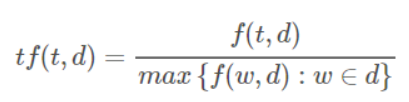

**IDF** (Inverse Document Frequency): nghịch đảo tần suất của văn bản, giúp đánh giá tầm quan trọng của từ, được tính theo công thức:

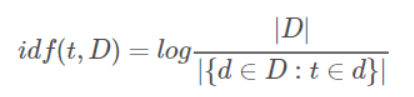

Từ hai thành phần này, ta rút ra được biểu diễn công thức tính độ quan trọng của một từ trong văn bản như sau:

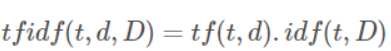

Trong đó:

* t: từ xuất hiện trong văn bản
* d: văn bản được khảo sát
* D: tập hợp các văn bản

Ta chuyển đổi dữ liệu từ text sang thể hiện vector thông qua TfidfVectorizer.

Và thay vì sử dụng các từ riêng lẻ unigram ("do", "not",...), bigram ("do not",...) thì ta sẽ sử dụng các từ trigram ("do not do",...)

Đồng thời, loại bỏ các từ thừa thãi, không mang nhiều ý nghĩa trong việc training model như "a", "an", "the",... (hay còn gọi là các stopword)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 3))
X = vectorizer.fit_transform(df_train_sampled['question_text'])
x = vectorizer.transform(df_test['question_text'])

Sau khi đã tiến hành chuyển đổi tập dữ liệu text thành các vector, các biểu diễn dạng số, ta thực hiện phân chia bộ dữ liệu thành tập train (dùng để huấn luyện mô hình) và tập test (dùng để kiểm tra mô hình được huấn luyện) theo tỉ lệ 80%, 20%

In [ ]:
# Chia dataset thành các tập train và test theo tỉ lệ 80%, 20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df_train_sampled['target'], test_size=0.2, random_state=42)

Sau khi thực hiện việc split tập dataset, ta bắt đầu tiến hành việc xây dựng và huấn luyện mô hình

# **Evaluate**
Để đảm bảo được rằng mô hình vừa được xây dựng là đủ tốt, ta cần phải có một phương thức để có thể đưa ra những đánh giá tổng quan về mô hình, cũng như để so sánh với một số mô hình khác được xây dựng để giải quyết cùng một vấn đề, nhưng sử dụng cách tiếp cận và thuật toán Machine Learning khác.

Do ta đang làm việc trên dataset thiếu cân bằng, do đó việc sử dụng đại lượng Accuracy sẽ là không hợp lý. F1-Score sẽ là đại lượng được sử dụng để đánh giá mô hình do nó quan tâm đến phân bố của tập dữ liệu.

Để tính F1-score, ta quan tâm tới hai đại lượng khác là **Precision** và **Recall**

Hai giá trị này lần lượt được biểu diễn như sau:

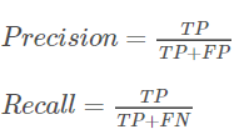

Ta có hình vẽ biểu diễn hai đại lượng trên như sau:

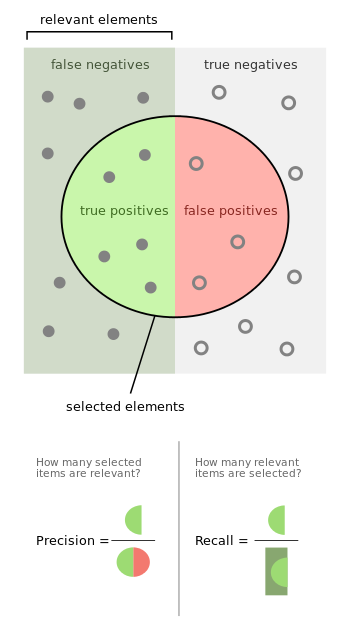

F1-Score là harmonic mean của hai đại lượng nêu trên, được biểu diễn như sau:

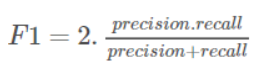

Cách tính F1-score được xây dựng như sau, sử dụng sklearn

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
# Tính f1-score
def get_f1(model, name):
  y_train_pred, y_pred = model.predict(X_train), model.predict(X_test)
  print(classification_report(y_test, y_pred), '\n')

  print('{} model with F1 score = {}'.format(name, f1_score(y_test, y_pred)))

# **Build Model**
Trong thư viện sklearn có hỗ trợ rất nhiều những mô hình khác nhau

Ở đây, ta thử nghiệm với mô hình: **XGBoost** 

**XGBoost** - viết tắt của **Extreme Gradient Booosting** - sử dụng kết hợp các model như Decision Tree nhằm tạo ra một model mạnh hơn, hiệu quả hơn.

Nó mang một số ưu điểm vượt trội như:

Tốc độ huấn luyện nhanh
Có thể tăng tốc bằng cách sử dụng GPU
Có cơ chế xử lý overfit
...

Nhờ những ưu điểm đó mà XGBoost luôn được lựa chọn để huấn luyện model, giành các vị trí cao trên bảng ranking của Kaggle

Và với những ưu điểm này, liệu việc sử dụng XGBoost có đưa ra được cho ta một mô hình tốt, vượt trội?

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
get_f1(xgb, 'XGBClassifier')

**Conclusion**

Qua đây, ta tạm kết luận, XGBoost không thực sự mạnh trong bài toán phân loại câu hỏi **sincere** và **insincere** nói riêng và các bài toán xử lý ngôn ngữ tự nhiên khác nói chung.

Vậy làm sao để khắc phục được vấn đề nêu trên, đồng thời đưa ra một mô hình đủ tốt cho việc phân loại. Một giải pháp tốt có lẽ là sử dụng Neural Network

# **Neural Network**
fastai là một thư viện deep learning giúp người mới tiếp cận với học máy có những cái nhìn bao quát, được thực hành với high-level components.

Vậy nên trong phần này, xin phép không đi sâu vào phân tích những đặc trưng của LSTM với kiến trúc Recurrent Neural Network (RNN) mà chỉ dừng lại ở việc biết cách dùng nó như một công cụ tiện lợi.

Để khắc phục kiến trúc RNN dễ bị overfit, một kỹ thuật regularization được dùng chính là **DropConnection**.

Không như Dropout loại bỏ hoàn toàn một node bất kỳ, DropConnection chỉ chọn ngẫu nhiên một tập trọng số trong mạng và cho bằng 0.

In [ ]:
from fastai import *
from fastai.text.all import *
from fastai.data import *

sample_submission = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/sample_submission.csv")

## TRAINING

# path = "/kaggle/input/quora-insincere-questions-classification"
# dls = TextDataLoaders.from_csv(path=path, csv_fname='train.csv', text_col='question_text', label_col='target', device='cuda')
# dls.show_batch(max_n=3)
# learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5)
# learn.fine_tune(4, 1e-2)

## INFERENCE

# for i in range (test.shape[0]):
#     sample_submission.at[i, 'prediction'] = int(learn.predict(test['question_text'][i])[0])
# # sample_submission

## Xuất ra index những dự đoán có giá trị là TOXIC

# a = sample_submission[:]['prediction'].values.tolist()
# with open('list.txt', 'w') as f:
#     for i, item in enumerate(a):
#         if(item==1):
#             f.write("%d, " % i)

Thư viện fastai chưa hỗ trợ inference khiến thời gian predict lên tới 16 tiếng, vì thế phải xuất kết quả ra file rồi đưa vào một cách thủ công

In [ ]:
index = (0, 16, 17, 21, 27, 42, 58, 78, 93, 99, 105, 107, 111, 120, 153, 184, 201, 211, 223, 270, 272, 273, 281, 282, 286, 289, 294, 319, 326, 327, 358, 375, 433, 434, 467, 478, 496, 517, 524, 525, 541, 544, 552, 570, 582, 599, 605, 607, 636, 639, 652, 653, 665, 668, 671, 673, 732, 735, 743, 754, 756, 786, 790, 812, 841, 891, 902, 915, 917, 923, 927, 938, 940, 968, 995, 1011, 1012, 1013, 1016, 1028, 1031, 1073, 1081, 1112, 1122, 1123, 1132, 1139, 1158, 1159, 1201, 1207, 1236, 1239, 1245, 1246, 1258, 1261, 1273, 1287, 1299, 1304, 1315, 1328, 1331, 1345, 1356, 1361, 1375, 1381, 1383, 1427, 1430, 1441, 1453, 1455, 1461, 1474, 1486, 1489, 1514, 1529, 1534, 1539, 1540, 1561, 1562, 1583, 1587, 1598, 1609, 1651, 1659, 1695, 1716, 1759, 1761, 1780, 1786, 1792, 1794, 1801, 1805, 1809, 1811, 1815, 1826, 1852, 1878, 1879, 1882, 1896, 1901, 1903, 1904, 1920, 1978, 1979, 1997, 2022, 2025, 2030, 2058, 2062, 2066, 2082, 2098, 2126, 2129, 2148, 2153, 2158, 2171, 2180, 2187, 2204, 2207, 2208, 2213, 2227, 2238, 2240, 2247, 2267, 2272, 2273, 2282, 2292, 2302, 2305, 2313, 2323, 2347, 2353, 2364, 2391, 2421, 2432, 2437, 2443, 2449, 2452, 2456, 2461, 2462, 2469, 2485, 2487, 2503, 2527, 2542, 2546, 2552, 2561, 2568, 2578, 2611, 2646, 2654, 2655, 2666, 2688, 2689, 2700, 2744, 2754, 2783, 2784, 2803, 2806, 2807, 2809, 2837, 2847, 2851, 2855, 2862, 2866, 2879, 2881, 2882, 2886, 2898, 2914, 2922, 2952, 2959, 2980, 3022, 3025, 3028, 3038, 3048, 3057, 3060, 3068, 3069, 3077, 3082, 3086, 3104, 3115, 3149, 3180, 3181, 3184, 3201, 3216, 3218, 3239, 3241, 3255, 3260, 3272, 3273, 3286, 3319, 3359, 3400, 3404, 3405, 3409, 3431, 3453, 3463, 3474, 3486, 3490, 3505, 3506, 3514, 3526, 3529, 3533, 3535, 3537, 3585, 3613, 3614, 3633, 3634, 3661, 3681, 3684, 3695, 3718, 3728, 3750, 3814, 3836, 3839, 3845, 3877, 3879, 3880, 3892, 3895, 3926, 3928, 3938, 3958, 3967, 3972, 3993, 4005, 4011, 4031, 4042, 4049, 4058, 4066, 4076, 4080, 4119, 4151, 4152, 4154, 4171, 4203, 4205, 4206, 4226, 4234, 4237, 4241, 4248, 4258, 4286, 4292, 4306, 4310, 4320, 4323, 4345, 4381, 4396, 4403, 4408, 4420, 4427, 4434, 4440, 4442, 4447, 4449, 4453, 4462, 4465, 4472, 4518, 4562, 4568, 4597, 4620, 4635, 4643, 4647, 4667, 4672, 4699, 4717, 4719, 4748, 4756, 4761, 4782, 4799, 4811, 4837, 4850, 4858, 4873, 4886, 4898, 4921, 4958, 4964, 4966, 4973, 5016, 5059, 5076, 5126, 5143, 5146, 5168, 5234, 5243, 5251, 5253, 5262, 5266, 5272, 5273, 5292, 5317, 5326, 5339, 5342, 5345, 5361, 5436, 5439, 5441, 5446, 5496, 5497, 5504, 5512, 5543, 5554, 5585, 5588, 5598, 5613, 5622, 5645, 5668, 5671, 5672, 5673, 5679, 5682, 5688, 5691, 5696, 5698, 5736, 5740, 5757, 5772, 5773, 5779, 5797, 5801, 5806, 5807, 5862, 5863, 5868, 5880, 5884, 5898, 5903, 5928, 5930, 5932, 5993, 6018, 6021, 6027, 6040, 6052, 6073, 6137, 6148, 6163, 6167, 6191, 6199, 6204, 6212, 6218, 6245, 6261, 6280, 6307, 6319, 6383, 6405, 6416, 6417, 6423, 6430, 6433, 6440, 6448, 6461, 6465, 6479, 6489, 6517, 6534, 6552, 6554, 6566, 6568, 6584, 6604, 6653, 6670, 6678, 6690, 6694, 6700, 6712, 6758, 6759, 6765, 6766, 6799, 6817, 6833, 6835, 6843, 6876, 6957, 6966, 7001, 7076, 7106, 7110, 7136, 7147, 7155, 7176, 7204, 7226, 7245, 7254, 7258, 7298, 7326, 7361, 7372, 7386, 7396, 7403, 7407, 7424, 7437, 7482, 7484, 7497, 7498, 7501, 7504, 7514, 7515, 7521, 7535, 7554, 7555, 7641, 7679, 7687, 7690, 7695, 7708, 7712, 7723, 7730, 7733, 7772, 7777, 7782, 7797, 7832, 7839, 7840, 7859, 7864, 7868, 7871, 7872, 7874, 7883, 7888, 7893, 7935, 7936, 7937, 7956, 7972, 7978, 7998, 8031, 8036, 8043, 8048, 8051, 8069, 8078, 8090, 8099, 8103, 8108, 8117, 8135, 8152, 8165, 8178, 8199, 8202, 8210, 8212, 8216, 8222, 8244, 8246, 8256, 8269, 8284, 8287, 8293, 8343, 8356, 8384, 8395, 8396, 8416, 8422, 8426, 8446, 8465, 8511, 8512, 8518, 8536, 8550, 8560, 8568, 8624, 8627, 8647, 8649, 8656, 8684, 8685, 8701, 8717, 8725, 8772, 8783, 8793, 8794, 8799, 8803, 8823, 8831, 8851, 8860, 8881, 8886, 8899, 8903, 8913, 8920, 8928, 8932, 8944, 8946, 8951, 8970, 8979, 9011, 9018, 9032, 9034, 9039, 9041, 9083, 9090, 9091, 9111, 9113, 9115, 9123, 9134, 9136, 9162, 9181, 9182, 9188, 9201, 9203, 9212, 9220, 9230, 9235, 9247, 9252, 9254, 9264, 9269, 9271, 9274, 9288, 9294, 9307, 9309, 9315, 9319, 9330, 9337, 9338, 9352, 9356, 9363, 9366, 9397, 9417, 9425, 9433, 9440, 9455, 9511, 9524, 9535, 9556, 9565, 9606, 9607, 9615, 9634, 9683, 9696, 9735, 9742, 9744, 9760, 9765, 9768, 9804, 9851, 9912, 9913, 9964, 9977, 9984, 9988, 10001, 10023, 10046, 10050, 10052, 10063, 10074, 10078, 10093, 10112, 10113, 10127, 10146, 10173, 10190, 10203, 10214, 10219, 10221, 10226, 10249, 10263, 10300, 10307, 10324, 10355, 10387, 10399, 10410, 10414, 10419, 10437, 10451, 10498, 10503, 10504, 10514, 10515, 10533, 10543, 10564, 10572, 10581, 10624, 10639, 10660, 10664, 10681, 10705, 10723, 10727, 10739, 10740, 10754, 10794, 10807, 10812, 10860, 10861, 10864, 10871, 10873, 10908, 10911, 10912, 10930, 10931, 10933, 10936, 10941, 10945, 10962, 10986, 10991, 11037, 11061, 11065, 11087, 11094, 11096, 11103, 11110, 11153, 11224, 11233, 11237, 11253, 11258, 11274, 11276, 11285, 11310, 11318, 11331, 11344, 11350, 11351, 11373, 11383, 11389, 11392, 11399, 11416, 11431, 11450, 11470, 11473, 11481, 11496, 11498, 11533, 11564, 11576, 11580, 11590, 11646, 11698, 11700, 11724, 11729, 11739, 11745, 11752, 11767, 11777, 11799, 11811, 11835, 11846, 11854, 11865, 11895, 11901, 11909, 11924, 11932, 11937, 11939, 11948, 11952, 11962, 11984, 11993, 12003, 12008, 12013, 12023, 12037, 12051, 12073, 12083, 12097, 12111, 12127, 12130, 12131, 12139, 12144, 12151, 12166, 12210, 12213, 12248, 12256, 12261, 12273, 12276, 12285, 12286, 12301, 12308, 12349, 12352, 12371, 12378, 12384, 12388, 12390, 12406, 12413, 12427, 12430, 12466, 12476, 12481, 12483, 12502, 12503, 12505, 12509, 12526, 12551, 12572, 12578, 12600, 12605, 12620, 12625, 12634, 12636, 12665, 12672, 12713, 12721, 12747, 12757, 12789, 12800, 12817, 12828, 12834, 12841, 12865, 12869, 12881, 12884, 12897, 12906, 12922, 12940, 12956, 12957, 12970, 12972, 12974, 12975, 12984, 12991, 13017, 13031, 13036, 13062, 13090, 13137, 13148, 13180, 13210, 13231, 13232, 13258, 13262, 13273, 13299, 13350, 13354, 13357, 13362, 13365, 13386, 13405, 13428, 13432, 13434, 13461, 13470, 13489, 13493, 13498, 13525, 13537, 13606, 13618, 13635, 13639, 13645, 13651, 13662, 13667, 13677, 13698, 13731, 13738, 13757, 13765, 13770, 13778, 13802, 13812, 13825, 13830, 13833, 13853, 13855, 13873, 13889, 13893, 13894, 13922, 13966, 13969, 13975, 13983, 13984, 13986, 14006, 14011, 14059, 14060, 14064, 14090, 14109, 14116, 14119, 14120, 14139, 14141, 14144, 14154, 14162, 14168, 14176, 14178, 14180, 14195, 14215, 14220, 14221, 14229, 14242, 14243, 14257, 14260, 14263, 14267, 14273, 14300, 14322, 14325, 14337, 14340, 14361, 14369, 14383, 14406, 14407, 14410, 14411, 14437, 14438, 14448, 14454, 14468, 14518, 14543, 14580, 14590, 14591, 14601, 14620, 14625, 14631, 14636, 14648, 14651, 14660, 14678, 14688, 14692, 14701, 14704, 14708, 14712, 14729, 14731, 14746, 14783, 14784, 14786, 14789, 14848, 14852, 14855, 14901, 14902, 14903, 14904, 14915, 14916, 14933, 14940, 14960, 14963, 14973, 14976, 14987, 14988, 14989, 14994, 14995, 14999, 15011, 15023, 15025, 15038, 15050, 15052, 15057, 15078, 15082, 15105, 15118, 15133, 15134, 15143, 15148, 15149, 15159, 15165, 15169, 15173, 15181, 15194, 15216, 15218, 15251, 15261, 15266, 15273, 15279, 15315, 15319, 15358, 15359, 15366, 15368, 15404, 15405, 15429, 15438, 15460, 15465, 15473, 15479, 15491, 15497, 15511, 15532, 15567, 15571, 15578, 15594, 15596, 15610, 15615, 15659, 15662, 15708, 15711, 15717, 15731, 15739, 15744, 15746, 15748, 15768, 15837, 15879, 15901, 15910, 15919, 15925, 15928, 15934, 15942, 15959, 15961, 15966, 15972, 15980, 15983, 16004, 16008, 16045, 16070, 16079, 16081, 16085, 16086, 16121, 16132, 16152, 16167, 16178, 16181, 16198, 16200, 16209, 16219, 16230, 16235, 16276, 16278, 16288, 16292, 16298, 16306, 16308, 16316, 16332, 16370, 16371, 16384, 16402, 16403, 16405, 16410, 16422, 16434, 16436, 16454, 16470, 16477, 16479, 16480, 16484, 16490, 16502, 16568, 16571, 16574, 16597, 16599, 16601, 16631, 16657, 16663, 16665, 16669, 16674, 16677, 16691, 16699, 16711, 16718, 16722, 16727, 16751, 16756, 16757, 16768, 16790, 16799, 16814, 16829, 16834, 16836, 16855, 16872, 16885, 16892, 16893, 16919, 16934, 16937, 16942, 16956, 16958, 16963, 16967, 16977, 16983, 16991, 17010, 17014, 17042, 17072, 17099, 17132, 17140, 17150, 17180, 17190, 17194, 17200, 17226, 17287, 17293, 17294, 17295, 17297, 17324, 17334, 17348, 17405, 17432, 17454, 17463, 17485, 17546, 17551, 17570, 17571, 17576, 17586, 17588, 17589, 17599, 17622, 17643, 17651, 17695, 17704, 17720, 17723, 17801, 17829, 17830, 17839, 17852, 17857, 17859, 17884, 17887, 17914, 17960, 17962, 17972, 17984, 18005, 18016, 18022, 18030, 18072, 18079, 18095, 18127, 18129, 18140, 18181, 18198, 18199, 18225, 18259, 18266, 18270, 18283, 18326, 18336, 18358, 18363, 18383, 18393, 18402, 18409, 18421, 18424, 18427, 18432, 18433, 18472, 18498, 18513, 18555, 18565, 18567, 18581, 18598, 18601, 18606, 18620, 18625, 18638, 18645, 18657, 18664, 18672, 18691, 18698, 18710, 18775, 18783, 18812, 18820, 18843, 18866, 18868, 18888, 18958, 18969, 18984, 18992, 19009, 19046, 19103, 19124, 19140, 19193, 19212, 19225, 19234, 19236, 19242, 19243, 19250, 19273, 19283, 19291, 19303, 19318, 19325, 19334, 19342, 19343, 19345, 19353, 19354, 19356, 19389, 19390, 19405, 19421, 19428, 19434, 19435, 19482, 19487, 19493, 19499, 19501, 19503, 19513, 19527, 19542, 19575, 19594, 19598, 19601, 19651, 19664, 19679, 19697, 19705, 19718, 19721, 19726, 19732, 19762, 19763, 19781, 19791, 19801, 19831, 19845, 19860, 19861, 19893, 19894, 19907, 19912, 19917, 19945, 19950, 19994, 20000, 20014, 20033, 20044, 20056, 20059, 20082, 20104, 20112, 20130, 20180, 20185, 20188, 20219, 20232, 20251, 20264, 20282, 20303, 20317, 20334, 20338, 20339, 20347, 20356, 20361, 20387, 20388, 20395, 20396, 20405, 20416, 20429, 20436, 20444, 20450, 20456, 20463, 20464, 20472, 20475, 20491, 20493, 20494, 20496, 20512, 20526, 20535, 20540, 20549, 20603, 20610, 20622, 20648, 20654, 20657, 20696, 20698, 20706, 20741, 20744, 20751, 20767, 20769, 20773, 20782, 20815, 20854, 20857, 20867, 20881, 20887, 20933, 20968, 20971, 20977, 21023, 21028, 21036, 21037, 21050, 21059, 21063, 21064, 21079, 21082, 21094, 21106, 21127, 21142, 21146, 21159, 21167, 21183, 21185, 21190, 21192, 21203, 21211, 21220, 21235, 21244, 21252, 21270, 21271, 21280, 21285, 21287, 21290, 21303, 21307, 21313, 21346, 21354, 21357, 21362, 21394, 21417, 21425, 21427, 21440, 21455, 21459, 21487, 21504, 21510, 21516, 21523, 21532, 21544, 21546, 21562, 21570, 21594, 21597, 21603, 21646, 21683, 21684, 21702, 21707, 21719, 21773, 21819, 21822, 21828, 21830, 21847, 21873, 21879, 21883, 21895, 21899, 21904, 21912, 21916, 21976, 22021, 22032, 22045, 22047, 22069, 22074, 22077, 22112, 22123, 22124, 22144, 22148, 22151, 22177, 22178, 22196, 22213, 22244, 22253, 22282, 22300, 22302, 22306, 22329, 22356, 22367, 22377, 22381, 22385, 22397, 22418, 22459, 22463, 22467, 22469, 22477, 22483, 22496, 22521, 22587, 22600, 22613, 22617, 22638, 22649, 22654, 22655, 22659, 22674, 22682, 22705, 22710, 22748, 22754, 22763, 22794, 22822, 22829, 22830, 22833, 22835, 22849, 22853, 22875, 22888, 22893, 22903, 22915, 22921, 22925, 22929, 22934, 22973, 22975, 22980, 23036, 23038, 23039, 23070, 23077, 23129, 23167, 23168, 23179, 23183, 23188, 23191, 23206, 23209, 23220, 23226, 23238, 23243, 23248, 23260, 23261, 23273, 23274, 23293, 23297, 23307, 23311, 23325, 23341, 23376, 23385, 23412, 23436, 23448, 23514, 23526, 23542, 23563, 23601, 23606, 23665, 23692, 23703, 23706, 23722, 23726, 23745, 23771, 23789, 23825, 23878, 23892, 23908, 23910, 23917, 23930, 23948, 23973, 23989, 23994, 23995, 24011, 24012, 24029, 24058, 24071, 24133, 24143, 24195, 24206, 24213, 24215, 24219, 24223, 24232, 24272, 24292, 24313, 24328, 24341, 24368, 24378, 24392, 24400, 24451, 24460, 24467, 24471, 24472, 24480, 24482, 24489, 24497, 24505, 24511, 24528, 24530, 24533, 24550, 24552, 24553, 24568, 24575, 24630, 24653, 24663, 24687, 24700, 24701, 24724, 24725, 24744, 24759, 24773, 24777, 24810, 24816, 24825, 24829, 24850, 24861, 24879, 24886, 24893, 24922, 24940, 24941, 24949, 24954, 24956, 24974, 24990, 24993, 25012, 25019, 25038, 25053, 25071, 25084, 25089, 25097, 25107, 25131, 25173, 25177, 25179, 25184, 25189, 25192, 25198, 25205, 25218, 25246, 25261, 25270, 25289, 25301, 25306, 25314, 25337, 25343, 25353, 25360, 25362, 25370, 25377, 25379, 25380, 25386, 25406, 25407, 25409, 25416, 25441, 25458, 25461, 25469, 25470, 25493, 25509, 25518, 25552, 25596, 25640, 25658, 25677, 25683, 25711, 25723, 25725, 25750, 25769, 25782, 25785, 25796, 25826, 25829, 25836, 25838, 25841, 25858, 25874, 25904, 25918, 25921, 25923, 25946, 25955, 25972, 25995, 26002, 26013, 26015, 26034, 26038, 26052, 26078, 26126, 26156, 26174, 26179, 26205, 26223, 26247, 26293, 26299, 26326, 26339, 26353, 26360, 26362, 26365, 26375, 26393, 26422, 26432, 26436, 26437, 26445, 26468, 26488, 26489, 26493, 26509, 26516, 26542, 26544, 26547, 26551, 26554, 26558, 26560, 26561, 26564, 26567, 26572, 26589, 26612, 26613, 26634, 26645, 26676, 26702, 26718, 26741, 26760, 26761, 26765, 26766, 26771, 26773, 26778, 26787, 26799, 26818, 26820, 26837, 26839, 26850, 26876, 26902, 26923, 26926, 26933, 26935, 26951, 26954, 26967, 26971, 26973, 26983, 27004, 27035, 27044, 27049, 27057, 27071, 27081, 27093, 27117, 27126, 27128, 27129, 27134, 27139, 27153, 27181, 27184, 27214, 27215, 27227, 27241, 27260, 27273, 27301, 27350, 27370, 27387, 27397, 27406, 27418, 27423, 27425, 27431, 27444, 27449, 27474, 27481, 27484, 27523, 27540, 27554, 27559, 27564, 27593, 27611, 27621, 27665, 27666, 27699, 27738, 27746, 27761, 27770, 27780, 27788, 27816, 27828, 27837, 27849, 27851, 27875, 27885, 27889, 27892, 27893, 27899, 27916, 27925, 27942, 27948, 27995, 28003, 28021, 28024, 28040, 28058, 28068, 28113, 28138, 28149, 28157, 28178, 28183, 28191, 28210, 28244, 28253, 28265, 28281, 28285, 28290, 28313, 28336, 28349, 28362, 28393, 28401, 28415, 28423, 28424, 28436, 28446, 28513, 28517, 28518, 28532, 28548, 28560, 28565, 28588, 28591, 28603, 28609, 28640, 28643, 28654, 28658, 28675, 28680, 28681, 28689, 28690, 28712, 28713, 28720, 28739, 28740, 28749, 28756, 28766, 28769, 28815, 28825, 28838, 28846, 28864, 28870, 28876, 28902, 28906, 28914, 28935, 28936, 28944, 28948, 28954, 28959, 28965, 29007, 29009, 29035, 29036, 29044, 29059, 29060, 29070, 29090, 29096, 29129, 29132, 29135, 29137, 29144, 29172, 29190, 29196, 29207, 29221, 29257, 29282, 29287, 29307, 29351, 29352, 29356, 29377, 29383, 29416, 29421,  29697, 29712, 29721, 29733, 29754, 29757, 29758, 29810, 29821, 29851, 29865, 29875, 29889, 29916, 29918, 29925, 29927, 29957, 29968, 29972, 29975, 29994, 30012, 30013, 30020, 30022, 30023, 30036, 30057, 30071, 30119, 30140, 30146, 30159, 30161, 30176, 30177, 30187, 30198, 30242, 30248, 30258, 30283, 30304, 30317, 30336, 30342, 30364, 30385, 30400, 30407, 30408, 30431, 30447, 30449, 30478, 30482, 30485, 30488, 30499, 30507, 30517, 30518, 30526, 30531, 30552, 30576, 30598, 30617, 30624, 30625, 30639, 30642, 30657, 30673, 30678, 30689, 30709, 30731, 30748, 30751, 30753, 30826, 30838, 30839, 30851, 30856, 30903, 30917, 30920, 30921, 30957, 30962, 30963, 30974, 30976, 30985, 30995, 31008, 31022, 31023, 31042, 31067, 31070, 31077, 31092, 31110, 31114, 31121, 31123, 31137, 31139, 31178, 31183, 31209, 31248, 31261, 31274, 31279, 31313, 31323, 31338, 31350, 31352, 31405, 31422, 31433, 31447, 31448, 31471, 31476, 31481, 31485, 31493, 31516, 31535, 31547, 31551, 31557, 31568, 31588, 31600, 31613, 31619, 31623, 31626, 31633, 31644, 31661, 31685, 31709, 31710, 31725, 31727, 31729, 31731, 31733, 31763, 31779, 31784, 31800, 31808, 31821, 31843, 31844, 31860, 31874, 31882, 31902, 31911, 31935, 31969, 31971, 31984, 31986, 31996, 32007, 32008, 32020, 32039, 32058, 32062, 32064, 32095, 32098, 32100, 32111, 32113, 32139, 32190, 32191, 32203, 32211, 32212, 32221, 32226, 32265, 32277, 32291, 32297, 32299, 32301, 32315, 32317, 32327, 32344, 32349, 32356, 32390, 32427, 32430, 32442, 32452, 32459, 32465, 32468, 32475, 32513, 32533, 32571, 32575, 32580, 32602, 32610, 32634, 32643, 32651, 32681, 32689, 32694, 32709, 32735, 32756, 32769, 32772, 32778, 32806, 32809, 32830, 32863, 32864, 32873, 32876, 32881, 32887, 32909, 32916, 32952, 32953, 32956, 32965, 32979, 32980, 32999, 33018, 33024, 33025, 33028, 33030, 33067, 33069, 33070, 33078, 33081, 33101, 33118, 33144, 33154, 33174, 33178, 33214, 33237, 33269, 33274, 33279, 33281, 33289, 33291, 33294, 33305, 33312, 33317, 33329, 33355, 33363, 33375, 33379, 33385, 33401, 33415, 33416, 33427, 33443, 33446, 33448, 33456, 33458, 33466, 33468, 33489, 33532, 33543, 33586, 33598, 33620, 33632, 33638, 33640, 33646, 33650, 33667, 33707, 33710, 33728, 33742, 33745, 33751, 33762, 33786, 33789, 33808, 33816, 33822, 33864, 33866, 33885, 33912, 33922, 33938, 33957, 33963, 33969, 33974, 33979, 34006, 34048, 34071, 34089, 34099, 34108, 34117, 34118, 34119, 34151, 34167, 34194, 34198, 34223, 34257, 34268, 34308, 34309, 34338, 34360, 34364, 34366, 34370, 34375, 34384, 34388, 34395, 34426, 34438, 34440, 34442, 34465, 34486, 34498, 34504, 34515, 34541, 34569, 34593, 34605, 34627, 34629, 34643, 34645, 34653, 34692, 34698, 34701, 34746, 34764, 34768, 34792, 34797, 34813, 34839, 34844, 34846, 34888, 34889, 34896, 34915, 34924, 34946, 34963, 35042, 35088, 35123, 35145, 35150, 35153, 35154, 35166, 35178, 35218, 35222, 35241, 35249, 35257, 35274, 35307, 35310, 35315, 35316, 35317, 35336, 35395, 35401, 35419, 35445, 35458, 35466, 35489, 35521, 35522, 35562, 35575, 35579, 35592, 35599, 35611, 35634, 35659, 35668, 35693, 35705, 35716, 35720, 35723, 35727, 35735, 35744, 35749, 35751, 35758, 35759, 35774, 35782, 35786, 35807, 35821, 35828, 35832, 35844, 35846, 35850, 35857, 35866, 35872, 35889, 35894, 35900, 35904, 35916, 35922, 35926, 35971, 35982, 36012, 36028, 36037, 36045, 36046, 36062, 36068, 36108, 36116, 36118, 36125, 36136, 36138, 36150, 36172, 36173, 36175, 36187, 36190, 36191, 36198, 36224, 36226, 36234, 36235, 36242, 36243, 36260, 36271, 36293, 36305, 36359, 36369, 36385, 36391, 36404, 36410, 36440, 36460, 36466, 36476, 36488, 36502, 36524, 36548, 36556, 36572, 36573, 36574, 36582, 36583, 36590, 36646, 36661, 36667, 36702, 36717, 36726, 36729, 36732, 36743, 36762, 36777, 36778, 36783, 36795, 36805, 36818, 36821, 36841, 36863, 36877, 36879, 36887, 36893, 36900, 36923, 36925, 36931, 36955, 36968, 36984, 36992, 36998, 37009, 37053, 37064, 37066, 37084, 37087, 37120, 37123, 37129, 37140, 37143, 37154, 37193, 37194, 37195, 37204, 37237, 37241, 37273, 37298, 37323, 37342, 37363, 37373, 37380, 37381, 37395, 37407, 37409, 37422, 37444, 37445, 37467, 37488, 37499, 37501, 37516, 37520, 37525, 37545, 37569, 37571, 37578, 37601, 37624, 37626, 37644, 37654, 37659, 37668, 37685, 37704, 37729, 37731, 37754, 37805, 37806, 37807, 37821, 37823, 37846, 37847, 37859, 37860, 37889, 37890, 37901, 37914, 37916, 37920, 37934, 37943, 37944, 37970, 37979, 37983, 37992, 37996, 37999, 38002, 38003, 38008, 38013, 38033, 38085, 38088, 38099, 38124, 38131, 38150, 38152, 38185, 38187, 38216, 38225, 38241, 38243, 38252, 38279, 38287, 38311, 38316, 38322, 38341, 38356, 38366, 38369, 38371, 38380, 38410, 38419, 38426, 38435, 38453, 38465, 38466, 38468, 38483, 38513, 38516, 38519, 38520, 38527, 38528, 38556, 38560, 38574, 38575, 38623, 38641, 38647, 38672, 38681, 38754, 38759, 38781, 38802, 38814, 38849, 38855, 38858, 38862, 38869, 38874, 38877, 38898, 38910, 38939, 38949, 38951, 38966, 39004, 39018, 39023, 39092, 39093, 39122, 39152, 39154, 39162, 39167, 39196, 39205, 39226, 39238, 39250, 39253, 39256, 39266, 39271, 39299, 39318, 39328, 39344, 39375, 39382, 39386, 39412, 39416, 39420, 39444, 39448, 39488, 39489, 39501, 39508, 39519, 39532, 39562, 39576, 39584, 39619, 39654, 39674, 39678, 39684, 39694, 39698, 39708, 39710, 39730, 39745, 39784, 39790, 39803, 39842, 39857, 39859, 39871, 39881, 39905, 39908, 39915, 39916, 39927, 39930, 39934, 39945, 39951, 39956, 39957, 39962, 39976, 39990, 39991, 40010, 40011, 40013, 40020, 40040, 40073, 40074, 40076, 40077, 40078, 40079, 40083, 40098, 40101, 40107, 40110, 40123, 40147, 40162, 40176, 40206, 40245, 40271, 40285, 40287, 40308, 40313, 40354, 40356, 40365, 40374, 40385, 40387, 40418, 40433, 40461, 40466, 40477, 40480, 40504, 40519, 40520, 40521, 40542, 40544, 40551, 40563, 40586, 40596, 40633, 40641, 40662, 40685, 40693, 40728, 40747, 40778, 40786, 40792, 40820, 40832, 40836, 40862, 40887, 40889, 40914, 40997, 41002, 41005, 41009, 41017, 41032, 41047, 41062, 41063, 41064, 41083, 41100, 41106, 41121, 41122, 41127, 41133, 41150, 41178, 41209, 41211, 41230, 41238, 41244, 41263, 41264, 41270, 41276, 41278, 41283, 41286, 41287, 41347, 41355, 41392, 41396, 41416, 41421, 41435, 41449, 41459, 41461, 41484, 41488, 41575, 41579, 41589, 41619, 41628, 41630, 41641, 41648, 41655, 41662, 41679, 41698, 41732, 41736, 41746, 41755, 41768, 41778, 41784, 41785, 41809, 41810, 41816, 41818, 41827, 41847, 41861, 41874, 41897, 41899, 41901, 41909, 41929, 41933, 41937, 41948, 41949, 41955, 41958, 41960, 41966, 41967, 41991, 42028, 42046, 42047, 42053, 42057, 42067, 42071, 42079, 42085, 42091, 42118, 42123, 42130, 42134, 42153, 42159, 42160, 42196, 42198, 42204, 42218, 42250, 42265, 42281, 42289, 42298, 42303, 42307, 42308, 42313, 42328, 42348, 42371, 42374, 42379, 42413, 42433, 42447, 42487, 42493, 42504, 42506, 42534, 42548, 42551, 42568, 42573, 42579, 42583, 42601, 42655, 42659, 42679, 42706, 42718, 42719, 42739, 42757, 42763, 42772, 42778, 42797, 42828, 42840, 42843, 42848, 42854, 42857, 42860, 42864, 42872, 42887, 42915, 42935, 42943, 42948, 42974, 42975, 43009, 43042, 43066, 43077, 43107, 43121, 43153, 43170, 43178, 43199, 43210, 43243, 43267, 43280, 43314, 43354, 43356, 43391, 43403, 43447, 43484, 43492, 43500, 43514, 43556, 43561, 43564, 43566, 43581, 43603, 43604, 43606, 43639, 43657, 43675, 43704, 43708, 43712, 43720, 43751, 43772, 43779, 43818, 43833, 43848, 43878, 43900, 43918, 43922, 43924, 43925, 43946, 43952, 43954, 44004, 44036, 44037, 44054, 44069, 44077, 44081, 44082, 44106, 44117, 44119, 44134, 44152, 44164, 44168, 44189, 44203, 44211, 44216, 44228, 44240, 44249, 44254, 44274, 44279, 44286, 44292, 44294, 44300, 44307, 44313, 44325, 44330, 44340, 44353, 44354, 44368, 44383, 44394, 44402, 44406, 44426, 44449, 44460, 44469, 44481, 44484, 44506, 44515, 44516, 44518, 44550, 44572, 44586, 44590, 44628, 44635, 44646, 44662, 44665, 44666, 44690, 44697, 44702, 44708, 44714, 44767, 44805, 44851, 44857, 44887, 44892, 44916, 44928, 44930, 44936, 44975, 44989, 45004, 45066, 45069, 45085, 45122, 45137, 45198, 45202, 45206, 45211, 45214, 45216, 45231, 45254, 45279, 45283, 45327, 45335, 45336, 45349, 45367, 45368, 45389, 45396, 45425, 45442, 45447, 45456, 45463, 45472, 45488, 45500, 45525, 45551, 45552, 45569, 45584, 45607, 45613, 45626, 45673, 45704, 45705, 45712, 45729, 45744, 45751, 45756, 45769, 45775, 45780, 45798, 45807, 45815, 45860, 45864, 45870, 45884, 45903, 45908, 45930, 45938, 45948, 45950, 45984, 46012, 46053, 46081, 46084, 46085, 46087, 46089, 46093, 46103, 46128, 46141, 46143, 46171, 46188, 46193, 46204, 46208, 46246, 46276, 46278, 46290, 46303, 46323, 46335, 46350, 46351, 46353, 46363, 46365, 46367, 46368, 46381, 46435, 46470, 46491, 46497, 46508, 46540, 46551, 46558, 46563, 46572, 46584, 46589, 46594, 46597, 46605, 46620, 46674, 46682, 46694, 46696, 46717, 46724, 46757, 46767, 46778, 46803, 46804, 46824, 46857, 46864, 46889, 46924, 46939, 46944, 46957, 46966, 46974, 46975, 46979, 46986, 47006, 47023, 47031, 47042, 47049, 47050, 47071, 47079, 47125, 47132, 47153, 47186, 47189, 47214, 47218, 47250, 47262, 47284, 47294, 47315, 47317, 47328, 47336, 47345, 47348, 47353, 47354, 47357, 47366, 47384, 47389, 47394, 47402, 47439, 47443, 47455, 47466, 47475, 47521, 47524, 47549, 47551, 47559, 47560, 47575, 47585, 47603, 47619, 47632, 47637, 47653, 47669, 47705, 47740, 47771, 47775, 47780, 47803, 47834, 47852, 47857, 47876, 47880, 47919, 47920, 47924, 47925, 47934, 47935, 47944, 48036, 48074, 48075, 48077, 48081, 48087, 48088, 48093, 48099, 48106, 48115, 48125, 48137, 48158, 48160, 48177, 48221, 48226, 48236, 48238, 48246, 48253, 48275, 48277, 48287, 48298, 48313, 48347, 48361, 48419, 48420, 48431, 48464, 48465, 48473, 48475, 48482, 48507, 48526, 48554, 48585, 48598, 48621, 48650, 48676, 48677, 48678, 48680, 48682, 48684, 48690, 48698, 48708, 48712, 48737, 48746, 48760, 48791, 48808, 48852, 48862, 48875, 48879, 48904, 48905, 48907, 48951, 48960, 48977, 48986, 48991, 49010, 49019, 49047, 49058, 49075, 49098, 49104, 49113, 49135, 49137, 49162, 49177, 49182, 49185, 49195, 49235, 49243, 49252, 49255, 49257, 49266, 49269, 49300, 49309, 49327, 49329, 49332, 49357, 49393, 49395, 49401, 49413, 49429, 49433, 49443, 49460, 49494, 49496, 49507, 49547, 49552, 49554, 49555, 49557, 49564, 49580, 49602, 49605, 49610, 49616, 49632, 49634, 49664, 49674, 49686, 49696, 49712, 49732, 49743, 49760, 49770, 49775, 49779, 49780, 49786, 49791, 49808, 49818, 49836, 49892, 49912, 49923, 49945, 49974, 49975, 50008, 50025, 50047, 50054, 50058, 50079, 50099, 50106, 50132, 50153, 50183, 50186, 50196, 50207, 50210, 50215, 50237, 50254, 50282, 50288, 50306, 50363, 50413, 50414, 50416, 50426, 50428, 50437, 50438, 50445, 50469, 50483, 50523, 50525, 50528, 50530, 50553, 50564, 50586, 50591, 50609, 50624, 50633, 50683, 50690, 50696, 50729, 50740, 50741, 50780, 50816, 50834, 50837, 50886, 50902, 50909, 50921, 50936, 50950, 50951, 50957, 50969, 50978, 50979, 50983, 50985, 51031, 51050, 51085, 51101, 51103, 51128, 51153, 51158, 51194, 51289, 51302, 51308, 51331, 51336, 51345, 51349, 51364, 51365, 51373, 51394, 51409, 51416, 51418, 51427, 51430, 51444, 51475, 51486, 51491, 51519, 51522, 51543, 51550, 51558, 51578, 51585, 51590, 51599, 51605, 51613, 51625, 51644, 51645, 51650, 51652, 51660, 51664, 51673, 51689, 51717, 51744, 51745, 51771, 51793, 51802, 51809, 51829, 51853, 51858, 51896, 51914, 51925, 51968, 51971, 51997, 52008, 52014, 52028, 52030, 52032, 52041, 52078, 52079, 52096, 52112, 52116, 52132, 52148, 52167, 52182, 52188, 52201, 52207, 52212, 52277, 52288, 52302, 52316, 52328, 52341, 52350, 52360, 52375, 52397, 52400, 52401, 52403, 52421, 52452, 52459, 52469, 52483, 52495, 52536, 52549, 52554, 52579, 52641, 52644, 52649, 52656, 52716, 52726, 52775, 52780, 52814, 52818, 52824, 52835, 52853, 52867, 52875, 52886, 52915, 52925, 52926, 52932, 53009, 53034, 53055, 53056, 53057, 53059, 53104, 53140, 53145, 53156, 53161, 53172, 53200, 53205, 53207, 53216, 53222, 53225, 53239, 53255, 53283, 53291, 53302, 53335, 53348, 53382, 53396, 53420, 53468, 53505, 53510, 53519, 53537, 53559, 53589, 53590, 53594, 53609, 53629, 53649, 53655, 53656, 53661, 53677, 53705, 53728, 53736, 53778, 53792, 53806, 53824, 53869, 53888, 53893, 53903, 53912, 53923, 53938, 53986, 53987, 54012, 54034, 54042, 54056, 54059, 54062, 54064, 54076, 54086, 54115, 54161, 54164, 54176, 54188, 54206, 54207, 54217, 54223, 54226, 54227, 54229, 54231, 54239, 54247, 54250, 54256, 54286, 54323, 54331, 54334, 54355, 54366, 54389, 54399, 54449, 54470, 54476, 54490, 54493, 54519, 54531, 54538, 54545, 54560, 54565, 54573, 54576, 54585, 54603, 54625, 54629, 54666, 54667, 54676, 54677, 54681, 54702, 54770, 54776, 54783, 54785, 54799, 54810, 54842, 54854, 54875, 54877, 54889, 54891, 54905, 54920, 54932, 54949, 54967, 54997, 54998, 55010, 55023, 55044, 55053, 55070, 55113, 55131, 55145, 55148, 55151, 55188, 55199, 55202, 55203, 55224, 55231, 55232, 55236, 55244, 55245, 55253, 55270, 55274, 55282, 55312, 55315, 55321, 55323, 55338, 55353, 55356, 55363, 55380, 55381, 55384, 55389, 55391, 55427, 55437, 55441, 55448, 55453, 55458, 55483, 55490, 55496, 55501, 55504, 55513, 55533, 55537, 55544, 55587, 55592, 55613, 55632, 55634, 55635, 55639, 55655, 55660, 55720, 55752, 55758, 55770, 55783, 55799, 55837, 55848, 55849, 55853, 55875, 55877, 55889, 55890, 55916, 55946, 55972, 55987, 55994, 56001, 56008, 56013, 56030, 56039, 56040, 56055, 56076, 56122, 56129, 56141, 56143, 56155, 56170, 56186, 56203, 56216, 56226, 56240, 56256, 56264, 56271, 56300, 56325, 56326, 56347, 56362, 56363, 56388, 56399, 56407, 56434, 56440, 56458, 56466, 56470, 56497, 56505, 56512, 56533, 56539, 56575, 56603, 56632, 56661, 56686, 56690, 56699, 56704, 56748, 56785, 56799, 56804, 56817, 56822, 56832, 56844, 56856, 56862, 56863, 56871, 56877, 56933, 56957, 56975, 56978, 56980, 56981, 56982, 57013, 57023, 57026, 57037, 57046, 57048, 57087, 57104, 57118, 57132, 57140, 57145, 57160, 57168, 57177, 57195, 57203, 57210, 57219, 57223, 57266, 57289, 57298, 57336, 57350, 57364, 57365, 57374, 57376, 57395, 57397, 57413, 57449, 57454, 57468, 57500, 57520, 57589, 57590, 57595, 57616, 57637, 57683, 57688, 57694, 57695, 57700, 57713, 57738, 57752, 57793, 57797, 57799, 57805, 57806, 57814, 57823, 57838, 57839, 57844, 57852, 57862, 57868, 57878, 57881, 57907, 57910, 57921, 57973, 58023, 58028, 58029, 58042, 58057, 58067, 58090, 58094, 58103, 58105, 58110, 58125, 58146, 58153, 58165, 58175, 58219, 58268, 58272, 58280, 58302, 58303, 58312, 58320, 58341, 58352, 58359, 58377, 58383, 58396, 58405, 58428, 58457, 58465, 58490, 58500, 58521, 58531, 58533, 58538, 58548, 58552, 58555, 58568, 58592, 58598, 58602, 58603, 58604, 58608, 58609, 58610, 58628, 58635, 58637, 58659, 58680, 58702, 58709, 58724, 58732, 58734, 58756, 58782, 58784, 58796, 58797, 58811, 58812, 58832, 58868, 58875, 58886, 58897, 58900, 58901, 58922, 58956, 58958, 58975, 58979, 58980, 58982, 58991, 58997, 59002, 59020, 59041, 59047, 59049, 59063, 59070, 59077, 59087, 59117, 59120, 59146, 59149, 59152, 59156, 59165, 59169, 59180, 59202, 59229, 59232, 59236, 59269, 59303, 59308, 59314, 59315, 59338, 59343, 59356, 59374, 59375, 59376, 59405, 59416, 59436, 59445, 59464, 59469, 59470, 59484, 59500, 59525, 59527, 59530, 59535, 59552, 59554, 59561, 59581, 59596, 59641, 59652, 59661, 59662, 59671, 59684, 59702, 59705, 59740, 59741, 59760, 59765, 59786, 59807, 59810, 59867, 59887, 59923, 59945, 59949, 59961, 59965, 59988, 60002, 60010, 60012, 60017, 60019, 60021, 60024, 60025, 60030, 60031, 60037, 60042, 60077, 60093, 60108, 60113, 60114, 60117, 60121, 60156, 60183, 60199, 60201, 60211, 60281, 60284, 60330, 60331, 60332, 60334, 60346, 60368, 60417, 60446, 60459, 60478, 60488, 60497, 60520, 60525, 60540, 60545, 60569, 60573, 60595, 60618, 60620, 60691, 60698, 60704, 60749, 60750, 60754, 60758, 60759, 60781, 60792, 60809, 60811, 60823, 60830, 60838, 60847, 60848, 60881, 60926, 60928, 60939, 60942, 60946, 60955, 60956, 60957, 60982, 61022, 61051, 61056, 61062, 61065, 61079, 61118, 61121, 61122, 61142, 61145, 61175, 61180, 61203, 61214, 61217, 61218, 61219, 61223, 61311, 61337, 61345, 61351, 61365, 61373, 61388, 61395, 61426, 61446, 61447, 61462, 61470, 61489, 61496, 61503, 61522, 61544, 61548, 61561, 61572, 61604, 61613, 61645, 61652, 61672, 61682, 61710, 61726, 61764, 61769, 61776, 61790, 61792, 61808, 61814, 61824, 61891, 61903, 61911, 61919, 61925, 61946, 61953, 62054, 62069, 62072, 62094, 62098, 62126, 62144, 62145, 62150, 62181, 62182, 62191, 62254, 62258, 62264, 62280, 62311, 62337, 62340, 62360, 62374, 62394, 62399, 62407, 62411, 62418, 62423, 62433, 62443, 62452, 62488, 62492, 62506, 62529, 62540, 62543, 62564, 62617, 62644, 62656, 62661, 62673, 62692, 62725, 62727, 62749, 62774, 62856, 62865, 62869, 62872, 62874, 62882, 62888, 62891, 62892, 62908, 62911, 62921, 62931, 62936, 62938, 62958, 62962, 62963, 62969, 62972, 62980, 62993, 62995, 62996, 63011, 63032, 63076, 63082, 63111, 63143, 63150, 63158, 63164, 63169, 63183, 63199, 63225, 63239, 63244, 63251, 63253, 63254, 63274, 63279, 63318, 63322, 63324, 63331, 63335, 63340, 63343, 63384, 63389, 63396, 63400, 63407, 63433, 63452, 63466, 63482, 63496, 63524, 63529, 63536, 63538, 63540, 63545, 63570, 63578, 63580, 63586, 63598, 63599, 63600, 63601, 63604, 63627, 63711, 63737, 63752, 63764, 63783, 63789, 63819, 63823, 63828, 63847, 63850, 63867, 63870, 63880, 63888, 63894, 63921, 63943, 63945, 63951, 63952, 63966, 63968, 63984, 64013, 64014, 64022, 64033, 64051, 64075, 64083, 64115, 64125, 64136, 64149, 64165, 64184, 64193, 64197, 64202, 64216, 64230, 64237, 64247, 64252, 64260, 64265, 64268, 64272, 64278, 64280, 64286, 64298, 64299, 64325, 64396, 64409, 64425, 64435, 64459, 64467, 64524, 64536, 64542, 64546, 64568, 64572, 64594, 64603, 64623, 64634, 64638, 64666, 64676, 64687, 64693, 64698, 64716, 64736, 64739, 64752, 64757, 64759, 64765, 64771, 64779, 64836, 64884, 64897, 64915, 64918, 64920, 64925, 64939, 64941, 64947, 64948, 64954, 64971, 64999, 65027, 65035, 65074, 65090, 65093, 65100, 65101, 65103, 65111, 65118, 65125, 65138, 65165, 65170, 65187, 65197, 65206, 65255, 65285, 65293, 65294, 65304, 65319, 65321, 65323, 65328, 65330, 65336, 65401, 65418, 65432, 65433, 65439, 65475, 65477, 65494, 65499, 65517, 65518, 65520, 65545, 65548, 65564, 65579, 65598, 65607, 65611, 65614, 65616, 65640, 65649, 65651, 65664, 65666, 65667, 65671, 65683, 65686, 65704, 65719, 65743, 65748, 65755, 65760, 65776, 65778, 65779, 65791, 65825, 65858, 65906, 65918, 65952, 65968, 65970, 65984, 65993, 66014, 66019, 66021, 66036, 66047, 66060, 66074, 66075, 66080, 66106, 66109, 66114, 66128, 66173, 66176, 66187, 66219, 66231, 66246, 66284, 66287, 66321, 66325, 66341, 66345, 66357, 66376, 66395, 66400, 66415, 66419, 66421, 66439, 66445, 66452, 66462, 66490, 66530, 66531, 66545, 66554, 66571, 66572, 66592, 66600, 66601, 66615, 66635, 66638, 66660, 66673, 66686, 66705, 66712, 66725, 66726, 66731, 66738, 66743, 66760, 66807, 66809, 66815, 66817, 66818, 66825, 66840, 66850, 66857, 66858, 66876, 66897, 66901, 66909, 66911, 66921, 66935, 66946, 66951, 66974, 66986, 66992, 67004, 67006, 67007, 67012, 67019, 67040, 67076, 67081, 67120, 67147, 67157, 67169, 67171, 67181, 67182, 67189, 67193, 67213, 67216, 67219, 67227, 67229, 67244, 67264, 67273, 67314, 67322, 67338, 67360, 67370, 67375, 67380, 67386, 67389, 67390, 67397, 67415, 67425, 67445, 67452, 67453, 67458, 67474, 67482, 67493, 67497, 67504, 67509, 67516, 67518, 67541, 67557, 67562, 67605, 67607, 67613, 67620, 67639, 67646, 67649, 67662, 67667, 67690, 67693, 67715, 67726, 67740, 67745, 67762, 67801, 67807, 67811, 67818, 67823, 67839, 67853, 67861, 67862, 67869, 67895, 67919, 67921, 67929, 67954, 67955, 67961, 67985, 67996, 68004, 68033, 68041, 68055, 68073, 68080, 68087, 68100, 68119, 68131, 68141, 68172, 68173, 68176, 68184, 68213, 68241, 68258, 68265, 68266, 68273, 68300, 68301, 68333, 68379, 68382, 68411, 68413, 68424, 68434, 68445, 68448, 68464, 68470, 68483, 68507, 68541, 68543, 68553, 68559, 68563, 68583, 68588, 68628, 68643, 68646, 68659, 68673, 68676, 68683, 68695, 68703, 68705, 68718, 68731, 68742, 68756, 68768, 68788, 68819, 68834, 68835, 68837, 68847, 68877, 68878, 68885, 68890, 68896, 68933, 68976, 68977, 68997, 69017, 69044, 69049, 69063, 69065, 69103, 69107, 69143, 69153, 69175, 69209, 69221, 69228, 69234, 69302, 69321, 69324, 69330, 69379, 69403, 69405, 69431, 69440, 69444, 69476, 69477, 69481, 69490, 69509, 69518, 69519, 69536, 69585, 69587, 69589, 69607, 69616, 69646, 69699, 69709, 69713, 69728, 69742, 69761, 69762, 69770, 69779, 69798, 69807, 69814, 69818, 69829, 69834, 69853, 69889, 69941, 69945, 69946, 69974, 69987, 70002, 70071, 70098, 70112, 70133, 70137, 70153, 70154, 70201, 70234, 70246, 70255, 70263, 70266, 70277, 70290, 70304, 70320, 70321, 70350, 70357, 70379, 70382, 70388, 70390, 70405, 70423, 70430, 70454, 70480, 70518, 70529, 70550, 70559, 70603, 70630, 70641, 70647, 70667, 70681, 70685, 70696, 70698, 70703, 70706, 70722, 70729, 70742, 70759, 70782, 70783, 70800, 70838, 70853, 70868, 70947, 70951, 70959, 70961, 70993, 71005, 71007, 71015, 71023, 71031, 71033, 71040, 71079, 71086, 71087, 71091, 71101, 71149, 71156, 71165, 71172, 71204, 71216, 71225, 71229, 71242, 71246, 71255, 71276, 71296, 71301, 71324, 71334, 71340, 71366, 71375, 71382, 71390, 71403, 71413, 71430, 71439, 71440, 71462, 71485, 71578, 71590, 71594, 71603, 71607, 71643, 71650, 71670, 71674, 71681, 71682, 71719, 71724, 71728, 71743, 71752, 71772, 71785, 71792, 71801, 71816, 71823, 71851, 71855, 71877, 71882, 71891, 71924, 71929, 71953, 71970, 71981, 71986, 72010, 72019, 72033, 72044, 72051, 72064, 72065, 72068, 72074, 72087, 72121, 72143, 72152, 72157, 72202, 72223, 72225, 72232, 72252, 72272, 72273, 72286, 72298, 72324, 72328, 72358, 72374, 72380, 72383, 72393, 72425, 72433, 72438, 72455, 72460, 72476, 72483, 72488, 72490, 72496, 72519, 72520, 72528, 72535, 72536, 72548, 72551, 72583, 72585, 72601, 72614, 72621, 72625, 72628, 72633, 72646, 72659, 72745, 72756, 72779, 72780, 72785, 72803, 72821, 72837, 72872, 72885, 72910, 72917, 72923, 72925, 72929, 72960, 72961, 72964, 72965, 72980, 73033, 73064, 73114, 73137, 73157, 73180, 73186, 73187, 73212, 73213, 73235, 73255, 73273, 73276, 73280, 73289, 73317, 73320, 73334, 73356, 73370, 73371, 73435, 73439, 73441, 73456, 73461, 73469, 73494, 73495, 73507, 73513, 73514, 73533, 73558, 73559, 73560, 73561, 73563, 73579, 73654, 73676, 73686, 73687, 73695, 73701, 73704, 73728, 73752, 73774, 73795, 73796, 73802, 73827, 73844, 73852, 73861, 73960, 73965, 73975, 73978, 73987, 73994, 73995, 74006, 74032, 74043, 74057, 74060, 74072, 74080, 74087, 74089, 74095, 74100, 74101, 74107, 74120, 74127, 74133, 74149, 74157, 74176, 74177, 74178, 74181, 74192, 74200, 74232, 74233, 74253, 74261, 74272, 74289, 74292, 74297, 74302, 74304, 74309, 74337, 74347, 74372, 74375, 74401, 74410, 74426, 74441, 74447, 74453, 74474, 74477, 74492, 74495, 74503, 74505, 74509, 74510, 74531, 74577, 74606, 74622, 74628, 74640, 74647, 74657, 74668, 74682, 74704, 74712, 74719, 74723, 74736, 74748, 74752, 74755, 74756, 80432, 80441, 80456, 80457, 80469, 80523, 80526, 80527, 80551, 80564, 80582, 80585, 80604, 80630, 80632, 80633, 80656, 80713, 80714, 80715, 80716, 80728, 80729, 80756, 80765, 80769, 80777, 80796, 80818, 80822, 80825, 80829, 80838, 80848, 80853, 80862, 80874, 80899, 80928, 80989, 81019, 81029, 81068, 81087, 81091, 81105, 81111, 81120, 81122, 81137, 81152, 81158, 81169, 81189, 81193, 81196, 81206, 81249, 81250, 81259, 81292, 81294, 81336, 81341, 81349, 81357, 81391, 81393, 81408, 81418, 81439, 81452, 81473, 81476, 81493, 81514, 81524, 81530, 81558, 81571, 81584, 81590, 81593, 81602, 81606, 81617, 81622, 81630, 81643, 81644, 81674, 81705, 81707, 81711, 81716, 81733, 81761, 81762, 81770, 81783, 81788, 81789, 81801, 81811, 81813, 81826, 81829, 81853, 81873, 81880, 81892, 81916, 81918, 81919, 81950, 81956, 81974, 81979, 81980, 81985, 81995, 82000, 82008, 82019, 82031, 82088, 82098, 82184, 82201, 82206, 82237, 82242, 82249, 82267, 82278, 82279, 82301, 82305, 82315, 82322, 82324, 82329, 82363, 82370, 82406, 82408, 82417, 82425, 82426, 82427, 82470, 82473, 82499, 82510, 82516, 82529, 82530, 82567, 82578, 82592, 82603, 82606, 82624, 82639, 82650, 82665, 82673, 82692, 82694, 82727, 82732, 82744, 82747, 82754, 82757, 82762, 82801, 82803, 82806, 82808, 82813, 82824, 82833, 82875, 82878, 82881, 82892, 82903, 82910, 82916, 82917, 82922, 82961, 82962, 82975, 82981, 83016, 83020, 83029, 83030, 83047, 83061, 83075, 83090, 83106, 83152, 83154, 83171, 83178, 83181, 83232, 83240, 83248, 83252, 83267, 83293, 83299, 83309, 83321, 83341, 83347, 83350, 83360, 83406, 83407, 83414, 83417, 83421, 83427, 83432, 83439, 83445, 83450, 83453, 83457, 83461, 83464, 83510, 83549, 83570, 83575, 83602, 83603, 83693, 83714, 83719, 83728, 83733, 83754, 83760, 83768, 83782, 83829, 83843, 83844, 83849, 83853, 83858, 83865, 83866, 83883, 83893, 83905, 83910, 83921, 83930, 83935, 83946, 84009, 84043, 84068, 84072, 84073, 84075, 84078, 84082, 84085, 84090, 84151, 84195, 84211, 84212, 84214, 84216, 84223, 84252, 84261, 84304, 84315, 84321, 84341, 84353, 84366, 84389, 84409, 84413, 84448, 84474, 84491, 84537, 84556, 84590, 84594, 84604, 84611, 84638, 84657, 84679, 84686, 84696, 84697, 84701, 84703, 84744, 84761, 84781, 84791, 84813, 84824, 84831, 84840, 84841, 84844, 84924, 84942, 84950, 85003, 85018, 85029, 85030, 85031, 85039, 85066, 85104, 85106, 85107, 85122, 85127, 85135, 85143, 85144, 85149, 85160, 85163, 85175, 85182, 85201, 85248, 85267, 85292, 85296, 85297, 85313, 85318, 85323, 85329, 85333, 85380, 85381, 85423, 85432, 85480, 85482, 85486, 85524, 85529, 85567, 85600, 85614, 85617, 85649, 85652, 85667, 85668, 85671, 85701, 85705, 85716, 85725, 85727, 85730, 85746, 85756, 85767, 85786, 85788, 85789, 85793, 85804, 85808, 85813, 85834, 85846, 85854, 85856, 85871, 85878, 85887, 85909, 85923, 85945, 85946, 85951, 85975, 85976, 85987, 86020, 86031, 86032, 86037, 86050, 86071, 86097, 86101, 86104, 86118, 86139, 86140, 86141, 86147, 86155, 86163, 86183, 86188, 86191, 86204, 86207, 86211, 86232, 86238, 86241, 86248, 86275, 86283, 86341, 86353, 86360, 86376, 86388, 86394, 86425, 86427, 86431, 86461, 86476, 86497, 86514, 86522, 86536, 86564, 86593, 86594, 86606, 86609, 86633, 86651, 86662, 86681, 86700, 86708, 86723, 86725, 86730, 86731, 86765, 86773, 86791, 86802, 86814, 86823, 86827, 86833, 86872, 86875, 86909, 86922, 86939, 86969, 86970, 86985, 87003, 87004, 87029, 87036, 87045, 87081, 87083, 87107, 87110, 87127, 87144, 87150, 87177, 87204, 87216, 87218, 87235, 87246, 87261, 87301, 87319, 87340, 87353, 87354, 87365, 87369, 87370, 87415, 87443, 87477, 87491, 87496, 87538, 87547, 87559, 87560, 87564, 87565, 87582, 87589, 87599, 87600, 87620, 87625, 87638, 87640, 87652, 87659, 87661, 87686, 87716, 87742, 87744, 87753, 87754, 87756, 87757, 87765, 87772, 87789, 87796, 87805, 87822, 87830, 87832, 87885, 87916, 87920, 87928, 87937, 87941, 87978, 87995, 88016, 88070, 88074, 88102, 88109, 88110, 88124, 88131, 88141, 88146, 88157, 88194, 88222, 88230, 88237, 88275, 88291, 88302, 88308, 88325, 88332, 88333, 88364, 88392, 88400, 88403, 88407, 88408, 88412, 88433, 88435, 88456, 88474, 88496, 88500, 88515, 88524, 88530, 88544, 88547, 88559, 88572, 88627, 88630, 88643, 88676, 88685, 88697, 88703, 88717, 88720, 88732, 88740, 88760, 88783, 88795, 88796, 88802, 88816, 88822, 88847, 88876, 88885, 88911, 88945, 88967, 88970, 88972, 88976, 88977, 88998, 89011, 89019, 89029, 89058, 89081, 89085, 89094, 89097, 89126, 89147, 89161, 89169, 89174, 89190, 89191, 89225, 89239, 89283, 89291, 89334, 89344, 89362, 89388, 89421, 89435, 89440, 89453, 89459, 89467, 89471, 89477, 89485, 89500, 89511, 89514, 89543, 89549, 89554, 89555, 89559, 89562, 89577, 89585, 89600, 89605, 89608, 89617, 89625, 89627, 89655, 89664, 89668, 89669, 89670, 89678, 89712, 89730, 89738, 89739, 89759, 89778, 89779, 89792, 89801, 89807, 89813, 89829, 89838, 89845, 89853, 89882, 89908, 89937, 89946, 90025, 90026, 90036, 90057, 90072, 90074, 90101, 90105, 90106, 90141, 90147, 90184, 90190, 90191, 90197, 90206, 90246, 90271, 90287, 90318, 90350, 90354, 90362, 90379, 90400, 90401, 90415, 90428, 90442, 90449, 90474, 90475, 90479, 90485, 90503, 90517, 90544, 90567, 90573, 90616, 90624, 90665, 90724, 90732, 90733, 90756, 90761, 90762, 90766, 90780, 90805, 90870, 90900, 90926, 90928, 90933, 90947, 90952, 90965, 90981, 90989, 91022, 91028, 91062, 91093, 91099, 91100, 91103, 91104, 91110, 91118, 91121, 91123, 91125, 91143, 91157, 91158, 91159, 91162, 91176, 91191, 91195, 91197, 91205, 91224, 91226, 91228, 91231, 91234, 91301, 91314, 91321, 91349, 91352, 91360, 91380, 91383, 91387, 91397, 91404, 91416, 91461, 91471, 91477, 91478, 91487, 91506, 91524, 91550, 91557, 91565, 91581, 91586, 91593, 91598, 91606, 91652, 91657, 91697, 91706, 91721, 91736, 91767, 91769, 91797, 91813, 91816, 91833, 91844, 91845, 91860, 91865, 91867, 91881, 91884, 91886, 91891, 91899, 91928, 91934, 91949, 91955, 91961, 91972, 91993, 92029, 92042, 92080, 92121, 92159, 92165, 92215, 92232, 92289, 92304, 92317, 92320, 92334, 92339, 92353, 92373, 92374, 92392, 92433, 92438, 92446, 92490, 92498, 92512, 92514, 92520, 92531, 92563, 92581, 92596, 92602, 92617, 92655, 92687, 92689, 92695, 92736, 92740, 92748, 92787, 92811, 92853, 92859, 92860, 92861, 92874, 92883, 92897, 92904, 92929, 92939, 92957, 92971, 92994, 93001, 93008, 93050, 93052, 93066, 93069, 93089, 93101, 93104, 93109, 93130, 93142, 93150, 93153, 93167, 93193, 93198, 93218, 93237, 93246, 93278, 93283, 93303, 93320, 93337, 93340, 93421, 93424, 93444, 93445, 93462, 93469, 93474, 93475, 93489, 93507, 93525, 93541, 93543, 93580, 93593, 93608, 93625, 93632, 93642, 93666, 93669, 93674, 93675, 93679, 93681, 93707, 93712, 93721, 93747, 93749, 93766, 93778, 93785, 93793, 93836, 93848, 93853, 93878, 93893, 93894, 93901, 93916, 93923, 93967, 93973, 93976, 94007, 94036, 94053, 94073, 94116, 94117, 94128, 94136, 94186, 94202, 94212, 94220, 94229, 94248, 94259, 94270, 94286, 94303, 94311, 94333, 94347, 94360, 94369, 94385, 94437, 94441, 94449, 94452, 94492, 94494, 94504, 94514, 94528, 94529, 94535, 94555, 94571, 94609, 94618, 94620, 94625, 94631, 94648, 94653, 94654, 94660, 94663, 94703, 94729, 94753, 94763, 94769, 94771, 94781, 94788, 94798, 94805, 94808, 94809, 94818, 94845, 94846, 94849, 94866, 94871, 94892, 94896, 94910, 94918, 94926, 94932, 94960, 94969, 94976, 95008, 95021, 95038, 95044, 95048, 95074, 95076, 95102, 95106, 95109, 95110, 95120, 95172, 95174, 95193, 95200, 95223, 95226, 95246, 95258, 95259, 95285, 95313, 95342, 95361, 95384, 95401, 95405, 95409, 95427, 95440, 95516, 95518, 95519, 95521, 95526, 95530, 95532, 95545, 95560, 95598, 95603, 95607, 95614, 95638, 95645, 95648, 95658, 95665, 95667, 95712, 95716, 95718, 95732, 95737, 95749, 95763, 95765, 95773, 95793, 95796, 95816, 95843, 95854, 95890, 95895, 95904, 95912, 95927, 95942, 95943, 95963, 95995, 96001, 96004, 96006, 96023, 96024, 96025, 96050, 96089, 96092, 96098, 96125, 96128, 96136, 96151, 96155, 96159, 96166, 96169, 96194, 96195, 96214, 96232, 96237, 96241, 96260, 96275, 96293, 96334, 96348, 96351, 96363, 96385, 96395, 96418, 96433, 96453, 96468, 96474, 96476, 96484, 96532, 96540, 96551, 96568, 96582, 96605, 96614, 96618, 96631, 96647, 96673, 96675, 96689, 96697, 96759, 96786, 96789, 96794, 96802, 96921, 96936, 96944, 96946, 96962, 96965, 97028, 97044, 97074, 97075, 97085, 97095, 97102, 97115, 97117, 97129, 97165, 97166, 97180, 97191, 97199, 97203, 97215, 97218, 97276, 97289, 97301, 97314, 97316, 97317, 97335, 97381, 97387, 97415, 97438, 97445, 97495, 97524, 97525, 97656, 97657, 97662, 97672, 97675, 97679, 97684, 97704, 97748, 97750, 97761, 97796, 97821, 97828, 97862, 97882, 97889, 97891, 97905, 97915, 97921, 97966, 97971, 97972, 97976, 97985, 98021, 98059, 98086, 98098, 98112, 98124, 98125, 98138, 98159, 98183, 98199, 98266, 98284, 98317, 98330, 98339, 98359, 98376, 98378, 98425, 98453, 98459, 98465, 98467, 98468, 98554, 98560, 98571, 98594, 98639, 98660, 98681, 98682, 98695, 98704, 98725, 98744, 98746, 98750, 98752, 98778, 98789, 98810, 98845, 98846, 98853, 98855, 98858, 98867, 98888, 98913, 98924, 98933, 98944, 98946, 98960, 98968, 98996, 99032, 99045, 99048, 99062, 99095, 99099, 99118, 99134, 99148, 99154, 99158, 99166, 99173, 99199, 99206, 99207, 99214, 99216, 99270, 99282, 99295, 99296, 99323, 99340, 99346, 99360, 99368, 99369, 99373, 99383, 99387, 99394, 99398, 99401, 99403, 99424, 99429, 99445, 99447, 99455, 99467, 99487, 99490, 99500, 99503, 99510, 99518, 99529, 99539, 99558, 99563, 99568, 99596, 99632, 99636, 99646, 99654, 99666, 99708, 99721, 99730, 99735, 99744, 99752, 99758, 99822, 99839, 99845, 99855, 99870, 99881, 99901, 99913, 99915, 99932, 99995, 99999, 100011, 100018, 100037, 100041, 100042, 100048, 100062, 100125, 100129, 100148, 100150, 100157, 100158, 100168, 100176, 100195, 100197, 100200, 100228, 100229, 100250, 100292, 100294, 100323, 100336, 100351, 100364, 100369, 100372, 100374, 100376, 100381, 100395, 100410, 100417, 100437, 100440, 100456, 100466, 100477, 100489, 100506, 100510, 100518, 100565, 100570, 100571, 100598, 100599, 100600, 100622, 100680, 100683, 100685, 100688, 100695, 100697, 100721, 100732, 100739, 100744, 100746, 100747, 100759, 100788, 100805, 100812, 100813, 100835, 100895, 100947, 100983, 101008, 101027, 101049, 101055, 101059, 101069, 101073, 101079, 101081, 101088, 101096, 101104, 101110, 101123, 101135, 101152, 101162, 101175, 101226, 101241, 101247, 101261, 101271, 101275, 101282, 101285, 101324, 101326, 101327, 101340, 101399, 101424, 101431, 101444, 101449, 101452, 101456, 101485, 101543, 101551, 101561, 101577, 101600, 101619, 101623, 101657, 101698, 101699, 101717, 101738, 101758, 101763, 101789, 101810, 101821, 101830, 101844, 101856, 101871, 101908, 101912, 101932, 101942, 101989, 102006, 102031, 102066, 102073, 102097, 102117, 102127, 102139, 102149, 102163, 102204, 102205, 102225, 102274, 102291, 102296, 102301, 102304, 102314, 102329, 102371, 102374, 102395, 102404, 102410, 102413, 102430, 102447, 102470, 102475, 102503, 102518, 102519, 102531, 102532, 102545, 102548, 102549, 102557, 102562, 102567, 102580, 102581, 102589, 102603, 102604, 102611, 102625, 102637, 102642, 102683, 102719, 102723, 102747, 102756, 102779, 102780, 102785, 102794, 102804, 102809, 102826, 102846, 102864, 102878, 102880, 102890, 102910, 102914, 102966, 102996, 102999, 103029, 103045, 103048, 103093, 103110, 103116, 103150, 103152, 103157, 103179, 103188, 103201, 103213, 103232, 103277, 103288, 103295, 103297, 103305, 103313, 103339, 103348, 103363, 103398, 103421, 103426, 103437, 103448, 103452, 103460, 103466, 103481, 103482, 103483, 103493, 103537, 103562, 103569, 103576, 103593, 103605, 103614, 103621, 103661, 103685, 103704, 103724, 103732, 103759, 103777, 103785, 103806, 103809, 103835, 103909, 103954, 103972, 103985, 103996, 104013, 104030, 104036, 104052, 104065, 104112, 104115, 104122, 104135, 104139, 104140, 104156, 104158, 104168, 104173, 104174, 104180, 104205, 104210, 104250, 104251, 104259, 104283, 104286, 104312, 104315, 104322, 104330, 104341, 104375, 104382, 104394, 104420, 104425, 104443, 104450, 104454, 104473, 104480, 104485, 104513, 104515, 104525, 104544, 104550, 104566, 104567, 104610, 104613, 104620, 104623, 104667, 104674, 104688, 104692, 104729, 104735, 104748, 104749, 104758, 104762, 104781, 104838, 104840, 104843, 104848, 104882, 104903, 104928, 104941, 104945, 104949, 105010, 105017, 105041, 105077, 105097, 105116, 105165, 105174, 105190, 105193, 105201, 105217, 105240, 105241, 105248, 105289, 105319, 105327, 105330, 105337, 105390, 105413, 105441, 105455, 105458, 105464, 105481, 105490, 105498, 105499, 105500, 105533, 105535, 105547, 105549, 105550, 105553, 105555, 105576, 105577, 105579, 105598, 105601, 105605, 105649, 105678, 105681, 105691, 105703, 105734, 105737, 105770, 105790, 105861, 105864, 105876, 105887, 105898, 105922, 105926, 105947, 105974, 105981, 105983, 105991, 106002, 106010, 106011, 106025, 106069, 106078, 106085, 106087, 106091, 106151, 106156, 106162, 106223, 106241, 106250, 106272, 106285, 106289, 106315, 106335, 106336, 106340, 106347, 106356, 106376, 106377, 106382, 106420, 106422, 106484, 106500, 106516, 106520, 106526, 106532, 106536, 106547, 106576, 106580, 106592, 106606, 106620, 106630, 106645, 106650, 106683, 106690, 106691, 106697, 106700, 106730, 106736, 106757, 106768, 106774, 106787, 106803, 106809, 106828, 106852, 106860, 106862, 106906, 106924, 106940, 106944, 106945, 106973, 106978, 106980, 106983, 106990, 107002, 107023, 107037, 107055, 107059, 107060, 107071, 107072, 107081, 107121, 107137, 107142, 107150, 107151, 107158, 107179, 107181, 107187, 107189, 107202, 107213, 107220, 107224, 107240, 107249, 107251, 107274, 107275, 107310, 107326, 107334, 107335, 107340, 107373, 107379, 107417, 107421, 107422, 107428, 107434, 107462, 107477, 107481, 107484, 107502, 107504, 107506, 107536, 107541, 107553, 107613, 107621, 107629, 107643, 107656, 107689, 107706, 107715, 107717, 107718, 107719, 107721, 107733, 107736, 107751, 107767, 107770, 107780, 107811, 107836, 107855, 107858, 107863, 107894, 107914, 107915, 107924, 107929, 107945, 107955, 107959, 107970, 107980, 107993, 108015, 108033, 108052, 108053, 108066, 108081, 108097, 108098, 108115, 108124, 108129, 108130, 108136, 108141, 108160, 108166, 108190, 108191, 108205, 108210, 108225, 108227, 108247, 108290, 108296, 108297, 108326, 108331, 108333, 108357, 108382, 108383, 108398, 108428, 108440, 108451, 108475, 108481, 108485, 108486, 108501, 108516, 108548, 108551, 108552, 108600, 108601, 108619, 108631, 108644, 108669, 108677, 108683, 108731, 108738, 108747, 108762, 108770, 108774, 108779, 108798, 108821, 108822, 108829, 108836, 108847, 108864, 108870, 108900, 108918, 108932, 108935, 108951, 108964, 108968, 108976, 108987, 109023, 109029, 109059, 109079, 109105, 109111, 109116, 109120, 109129, 109158, 109162, 109188, 109193, 109204, 109251, 109259, 109293, 109301, 109339, 109376, 109386, 109390, 109392, 109398, 109424, 109442, 109449, 109459, 109462, 109519, 109525, 109536, 109581, 109583, 109597, 109604, 109609, 109634, 109673, 109681, 109687, 109709, 109724, 109726, 109731, 109749, 109750, 109771, 109782, 109788, 109799, 109826, 109834, 109839, 109842, 109862, 109893, 109909, 109923, 109924, 109929, 109944, 109954, 109985, 109991, 110034, 110099, 110102, 110103, 110128, 110129, 110142, 110148, 110172, 110193, 110194, 110197, 110224, 110261, 110271, 110274, 110275, 110281, 110291, 110292, 110296, 110303, 110304, 110308, 110331, 110363, 110366, 110378, 110381, 110391, 110403, 110427, 110475, 110494, 110501, 110544, 110552, 110565, 110568, 110574, 110577, 110596, 110600, 110610, 110616, 110617, 110621, 110690, 110695, 110696, 110701, 110708, 110717, 110739, 110742, 110751, 110756, 110768, 110777, 110791, 110817, 110821, 110828, 110829, 110888, 110891, 110904, 110951, 110959, 110981, 110982, 110984, 111011, 111031, 111033, 111040, 111088, 111094, 111103, 111107, 111110, 111115, 111116, 111149, 111153, 111183, 111185, 111186, 111192, 111221, 111263, 111286, 111298, 111300, 111304, 111319, 111324, 111335, 111347, 111352, 111375, 111378, 111380, 111389, 111392, 111393, 111394, 111416, 111423, 111424, 111437, 111449, 111454, 111468, 111475, 111477, 111479, 111509, 111512, 111532, 111559, 111570, 111586, 111588, 111596, 111603, 111609, 111611, 111663, 111678, 111684, 111693, 111701, 111713, 111737, 111757, 111758, 111766, 111772, 111808, 111809, 111820, 111827, 111833, 111843, 111845, 111873, 111876, 111904, 111910, 111912, 111913, 111916, 111942, 111947, 111955, 111985, 112044, 112061, 112114, 112115, 112121, 112127, 112146, 112153, 112203, 112234, 112238, 112275, 112282, 112305, 112336, 112345, 112355, 112360, 112374, 112383, 112414, 112420, 112426, 112434, 112440, 112442, 112443, 112444, 112461, 112488, 112489, 112498, 112501, 112504, 112513, 112521, 112522, 112535, 112558, 112562, 112571, 112589, 112600, 112630, 112644, 112646, 112648, 112665, 112672, 112733, 112769, 112783, 112818, 112824, 112826, 112829, 112877, 112925, 112944, 112993, 112999, 113002, 113006, 113009, 113019, 113050, 113059, 113064, 113121, 113149, 113158, 113171, 113173, 113197, 113221, 113251, 113253, 113258, 113259, 113295, 113323, 113332, 113347, 113350, 113385, 113410, 113444, 113466, 113478, 113504, 113540, 113542, 113556, 113591, 113605, 113610, 113620, 113633, 113637, 113656, 113664, 113670, 113692, 113735, 113742, 113748, 113784, 113785, 113791, 113827, 113830, 113831, 113851, 113868, 113878, 113883, 113885, 113898, 113988, 114002, 114016, 114041, 114044, 114070, 114078, 114119, 114121, 114126, 114150, 114157, 114183, 114185, 114208, 114215, 114240, 114244, 114265, 114277, 114280, 114284, 114295, 114296, 114326, 114341, 114363, 114423, 114433, 114442, 114477, 114482, 114483, 114516, 114520, 114521, 114539, 114562, 114586, 114594, 114597, 114637, 114667, 114671, 114691, 114692, 114694, 114702, 114713, 114740, 114756, 114781, 114788, 114842, 114851, 114857, 114864, 114870, 114879, 114887, 114888, 114919, 114923, 114939, 114948, 114957, 114979, 115049, 115076, 115077, 115088, 115132, 115137, 115146, 115150, 115167, 115170, 115175, 115180, 115213, 115223, 115230, 115255, 115263, 115264, 115280, 115290, 115297, 115300, 115304, 115305, 115341, 115345, 115365, 115386, 115412, 115418, 115439, 115444, 115467, 115479, 115493, 115501, 115506, 115508, 115513, 115522, 115524, 115528, 115542, 115556, 115606, 115607, 115615, 115625, 115629, 115632, 115644, 115651, 115671, 115681, 115713, 115724, 115735, 115755, 115816, 115819, 115830, 115852, 115856, 115860, 115886, 115919, 115954, 115959, 115960, 115964, 115980, 115985, 116007, 116009, 116012, 116021, 116028, 116047, 116049, 116075, 116076, 116091, 116114, 116126, 116131, 116136, 116150, 116163, 116179, 116200, 116218, 116222, 116236, 116248, 116279, 116309, 116319, 116326, 116352, 116391, 116399, 116406, 116414, 116418, 116420, 116434, 116448, 116455, 116465, 116468, 116487, 116504, 116531, 116534, 116541, 116553, 116557, 116573, 116577, 116612, 116631, 116632, 116646, 116650, 116663, 116675, 116677, 116697, 116701, 116702, 116712, 116730, 116751, 116757, 116798, 116804, 116816, 116841, 116853, 116857, 116861, 116873, 116882, 116900, 116914, 116919, 116942, 116947, 116951, 116976, 116980, 117001, 117007, 117008, 117025, 117107, 117168, 117170, 117176, 117178, 117214, 117218, 117233, 117238, 117253, 117301, 117315, 117317, 117320, 117325, 117335, 117356, 117374, 117386, 117391, 117396, 117397, 117436, 117442, 117459, 117462, 117485, 117491, 117498, 117504, 117518, 117525, 117528, 117531, 117535, 117537, 117553, 117560, 117575, 117602, 117606, 117610, 117625, 117647, 117654, 117682, 117687, 117690, 117702, 117705, 117723, 117777, 117791, 117794, 117796, 117797, 117800, 117814, 117853, 117875, 117902, 117906, 117921, 117948, 117950, 117975, 118003, 118011, 118052, 118062, 118072, 118087, 118105, 118120, 118126, 118133, 118141, 118177, 118179, 118197, 118201, 118202, 118232, 118235, 118257, 118258, 118260, 118262, 118263, 118280, 118285, 118286, 118288, 118297, 118302, 118304, 118316, 118361, 118363, 118374, 118381, 118383, 118385, 118413, 118414, 118417, 118427, 118443, 118444, 118454, 118458, 118463, 118469, 118473, 118509, 118527, 118534, 118554, 118557, 118558, 118583, 118598, 118599, 118608, 118615, 118621, 118629, 118630, 118661, 118664, 118666, 118673, 118684, 118731, 118733, 118738, 118746, 118755, 118764, 118766, 118776, 118784, 118787, 118793, 118804, 118819, 118870, 118872, 118902, 118910, 118918, 118919, 118932, 118976, 118977, 118978, 118993, 119000, 119034, 119055, 119074, 119102, 119112, 119118, 119120, 119122, 119127, 119136, 119160, 119164, 119182, 119205, 119216, 119233, 119265, 119276, 119287, 119295, 119314, 119325, 119342, 119343, 119347, 119363, 119378, 119382, 119406, 119423, 119427, 119443, 119476, 119478, 119493, 119497, 119499, 119528, 119530, 119533, 119535, 119567, 119569, 119616, 119622, 119627, 119634, 119638, 119647, 119659, 119663, 119690, 119704, 119713, 119716, 119717, 119742, 119745, 119749, 119811, 119815, 119816, 119817, 119826, 119839, 119859, 119866, 119876, 119899, 119900, 119909, 119920, 119933, 119944, 119953, 119964, 119976, 119980, 119998, 120095, 120137, 120148, 120153, 120165, 120179, 120185, 120196, 120234, 120241, 120256, 120263, 120275, 120277, 120295, 120297, 120301, 120326, 120328, 120348, 120351, 120371, 120378, 120388, 120390, 120445, 120448, 120469, 120470, 120538, 120577, 120593, 120597, 120635, 120637, 120645, 120651, 120653, 120661, 120680, 120689, 120703, 120704, 120727, 120769, 120775, 120784, 120812, 120817, 120822, 120828, 120829, 120832, 120833, 120857, 120859, 120880, 120882, 120898, 120899, 120917, 120934, 120935, 120936, 120940, 120941, 120959, 120977, 120997, 121025, 121044, 121051, 121072, 121082, 121088, 121101, 121107, 121124, 121129, 121132, 121136, 121140, 121168, 121195, 121206, 121221, 121233, 121234, 121241, 121249, 121251, 121285, 121290, 121298, 121312, 121344, 121350, 121366, 121388, 121389, 121417, 121421, 121442, 121443, 121477, 121480, 121493, 121515, 121521, 121559, 121573, 121575, 121586, 121589, 121593, 121596, 121612, 121614, 121644, 121646, 121666, 121670, 121676, 121678, 121683, 121692, 121731, 121737, 121742, 121750, 121765, 121771, 121829, 121831, 121837, 121838, 121848, 121869, 121878, 121913, 121922, 121926, 121929, 121948, 121951, 121957, 121999, 122014, 122023, 122058, 122114, 122129, 122136, 122178, 122191, 122220, 122226, 122227, 122242, 122257, 122261, 122263, 122278, 122285, 122294, 122301, 122310, 122314, 122330, 122348, 122357, 122361, 122366, 122397, 122407, 122418, 122419, 122451, 122456, 122493, 122497, 122499, 122513, 122522, 122529, 122531, 122545, 122561, 122564, 122616, 122627, 122662, 122678, 122680, 122701, 122732, 122735, 122740, 122742, 122744, 122745, 122763, 122767, 122775, 122787, 122797, 122807, 122821, 122850, 122869, 122874, 122878, 122880, 122890, 122911, 122912, 122933, 122939, 122940, 122944, 122984, 122993, 123057, 123096, 123101, 123107, 123112, 123150, 123154, 123177, 123200, 123230, 123235, 123247, 123257, 123273, 123312, 123316, 123320, 123322, 123343, 123351, 123354, 123360, 123383, 123388, 123405, 123423, 123427, 123443, 123446, 123447, 123452, 123472, 123475, 123505, 123518, 123524, 123554, 123556, 123559, 123566, 123577, 123580, 123583, 123592, 123603, 123618, 123645, 123653, 123682, 123686, 123700, 123720, 123724, 123739, 123745, 123746, 123749, 123774, 123789, 123792, 123796, 123838, 123855, 123860, 123876, 123911, 123922, 123959, 123970, 123978, 124002, 124021, 124024, 124025, 124029, 124038, 124068, 124084, 124087, 124097, 124102, 124103, 124135, 124141, 124146, 124147, 124150, 124152, 124153, 124165, 124191, 124198, 124211, 124221, 124271, 124279, 124282, 124296, 124302, 124308, 124342, 124368, 124389, 124416, 124417, 124436, 124469, 124513, 124539, 124540, 124553, 124556, 124568, 124577, 124593, 124597, 124598, 124603, 124604, 124632, 124670, 124687, 124696, 124698, 124718, 124722, 124725, 124729, 124791, 124795, 124797, 124842, 124862, 124870, 124903, 124918, 124955, 124956, 124973, 124985, 124986, 124995, 125009, 125064, 125067, 125074, 125079, 125088, 125091, 125092, 125096, 125097, 125112, 125113, 125129, 125138, 125140, 125150, 125151, 125162, 125181, 125185, 125187, 125195, 125203, 125225, 125227, 125268, 125305, 125308, 125311, 125317, 125340, 125341, 125350, 125354, 125358, 125359, 125370, 125386, 125394, 125395, 125410, 125411, 125434, 125442, 125469, 125473, 125495, 125497, 125507, 125513, 125527, 125556, 125557, 125576, 125593, 125594, 125605, 125617, 125628, 125629, 125647, 125656, 125657, 125660, 125668, 125689, 125697, 125706, 125726, 125731, 125733, 125764, 125769, 125778, 125797, 125810, 125835, 125851, 125885, 125889, 125901, 125907, 125909, 125912, 125918, 125921, 125929, 125953, 125956, 125960, 125972, 125986, 126005, 126019, 126021, 126022, 126024, 126033, 126045, 126136, 126174, 126175, 126199, 126207, 126214, 126247, 126249, 126250, 126259, 126278, 126297, 126317, 126318, 126321, 126324, 126336, 126340, 126347, 126350, 126355, 126368, 126369, 126378, 126387, 126402, 126413, 126419, 126481, 126496, 126500, 126628, 126670, 126675, 126681, 126691, 126720, 126724, 126726, 126739, 126776, 126813, 126816, 126832, 126837, 126853, 126871, 126890, 126939, 126946, 126971, 126973, 126985, 127012, 127013, 127032, 127056, 127067, 127111, 127120, 127140, 127144, 127151, 127164, 127166, 127168, 127188, 127195, 127203, 127210, 127237, 127238, 127244, 127246, 127278, 127316, 127329, 127361, 127381, 127388, 127392, 127430, 127432, 127464, 127506, 127522, 127548, 127594, 127612, 127616, 127624, 127636, 127638, 127648, 127658, 127672, 127679, 127680, 127699, 127704, 127736, 127763, 127779, 127790, 127792, 127802, 127803, 127818, 127824, 127838, 127847, 127854, 127883, 127900, 127936, 127941, 127945, 127951, 127964, 127965, 127986, 128000, 128010, 128028, 128052, 128054, 128127, 128143, 128163, 128187, 128223, 128241, 128259, 128264, 128267, 128278, 128283, 128298, 128307, 128367, 128401, 128404, 128414, 128431, 128438, 128469, 128482, 128505, 128519, 128525, 128530, 128589, 128615, 128616, 128618, 128634, 128648, 128669, 128671, 128674, 128688, 128702, 128727, 128730, 128742, 128752, 128776, 128777, 128782, 128789, 128798, 128829, 128864, 128874, 128879, 128886, 128909, 128912, 128914, 128920, 128923, 128927, 128933, 128935, 128942, 128945, 128964, 128967, 128976, 128990, 128996, 128997, 129016, 129025, 129027, 129089, 129110, 129117, 129135, 129154, 129167, 129195, 129198, 129203, 129211, 129225, 129266, 129294, 129306, 129308, 129313, 129331, 129340, 129358, 129361, 129380, 129386, 129436, 129445, 129460, 129477, 129509, 129517, 129546, 129555, 129575, 129579, 129613, 129630, 129634, 129635, 129644, 129684, 129707, 129722, 129725, 129733, 129734, 129750, 129765, 129781, 129790, 129794, 129818, 129819, 129822, 129835, 129857, 129871, 129880, 129882, 129899, 129917, 129918, 129921, 129949, 129963, 129964, 129979, 130028, 130032, 130043, 130048, 130052, 130055, 130062, 130063, 130081, 130101, 130126, 130136, 130138, 130150, 130189, 130190, 130192, 130216, 130232, 130248, 130265, 130330, 130359, 130369, 130375, 130376, 130378, 130382, 130383, 130395, 130399, 130415, 130427, 130438, 130447, 130460, 130483, 130514, 130532, 130535, 130545, 130550, 130558, 130573, 130593, 130599, 130601, 130614, 130621, 130644, 130658, 130669, 130687, 130704, 130707, 130718, 130734, 130755, 130769, 130795, 130827, 130832, 130861, 130884, 130889, 130902, 130949, 130954, 130959, 130973, 130977, 130980, 130994, 130995, 131008, 131018, 131037, 131050, 131066, 131086, 131094, 131096, 131105, 131144, 131162, 131178, 131194, 131201, 131202, 131222, 131227, 131231, 131232, 131243, 131244, 131276, 131305, 131314, 131323, 131324, 131345, 131355, 131357, 131360, 131393, 131410, 131438, 131450, 131510, 131541, 131565, 131595, 131606, 131638, 131652, 131666, 131667, 131673, 131676, 131695, 131731, 131742, 131758, 131795, 131797, 131813, 131834, 131837, 131855, 131864, 131873, 131874, 131905, 131917, 131922, 131927, 131937, 131945, 131964, 131978, 131982, 131988, 132003, 132008, 132036, 132050, 132072, 132100, 132102, 132119, 132195, 132201, 132219, 132223, 132227, 132228, 132232, 132234, 132246, 132254, 132277, 132281, 132305, 132307, 132320, 132342, 132355, 132356, 132365, 132376, 132386, 132396, 132399, 132401, 132408, 132447, 132479, 132485, 132522, 132540, 132544, 132563, 132570, 132585, 132596, 132614, 132619, 132642, 132643, 132645, 132678, 132683, 132684, 132688, 132689, 132703, 132706, 132711, 132763, 132770, 132777, 132788, 132791, 132792, 132793, 132801, 132809, 132818, 132826, 132836, 132871, 132879, 132880, 132883, 132887, 132890, 132912, 132915, 132940, 132953, 132981, 133011, 133017, 133024, 133025, 133037, 133039, 133059, 133088, 133099, 133108, 133120, 133124, 133131, 133142, 133153, 133158, 133166, 133181, 133203, 133209, 133219, 133220, 133228, 133234, 133238, 133257, 133265, 133274, 133289, 133294, 133315, 133342, 133355, 133361, 133362, 133392, 133399, 133434, 133455, 133456, 133465, 133499, 133501, 133516, 133530, 133532, 133535, 133546, 133552, 133558, 133562, 133575, 133577, 133616, 133620, 133640, 133642, 133653, 133655, 133672, 133700, 133726, 133762, 133787, 133795, 133815, 133823, 133825, 133848, 133870, 133897, 133901, 133922, 133923, 133957, 133990, 134017, 134034, 134051, 134055, 134056, 134062, 134072, 134087, 134100, 134133, 134143, 134156, 134160, 134162, 134169, 134176, 134178, 134181, 134194, 134227, 134241, 134250, 134265, 134271, 134304, 134316, 134339, 134351, 134378, 134380, 134387, 134411, 134415, 134416, 134417, 134425, 134431, 134446, 134447, 134463, 134467, 134491, 134503, 134512, 134515, 134537, 134539, 134544, 134556, 134558, 134570, 134571, 134575, 134580, 134635, 134636, 134672, 134677, 134693, 134762, 134772, 134812, 134844, 134855, 134856, 134864, 134868, 134902, 134918, 134924, 134928, 134938, 134940, 134943, 134976, 134979, 134983, 134985, 134995, 134996, 134999, 135017, 135026, 135037, 135040, 135042, 135052, 135059, 135063, 135070, 135071, 135119, 135154, 135175, 135181, 135183, 135193, 135220, 135232, 135236, 135240, 135244, 135251, 135257, 135263, 135268, 135269, 135313, 135352, 135356, 135367, 135370, 135382, 135395, 135397, 135404, 135409, 135417, 135418, 135429, 135439, 135459, 135469, 135474, 135490, 135491, 135515, 135541, 135552, 135572, 135575, 135582, 135588, 135627, 135633, 135647, 135661, 135670, 135677, 135688, 135697, 135702, 135720, 135725, 135741, 135748, 135759, 135801, 135841, 135844, 135875, 135885, 135892, 135910, 135921, 135924, 135936, 135956, 135958, 135964, 135965, 135973, 135982, 135987, 136007, 136035, 136044, 136052, 136065, 136074, 136095, 136118, 136119, 136125, 136155, 136165, 136179, 136190, 136200, 136207, 136215, 136218, 136225, 136232, 136242, 136247, 136263, 136279, 136286, 136296, 136312, 136335, 136360, 136394, 136395, 136419, 136491, 136507, 136508, 136538, 136539, 136587, 136593, 136630, 136632, 136666, 136667, 136677, 136694, 136714, 136716, 136718, 136725, 136726, 136728, 136735, 136772, 136784, 136805, 136836, 136842, 136854, 136855, 136859, 136871, 136891, 136896, 136921, 136943, 136966, 136977, 136986, 137014, 137015, 137029, 137041, 137063, 137107, 137125, 137139, 137162, 137165, 137173, 137193, 137220, 137267, 137274, 137296, 137333, 137338, 137344, 137346, 137404, 137411, 137418, 137428, 137430, 137431, 137447, 137450, 137456, 137509, 137565, 137571, 137579, 137584, 137616, 137617, 137622, 137625, 137651, 137699, 137739, 137742, 137743, 137820, 137835, 137837, 137873, 137876, 137883, 137888, 137895, 137898, 137908, 137912, 137927, 137952, 137953, 137958, 137993, 137994, 138007, 138009, 138019, 138024, 138034, 138047, 138049, 138080, 138095, 138099, 138111, 138127, 138138, 138159, 138180, 138200, 138240, 138242, 138244, 138248, 138253, 138261, 138263, 138268, 138295, 138297, 138302, 138313, 138314, 138322, 138397, 138401, 138405, 138425, 138431, 138450, 138457, 138480, 138486, 138489, 138506, 138516, 138529, 138562, 138574, 138577, 138586, 138590, 138592, 138634, 138652, 138664, 138695, 138696, 138706, 138720, 138750, 138788, 138806, 138812, 138826, 138833, 138841, 138852, 138901, 138905, 138910, 138911, 138923, 138954, 138974, 138980, 139006, 139015, 139034, 139053, 139064, 139069, 139074, 139096, 139110, 139111, 139113, 139135, 139139, 139150, 139160, 139179, 139181, 139184, 139185, 139210, 139219, 139222, 139243, 139246, 139247, 139264, 139265, 139289, 139299, 139328, 139331, 139339, 139364, 139365, 139373, 139382, 139397, 139399, 139421, 139436, 139443, 139454, 139457, 139469, 139476, 139477, 139500, 139504, 139514, 139518, 139534, 139536, 139571, 139578, 139597, 139604, 139628, 139635, 139636, 139640, 139681, 139683, 139706, 139729, 139730, 139746, 139773, 139778, 139780, 139783, 139806, 139808, 139847, 139850, 139869, 139890, 139930, 139944, 139949, 139970, 139974, 140025, 140051, 140080, 140092, 140110, 140143, 140145, 140158, 140177, 140188, 140226, 140235, 140249, 140270, 140277, 140282, 140288, 140294, 140316, 140323, 140330, 140338, 140365, 140374, 140379, 140415, 140422, 140436, 140439, 140441, 140457, 140464, 140480, 140494, 140515, 140539, 140542, 140557, 140581, 140586, 140596, 140602, 140604, 140614, 140624, 140628, 140638, 140645, 140647, 140651, 140653, 140659, 140661, 140667, 140669, 140690, 140691, 140696, 140697, 140702, 140703, 140713, 140726, 140728, 140735, 140746, 140749, 140759, 140761, 140769, 140776, 140787, 140861, 140877, 140884, 140899, 140901, 140909, 140914, 140956, 140964, 140972, 140973, 140979, 141009, 141017, 141048, 141068, 141126, 141128, 141143, 141153, 141173, 141174, 141192, 141193, 141219, 141233, 141240, 141247, 141260, 141263, 141266, 141295, 141363, 141370, 141396, 141401, 141428, 141429, 141448, 141461, 141466, 141481, 141488, 141495, 141497, 141500, 141537, 141548, 141563, 141572, 141573, 141619, 141623, 141653, 141665, 141687, 141734, 141749, 141751, 141768, 141786, 141792, 141794, 141823, 141832, 141837, 141886, 141890, 141892, 141894, 141895, 141910, 141916, 141925, 141927, 141948, 141952, 141957, 141967, 141984, 142027, 142028, 142034, 142036, 142043, 142065, 142068, 142120, 142167, 142176, 142182, 142186, 142187, 142195, 142216, 142229, 142233, 142236, 142244, 142245, 142258, 142274, 142303, 142315, 142323, 142328, 142329, 142344, 142383, 142406, 142410, 142461, 142479, 142509, 142516, 142522, 142543, 142572, 142576, 142583, 142586, 142608, 142631, 142654, 142659, 142689, 142695, 142699, 142775, 142789, 142810, 142820, 142821, 142827, 142833, 142834, 142845, 142855, 142856, 142869, 142874, 142876, 142888, 142907, 142914, 142922, 142938, 142948, 142953, 142955, 142968, 142973, 142986, 143003, 143009, 143013, 143023, 143029, 143035, 143042, 143054, 143064, 143099, 143104, 143107, 143146, 143176, 143188, 143197, 143200, 143206, 143211, 143212, 143224, 143232, 143245, 143247, 143266, 143293, 143312, 143354, 143368, 143377, 143409, 143422, 143473, 143477, 143503, 143538, 143549, 143562, 143565, 143572, 143579, 143607, 143656, 143682, 143683, 143691, 143698, 143702, 143707, 143731, 143734, 143753, 143759, 143761, 143794, 143815, 143820, 143827, 143833, 143848, 143885, 143907, 143915, 143924, 143940, 143991, 143992, 144009, 144021, 144022, 144032, 144044, 144046, 144052, 144061, 144063, 144086, 144090, 144098, 144102, 144114, 144124, 144148, 144161, 144164, 144174, 144194, 144196, 144198, 144209, 144216, 144219, 144223, 144224, 144237, 144245, 144255, 144266, 144272, 144290, 144301, 144315, 144320, 144334, 144345, 144367, 144371, 144406, 144433, 144435, 144442, 144443, 144460, 144501, 144511, 144519, 144529, 144548, 144606, 144622, 144626, 144633, 144643, 144644, 144700, 144716, 144739, 144745, 144759, 144763, 144774, 144801, 144819, 144826, 144828, 144831, 144832, 144849, 144866, 144884, 144885, 144900, 144914, 144934, 144940, 144959, 144971, 144982, 145022, 145025, 145027, 145042, 145046, 145052, 145071, 145080, 145103, 145106, 145143, 145163, 145180, 145212, 145215, 145216, 145245, 145255, 145267, 145278, 145281, 145286, 145306, 145320, 145329, 145338, 145339, 145341, 145367, 145371, 145385, 145391, 145397, 145448, 145449, 145459, 145471, 145479, 145499, 145508, 145510, 145511, 145515, 145526, 145531, 145537, 145539, 145543, 145578, 145590, 145595, 145619, 145644, 145672, 145726, 145728, 145729, 145734, 145757, 145768, 145771, 145788, 145790, 145813, 145863, 145874, 145877, 145879, 145893, 145894, 145899, 145904, 145912, 145918, 145919, 145941, 145971, 145973, 145981, 145984, 146000, 146001, 146010, 146018, 146075, 146079, 146128, 146140, 146144, 146158, 146179, 146184, 146201, 146208, 146234, 146266, 146267, 146285, 146335, 146338, 146344, 146369, 146392, 146403, 146407, 146414, 146415, 146431, 146461, 146477, 146505, 146514, 146562, 146582, 146584, 146589, 146597, 146621, 146648, 146666, 146667, 146681, 146696, 146723, 146746, 146764, 146786, 146798, 146814, 146821, 146827, 146835, 146842, 146856, 146888, 146901, 146906, 146910, 146941, 146947, 146951, 146961, 146970, 146990, 147024, 147028, 147059, 147071, 147105, 147129, 147156, 147177, 147206, 147212, 147217, 147224, 147300, 147305, 147314, 147345, 147347, 147353, 147383, 147393, 147395, 147416, 147437, 147439, 147458, 147462, 147463, 147494, 147511, 147536, 147539, 147541, 147553, 147558, 147566, 147586, 147587, 147590, 147613, 147633, 147640, 147646, 147650, 147654, 147674, 147681, 147692, 147731, 147738, 147748, 147779, 147782, 147785, 147805, 147868, 147882, 147886, 147889, 147918, 147922, 147932, 147966, 147987, 147990, 148003, 148006, 148034, 148035, 148063, 148073, 148150, 148155, 148163, 148170, 148173, 148187, 148190, 148194, 148243, 148249, 148273, 148287, 148296, 148300, 148306, 148321, 148322, 148327, 148357, 148387, 148440, 148451, 148457, 148477, 148499, 148503, 148510, 148512, 148514, 148518, 148535, 148554, 148561, 148564, 148572, 148584, 148628, 148636, 148654, 148688, 148708, 148710, 148711, 148715, 148747, 148749, 148767, 148770, 148832, 148840, 148841, 148877, 148903, 148916, 148921, 148924, 148927, 148935, 148944, 148952, 148963, 148964, 148976, 149003, 149004, 149043, 149044, 149047, 149068, 149113, 149116, 149139, 149166, 149171, 149195, 149196, 149199, 149212, 149224, 149263, 149289, 149298, 149306, 149316, 149317, 149330, 149344, 149386, 149418, 149433, 149450, 149457, 149469, 149481, 149487, 149513, 149514, 149517, 149519, 149543, 149548, 149554, 149556, 149558, 149590, 149619, 149659, 149666, 149672, 149719, 149725, 149733, 149753, 149755, 149756, 149759, 149774, 149775, 149792, 149815, 149822, 149830, 149838, 149845, 149856, 149861, 149870, 149889, 149914, 149924, 149965, 149971, 149997, 150012, 150014, 150040, 150049, 150074, 150094, 150095, 150134, 150150, 150165, 150168, 150170, 150183, 150184, 150191, 150193, 150203, 150225, 150238, 150239, 150271, 150279, 150289, 150319, 150350, 150370, 150373, 150376, 150381, 150390, 150408, 150422, 150424, 150428, 150464, 150487, 150497, 150514, 150543, 150561, 150587, 150593, 150609, 150632, 150639, 150652, 150655, 150657, 150662, 150682, 150690, 150706, 150723, 150726, 150744, 150752, 150756, 150758, 150773, 150782, 150806, 150824, 150825, 150839, 150851, 150852, 150860, 150881, 150920, 150922, 150941, 150996, 151024, 151027, 151040, 151047, 151064, 151071, 151076, 151079, 151088, 151096, 151102, 151103, 151112, 151122, 151170, 151173, 151175, 151197, 151204, 151212, 151214, 151215, 151222, 151253, 151257, 151270, 151287, 151315, 151326, 151334, 151338, 151340, 151376, 151397, 151421, 151454, 151460, 151479, 151490, 151491, 151507, 151536, 151539, 151542, 151545, 151553, 151597, 151638, 151641, 151642, 151657, 151681, 151718, 151736, 151740, 151759, 151760, 151761, 151762, 151768, 151770, 151790, 151791, 151811, 151825, 151842, 151876, 151885, 151886, 151894, 151898, 151911, 151926, 151939, 151943, 151961, 151987, 151991, 151995, 152047, 152071, 152073, 152090, 152104, 152109, 152112, 152117, 152135, 152167, 152193, 152237, 152246, 152253, 152254, 152264, 152285, 152304, 152310, 152324, 152326, 152329, 152333, 152337, 152360, 152366, 152371, 152379, 152389, 152405, 152416, 152422, 152424, 152425, 152428, 152436, 152463, 152474, 152507, 152518, 152525, 152564, 152581, 152591, 152600, 152613, 152634, 152636, 152638, 152653, 152661, 152667, 152673, 152712, 152716, 152732, 152767, 152768, 152776, 152782, 152787, 152789, 152812, 152820, 152838, 152839, 152841, 152859, 152867, 152879, 152888, 152923, 152924, 152931, 152952, 152959, 152988, 153008, 153019, 153021, 153025, 153051, 153073, 153074, 153080, 153096, 153109, 153120, 153159, 153172, 153175, 153182, 153200, 153222, 153244, 153249, 153259, 153268, 153270, 153297, 153312, 153323, 153327, 153368, 153405, 153426, 153429, 153448, 153450, 153467, 153476, 153488, 153490, 153513, 153531, 153537, 153547, 153555, 153566, 153580, 153582, 153587, 153601, 153618, 153629, 153642, 153659, 153667, 153683, 153705, 153712, 153713, 153754, 153758, 153781, 153784, 153793, 153816, 153821, 153830, 153852, 153870, 153894, 153902, 153905, 153925, 153931, 153937, 153944, 154002, 154005, 154039, 154040, 154045, 154064, 154080, 154083, 154085, 154088, 154089, 154093, 154094, 154096, 154098, 154147, 154160, 154197, 154212, 154226, 154232, 154234, 154242, 154255, 154270, 154280, 154284, 154328, 154336, 154343, 154344, 154346, 154358, 154370, 154391, 154404, 154453, 154480, 154486, 154493, 154501, 154530, 154538, 154541, 154553, 154556, 154561, 154563, 154565, 154580, 154611, 154616, 154622, 154655, 154682, 154717, 154724, 154737, 154746, 154756, 154758, 154759, 154765, 154784, 154810, 154814, 154856, 154890, 154891, 154938, 154960, 154963, 154987, 154994, 155011, 155032, 155063, 155088, 155090, 155113, 155119, 155159, 155164, 155166, 155200, 155206, 155223, 155251, 155258, 155278, 155302, 155314, 155316, 155331, 155338, 155339, 155345, 155352, 155358, 155399, 155401, 155416, 155432, 155487, 155499, 155500, 155529, 155533, 155560, 155580, 155609, 155636, 155647, 155661, 155671, 155724, 155733, 155738, 155741, 155753, 155756, 155765, 155785, 155800, 155801, 155806, 155812, 155830, 155848, 155849, 155878, 155894, 155911, 155928, 155940, 155944, 155950, 155952, 155958, 155963, 155967, 155978, 155979, 155993, 155996, 155998, 156039, 156063, 156077, 156081, 156104, 156121, 156146, 156161, 156168, 156172, 156177, 156190, 156195, 156203, 156217, 156220, 156237, 156300, 156348, 156355, 156365, 156386, 156397, 156407, 156417, 156426, 156428, 156455, 156470, 156488, 156491, 156492, 156501, 156521, 156538, 156545, 156575, 156578, 156580, 156583, 156600, 156612, 156627, 156639, 156664, 156667, 156714, 156720, 156724, 156726, 156729, 156765, 156784, 156786, 156796, 156801, 156812, 156828, 156837, 156849, 156856, 156859, 156884, 156912, 156913, 156937, 156942, 156946, 156953, 156984, 157008, 157016, 157032, 157050, 157057, 157071, 157073, 157076, 157077, 157097, 157102, 157104, 157127, 157133, 157167, 157189, 157213, 157250, 157268, 157289, 157291, 157292, 157308, 157309, 157350, 157353, 157356, 157371, 157382, 157398, 157463, 157470, 157490, 157503, 157528, 157532, 157553, 157578, 157586, 157596, 157598, 157609, 157635, 157649, 157657, 157661, 157666, 157668, 157685, 157689, 157701, 157703, 157726, 157727, 157731, 157735, 157763, 157767, 157768, 157857, 157880, 157900, 157946, 157959, 157962, 157967, 157971, 157988, 157994, 158005, 158008, 158010, 158013, 158015, 158039, 158066, 158067, 158080, 158083, 158098, 158102, 158103, 158107, 158121, 158142, 158156, 158159, 158171, 158172, 158177, 158187, 158194, 158221, 158228, 158239, 158248, 158274, 158297, 158307, 158312, 158324, 158331, 158338, 158344, 158361, 158372, 158373, 158386, 158396, 158450, 158456, 158473, 158491, 158495, 158529, 158540, 158570, 158582, 158585, 158591, 158611, 158616, 158619, 158639, 158642, 158671, 158710, 158717, 158726, 158734, 158747, 158752, 158766, 158775, 158779, 158790, 158804, 158808, 158810, 158820, 158825, 158828, 158830, 158849, 158850, 158863, 158883, 158939, 158943, 158969, 158976, 158979, 158985, 158986, 159019, 159020, 159028, 159047, 159075, 159105, 159145, 159146, 159197, 159216, 159235, 159273, 159287, 159294, 159297, 159305, 159359, 159371, 159376, 159379, 159386, 159406, 159412, 159446, 159476, 159501, 159549, 159555, 159560, 159634, 159656, 159714, 159748, 159764, 159786, 159789, 159793, 159794, 159803, 159807, 159819, 159826, 159840, 159849, 159858, 159870, 159896, 159916, 159917, 159928, 159934, 159944, 159999, 160001, 160002, 160007, 160020, 160023, 160034, 160058, 160081, 160097, 160099, 160107, 160108, 160110, 160116, 160142, 160171, 160180, 160190, 160217, 160242, 160257, 160261, 160269, 160272, 160280, 160285, 160302, 160310, 160335, 160336, 160352, 160379, 160402, 160404, 160405, 160416, 160437, 160445, 160470, 160478, 160488, 160496, 160507, 160520, 160528, 160532, 160539, 160552, 160558, 160563, 160575, 160580, 160589, 160593, 160626, 160638, 160639, 160650, 160653, 160682, 160691, 160701, 160705, 160727, 160749, 160750, 160767, 160780, 160816, 160823, 160838, 160850, 160856, 160858, 160876, 160878, 160893, 160907, 160918, 160929, 161005, 161018, 161023, 161033, 161037, 161049, 161054, 161087, 161098, 161107, 161111, 161118, 161135, 161143, 161156, 161159, 161161, 161180, 161191, 161210, 161227, 161239, 161255, 161289, 161306, 161310, 161319, 161321, 161345, 161346, 161350, 161351, 161375, 161404, 161440, 161442, 161446, 161448, 161449, 161461, 161468, 161469, 161473, 161479, 161491, 161510, 161515, 161517, 161522, 161531, 161561, 161584, 161592, 161596, 161636, 161665, 161676, 161694, 161713, 161715, 161719, 161765, 161788, 161820, 161831, 161842, 161848, 161881, 161885, 161893, 161946, 161951, 161952, 161992, 162005, 162007, 162012, 162029, 162063, 162071, 162084, 162140, 162144, 162147, 162163, 162179, 162182, 162185, 162189, 162206, 162231, 162232, 162247, 162252, 162253, 162254, 162266, 162283, 162290, 162297, 162353, 162388, 162416, 162429, 162431, 162457, 162459, 162468, 162488, 162490, 162493, 162495, 162497, 162502, 162534, 162540, 162554, 162575, 162586, 162600, 162626, 162635, 162694, 162697, 162737, 162752, 162761, 162779, 162780, 162788, 162791, 162792, 162801, 162812, 162823, 162826, 162845, 162851, 162853, 162863, 162867, 162884, 162890, 162910, 162912, 162916, 162926, 162939, 162943, 162950, 162953, 163002, 163003, 163004, 163018, 163034, 163037, 163064, 163072, 163082, 163088, 163135, 163151, 163163, 163168, 163178, 163194, 163199, 163221, 163259, 163312, 163323, 163331, 163342, 163347, 163377, 163480, 163489, 163491, 163494, 163514, 163515, 163516, 163539, 163546, 163562, 163566, 163576, 163603, 163607, 163636, 163638, 163650, 163653, 163665, 163666, 163668, 163690, 163708, 163709, 163717, 163723, 163760, 163775, 163796, 163826, 163830, 163840, 163884, 163901, 163921, 163931, 163935, 163947, 163971, 163988, 164019, 164020, 164034, 164076, 164079, 164083, 164095, 164096, 164110, 164111, 164112, 164163, 164181, 164193, 164216, 164225, 164243, 164246, 164250, 164263, 164264, 164276, 164290, 164292, 164303, 164311, 164323, 164328, 164342, 164343, 164344, 164354, 164355, 164396, 164410, 164472, 164473, 164483, 164490, 164497, 164505, 164517, 164535, 164541, 164550, 164569, 164581, 164582, 164594, 164598, 164607, 164624, 164674, 164676, 164680, 164689, 164703, 164706, 164718, 164747, 164761, 164785, 164818, 164828, 164839, 164844, 164855, 164875, 164885, 164895, 164898, 164907, 164914, 164920, 164992, 165015, 165019, 165023, 165042, 165044, 165046, 165091, 165095, 165103, 165106, 165111, 165124, 165125, 165134, 165138, 165145, 165149, 165268, 165281, 165287, 165288, 165289, 165297, 165301, 165313, 165316, 165329, 165345, 165349, 165362, 165382, 165408, 165412, 165430, 165482, 165494, 165521, 165536, 165541, 165545, 165552, 165565, 165567, 165597, 165604, 165633, 165659, 165666, 165694, 165696, 165705, 165716, 165792, 165839, 165854, 165860, 165862, 165892, 165910, 165921, 165926, 165941, 165945, 165995, 166030, 166039, 166067, 166083, 166101, 166119, 166120, 166124, 166126, 166149, 166158, 166176, 166180, 166255, 166256, 166258, 166262, 166280, 166294, 166310, 166334, 166344, 166352, 166379, 166385, 166410, 166416, 166422, 166423, 166429, 166432, 166439, 166441, 166446, 166472, 166502, 166505, 166507, 166522, 166526, 166528, 166529, 166553, 166554, 166578, 166590, 166595, 166596, 166606, 166613, 166637, 166640, 166653, 166659, 166670, 166672, 166680, 166682, 166693, 166698, 166704, 166717, 166752, 166763, 166782, 166802, 166806, 166832, 166847, 166870, 166911, 166927, 166949, 166974, 166976, 166978, 166990, 166993, 166995, 167001, 167024, 167084, 167105, 167111, 167127, 167136, 167180, 167185, 167189, 167201, 167214, 167236, 167252, 167269, 167271, 167287, 167291, 167295, 167301, 167309, 167310, 167343, 167399, 167402, 167450, 167455, 167471, 167478, 167481, 167530, 167550, 167563, 167582, 167587, 167627, 167629, 167630, 167645, 167649, 167696, 167718, 167743, 167770, 167777, 167811, 167812, 167817, 167835, 167847, 167886, 167903, 167908, 167919, 167944, 167951, 167954, 167959, 167978, 167985, 167998, 168003, 168014, 168030, 168037, 168038, 168043, 168047, 168049, 168062, 168076, 168103, 168119, 168136, 168145, 168164, 168185, 168199, 168214, 168239, 168261, 168262, 168267, 168285, 168302, 168309, 168345, 168398, 168401, 168403, 168439, 168468, 168477, 168479, 168485, 168491, 168502, 168504, 168507, 168518, 168528, 168566, 168567, 168570, 168576, 168589, 168609, 168616, 168625, 168629, 168633, 168635, 168640, 168649, 168663, 168703, 168719, 168743, 168748, 168751, 168761, 168788, 168802, 168813, 168850, 168858, 168866, 168870, 168871, 168873, 168914, 168933, 168941, 168952, 168958, 168971, 168975, 168992, 169013, 169072, 169107, 169141, 169174, 169184, 169198, 169202, 169214, 169221, 169222, 169227, 169233, 169237, 169240, 169243, 169244, 169266, 169271, 169298, 169301, 169303, 169308, 169310, 169326, 169333, 169341, 169366, 169367, 169368, 169400, 169406, 169414, 169424, 169426, 169433, 169440, 169441, 169457, 169464, 169465, 169468, 169473, 169480, 169484, 169486, 169502, 169509, 169531, 169539, 169558, 169579, 169591, 169596, 169676, 169679, 169692, 169712, 169714, 169772, 169799, 169814, 169828, 169838, 169857, 169931, 169990, 169995, 170002, 170019, 170034, 170038, 170045, 170047, 170061, 170066, 170099, 170105, 170108, 170118, 170125, 170133, 170137, 170144, 170190, 170200, 170203, 170207, 170222, 170225, 170231, 170243, 170249, 170253, 170256, 170294, 170312, 170320, 170321, 170333, 170358, 170388, 170390, 170395, 170396, 170398, 170402, 170404, 170409, 170414, 170416, 170434, 170446, 170474, 170479, 170516, 170542, 170571, 170581, 170591, 170618, 170642, 170654, 170660, 170666, 170667, 170676, 170679, 170703, 170728, 170777, 170808, 170823, 170826, 170853, 170862, 170893, 170902, 170917, 170971, 171018, 171020, 171027, 171045, 171047, 171055, 171060, 171087, 171099, 171100, 171103, 171108, 171125, 171127, 171151, 171174, 171184, 171197, 171205, 171218, 171255, 171263, 171268, 171275, 171284, 171285, 171311, 171319, 171320, 171322, 171349, 171362, 171363, 171372, 171375, 171376, 171385, 171397, 171409, 171411, 171437, 171446, 171455, 171468, 171483, 171485, 171492, 171496, 171498, 171507, 171527, 171534, 171561, 171569, 171579, 171607, 171613, 171660, 171662, 171724, 171752, 171754, 171769, 171773, 171779, 171780, 171801, 171802, 171813, 171842, 171852, 171857, 171863, 171868, 171890, 171896, 171903, 171917, 171924, 171940, 171951, 171955, 171977, 171986, 172000, 172006, 172036, 172071, 172094, 172131, 172140, 172200, 172218, 172226, 172229, 172235, 172236, 172275, 172276, 172284, 172304, 172316, 172327, 172336, 172355, 172370, 172386, 172388, 172400, 172405, 172406, 172420, 172431, 172435, 172469, 172470, 172473, 172486, 172511, 172538, 172548, 172554, 172557, 172571, 172590, 172615, 172616, 172625, 172630, 172666, 172682, 172690, 172693, 172701, 172715, 172727, 172736, 172761, 172762, 172801, 172822, 172873, 172879, 172880, 172887, 172892, 172894, 172910, 172934, 172945, 172965, 173000, 173102, 173104, 173118, 173123, 173125, 173154, 173172, 173184, 173191, 173192, 173196, 173198, 173239, 173275, 173277, 173279, 173281, 173283, 173288, 173293, 173361, 173366, 173408, 173413, 173414, 173417, 173439, 173446, 173459, 173481, 173506, 173511, 173513, 173545, 173557, 173600, 173618, 173633, 173654, 173686, 173690, 173692, 173696, 173712, 173738, 173787, 173807, 173817, 173825, 173844, 173859, 173930, 173933, 173948, 173949, 173954, 173989, 174020, 174062, 174068, 174076, 174085, 174095, 174121, 174127, 174142, 174156, 174180, 174181, 174195, 174199, 174201, 174203, 174245, 174265, 174274, 174275, 174282, 174283, 174296, 174304, 174332, 174338, 174349, 174359, 174363, 174387, 174390, 174401, 174436, 174448, 174459, 174461, 174466, 174477, 174485, 174501, 174577, 174593, 174596, 174601, 174620, 174636, 174646, 174662, 174691, 174700, 174716, 174723, 174771, 174780, 174795, 174799, 174813, 174834, 174863, 174884, 174887, 174901, 174918, 174919, 174947, 174949, 174972, 174976, 175015, 175022, 175036, 175064, 175102, 175112, 175120, 175136, 175163, 175171, 175172, 175197, 175211, 175225, 175241, 175247, 175271, 175278, 175286, 175287, 175293, 175297, 175311, 175315, 175366, 175423, 175428, 175432, 175439, 175445, 175446, 175459, 175470, 175489, 175490, 175492, 175528, 175559, 175565, 175577, 175590, 175603, 175624, 175632, 175636, 175638, 175639, 175680, 175689, 175699, 175709, 175755, 175760, 175782, 175785, 175790, 175797, 175807, 175820, 175824, 175856, 175866, 175879, 175898, 175907, 175908, 175918, 175919, 175934, 175944, 175961, 175962, 175976, 175987, 176012, 176020, 176024, 176040, 176058, 176066, 176077, 176092, 176095, 176120, 176124, 176125, 176127, 176134, 176141, 176145, 176159, 176165, 176174, 176178, 176179, 176187, 176192, 176213, 176216, 176219, 176220, 176230, 176256, 176260, 176264, 176268, 176273, 176282, 176304, 176308, 176326, 176337, 176348, 176353, 176354, 176371, 176392, 176394, 176401, 176407, 176408, 176417, 176427, 176451, 176455, 176474, 176506, 176513, 176539, 176548, 176628, 176660, 176679, 176705, 176708, 176716, 176733, 176744, 176753, 176757, 176832, 176844, 176866, 176897, 176904, 176917, 176928, 176932, 176934, 176945, 176953, 177005, 177012, 177035, 177044, 177082, 177094, 177102, 177103, 177105, 177116, 177133, 177174, 177182, 177191, 177201, 177214, 177225, 177230, 177244, 177251, 177264, 177271, 177273, 177275, 177276, 177287, 177314, 177321, 177330, 177336, 177368, 177376, 177380, 177399, 177417, 177439, 177467, 177469, 177470, 177517, 177523, 177530, 177554, 177607, 177610, 177621, 177624, 177645, 177660, 177683, 177688, 177693, 177718, 177738, 177740, 177771, 177785, 177790, 177809, 177821, 177844, 177853, 177868, 177888, 177905, 177910, 177918, 177983, 177988, 178028, 178040, 178069, 178119, 178130, 178134, 178144, 178178, 178192, 178193, 178214, 178215, 178251, 178261, 178270, 178288, 178297, 178300, 178301, 178304, 178307, 178366, 178383, 178394, 178404, 178407, 178415, 178419, 178421, 178502, 178522, 178540, 178577, 178585, 178598, 178613, 178615, 178618, 178631, 178696, 178702, 178719, 178751, 178766, 178770, 178792, 178796, 178814, 178816, 178831, 178833, 178849, 178880, 178883, 178900, 178918, 178953, 178974, 179009, 179015, 179020, 179046, 179058, 179065, 179072, 179081, 179090, 179104, 179109, 179134, 179141, 179147, 179165, 179168, 179217, 179224, 179231, 179242, 179248, 179254, 179290, 179296, 179299, 179302, 179306, 179320, 179323, 179324, 179350, 179367, 179379, 179382, 179396, 179407, 179414, 179416, 179428, 179435, 179444, 179456, 179457, 179489, 179503, 179522, 179524, 179530, 179552, 179555, 179575, 179580, 179608, 179616, 179620, 179641, 179644, 179652, 179654, 179664, 179676, 179718, 179729, 179738, 179746, 179748, 179751, 179752, 179766, 179790, 179793, 179837, 179848, 179857, 179873, 179890, 179908, 179923, 179924, 179935, 179988, 179990, 179998, 180014, 180045, 180059, 180062, 180072, 180083, 180092, 180108, 180126, 180136, 180163, 180185, 180227, 180260, 180284, 180298, 180315, 180319, 180324, 180349, 180374, 180410, 180454, 180456, 180463, 180487, 180500, 180517, 180553, 180558, 180575, 180581, 180604, 180617, 180623, 180632, 180641, 180651, 180660, 180682, 180689, 180708, 180728, 180768, 180770, 180796, 180802, 180803, 180843, 180880, 180883, 180899, 180901, 180940, 180953, 180962, 180969, 180981, 180988, 181004, 181009, 181013, 181044, 181087, 181186, 181197, 181202, 181237, 181245, 181247, 181258, 181261, 181271, 181295, 181310, 181339, 181341, 181361, 181371, 181388, 181392, 181401, 181411, 181415, 181416, 181418, 181426, 181460, 181461, 181462, 181524, 181530, 181541, 181599, 181608, 181615, 181617, 181621, 181637, 181645, 181656, 181657, 181667, 181678, 181738, 181741, 181749, 181755, 181756, 181766, 181788, 181798, 181799, 181833, 181839, 181849, 181890, 181901, 181904, 181939, 181951, 181963, 182013, 182040, 182052, 182067, 182099, 182124, 182150, 182156, 182173, 182176, 182189, 182193, 182241, 182246, 182275, 182279, 182287, 182297, 182301, 182317, 182326, 182328, 182332, 182338, 182349, 182353, 182354, 182358, 182370, 182397, 182398, 182411, 182417, 182439, 182447, 182483, 182495, 182508, 182539, 182588, 182621, 182652, 182655, 182663, 182673, 182696, 182699, 182703, 182709, 182715, 182720, 182768, 182780, 182781, 182783, 182798, 182844, 182857, 182860, 182867, 182887, 182889, 182890, 182897, 182911, 182913, 182939, 183027, 183045, 183060, 183098, 183126, 183132, 183186, 183211, 183252, 183263, 183266, 183313, 183341, 183349, 183362, 183365, 183378, 183379, 183400, 183402, 183403, 183415, 183426, 183439, 183444, 183454, 183455, 183461, 183476, 183481, 183488, 183489, 183518, 183527, 183528, 183529, 183568, 183586, 183587, 183592, 183597, 183606, 183609, 183635, 183637, 183650, 183653, 183668, 183675, 183678, 183697, 183699, 183713, 183716, 183722, 183744, 183749, 183767, 183777, 183794, 183817, 183843, 183871, 183947, 183949, 183961, 183974, 183992, 183994, 184037, 184044, 184049, 184070, 184107, 184109, 184149, 184167, 184200, 184202, 184226, 184228, 184230, 184253, 184304, 184306, 184319, 184328, 184331, 184350, 184369, 184370, 184399, 184453, 184462, 184474, 184475, 184482, 184511, 184517, 184518, 184523, 184524, 184525, 184535, 184561, 184569, 184574, 184583, 184587, 184588, 184593, 184654, 184657, 184667, 184684, 184695, 184698, 184721, 184742, 184759, 184784, 184792, 184805, 184839, 184860, 184869, 184878, 184914, 184944, 184953, 184959, 184962, 184972, 185006, 185010, 185017, 185033, 185037, 185046, 185077, 185106, 185108, 185127, 185134, 185139, 185143, 185148, 185151, 185179, 185186, 185202, 185204, 185209, 185216, 185218, 185229, 185238, 185256, 185269, 185289, 185300, 185301, 185364, 185373, 185381, 185388, 185408, 185425, 185430, 185434, 185436, 185446, 185449, 185453, 185470, 185479, 185487, 185493, 185498, 185517, 185523, 185528, 185577, 185578, 185588, 185601, 185613, 185614, 185618, 185641, 185684, 185700, 185711, 185717, 185722, 185727, 185732, 185738, 185749, 185750, 185765, 185778, 185786, 185788, 185803, 185822, 185835, 185840, 185848, 185867, 185873, 185874, 185878, 185879, 185883, 185890, 185891, 185901, 185922, 185972, 185982, 186004, 186028, 186038, 186057, 186063, 186069, 186094, 186108, 186126, 186132, 186148, 186151, 186162, 186163, 186166, 186175, 186178, 186194, 186205, 186213, 186220, 186224, 186229, 186251, 186258, 186264, 186274, 186284, 186287, 186302, 186319, 186328, 186337, 186342, 186343, 186364, 186370, 186381, 186389, 186408, 186411, 186419, 186428, 186429, 186430, 186431, 186457, 186483, 186510, 186520, 186526, 186532, 186542, 186551, 186575, 186578, 186585, 186620, 186645, 186661, 186725, 186729, 186742, 186763, 186805, 186824, 186829, 186835, 186841, 186849, 186859, 186875, 186876, 186878, 186913, 186916, 186919, 186924, 186932, 186934, 186937, 186938, 186939, 186947, 186961, 186964, 186966, 186977, 186985, 186996, 186999, 187007, 187009, 187010, 187027, 187037, 187039, 187063, 187084, 187089, 187108, 187111, 187112, 187133, 187139, 187185, 187191, 187211, 187223, 187227, 187247, 187249, 187288, 187298, 187305, 187322, 187390, 187401, 187425, 187449, 187459, 187463, 187494, 187499, 187518, 187538, 187544, 187551, 187561, 187572, 187604, 187607, 187611, 187616, 187619, 187639, 187670, 187694, 187701, 187702, 187710, 187721, 187729, 187750, 187751, 187767, 187784, 187845, 187872, 187904, 187916, 187927, 187933, 187939, 187941, 187965, 187970, 187977, 188008, 188063, 188075, 188077, 188080, 188089, 188092, 188093, 188094, 188102, 188108, 188118, 188125, 188129, 188164, 188167, 188170, 188171, 188201, 188228, 188232, 188240, 188265, 188280, 188295, 188297, 188300, 188303, 188319, 188327, 188334, 188339, 188341, 188353, 188371, 188387, 188418, 188423, 188425, 188436, 188455, 188460, 188461, 188485, 188491, 188492, 188519, 188529, 188538, 188541, 188563, 188596, 188602, 188646, 188660, 188666, 188668, 188677, 188693, 188716, 188721, 188730, 188742, 188748, 188768, 188772, 188779, 188798, 188808, 188835, 188839, 188887, 188890, 188908, 188921, 188931, 188963, 188978, 189005, 189025, 189026, 189028, 189055, 189064, 189080, 189110, 189113, 189126, 189128, 189129, 189139, 189162, 189166, 189170, 189176, 189184, 189224, 189227, 189232, 189244, 189245, 189256, 189277, 189288, 189290, 189304, 189336, 189347, 189351, 189354, 189356, 189360, 189387, 189395, 189401, 189459, 189478, 189488, 189507, 189524, 189525, 189534, 189585, 189595, 189612, 189626, 189632, 189660, 189673, 189674, 189682, 189687, 189698, 189712, 189739, 189744, 189745, 189749, 189755, 189761, 189822, 189831, 189845, 189854, 189861, 189863, 189876, 189878, 189911, 189915, 189938, 189946, 189947, 189950, 189952, 189955, 189959, 189977, 190009, 190023, 190026, 190029, 190036, 190069, 190084, 190088, 190116, 190122, 190142, 190145, 190181, 190204, 190215, 190259, 190269, 190271, 190277, 190295, 190302, 190361, 190373, 190374, 190377, 190391, 190399, 190406, 190417, 190421, 190446, 190472, 190481, 190482, 190487, 190492, 190517, 190523, 190524, 190526, 190541, 190561, 190573, 190583, 190594, 190597, 190603, 190625, 190671, 190683, 190690, 190704, 190707, 190709, 190727, 190780, 190784, 190805, 190816, 190827, 190846, 190875, 190887, 190894, 190901, 190915, 190927, 190957, 190960, 190976, 190997, 191005, 191009, 191015, 191039, 191042, 191064, 191072, 191078, 191092, 191103, 191125, 191181, 191215, 191225, 191274, 191276, 191284, 191286, 191315, 191345, 191361, 191395, 191396, 191422, 191444, 191459, 191469, 191479, 191485, 191488, 191492, 191503, 191569, 191585, 191589, 191597, 191601, 191604, 191618, 191653, 191656, 191665, 191671, 191695, 191742, 191749, 191765, 191786, 191789, 191835, 191844, 191856, 191857, 191866, 191874, 191886, 191909, 191970, 191972, 191982, 191987, 191991, 191996, 192000, 192009, 192032, 192046, 192062, 192081, 192092, 192102, 192106, 192139, 192148, 192149, 192169, 192216, 192254, 192265, 192282, 192285, 192339, 192392, 192415, 192422, 192427, 192455, 192468, 192477, 192481, 192483, 192495, 192520, 192523, 192548, 192560, 192581, 192585, 192597, 192604, 192610, 192615, 192626, 192632, 192652, 192657, 192670, 192674, 192680, 192686, 192692, 192714, 192722, 192725, 192770, 192777, 192795, 192817, 192842, 192869, 192874, 192881, 192889, 192909, 192917, 192984, 192985, 193008, 193051, 193070, 193075, 193081, 193106, 193108, 193115, 193153, 193158, 193171, 193177, 193182, 193204, 193219, 193245, 193268, 193287, 193296, 193318, 193344, 193358, 193370, 193374, 193390, 193403, 193408, 193417, 193423, 193450, 193458, 193460, 193469, 193472, 193475, 193488, 193492, 193520, 193546, 193563, 193572, 193575, 193586, 193600, 193616, 193632, 193645, 193653, 193656, 193661, 193666, 193671, 193672, 193686, 193693, 193699, 193701, 193703, 193704, 193707, 193712, 193723, 193735, 193773, 193784, 193796, 193807, 193827, 193860, 193865, 193888, 193889, 193903, 193906, 193907, 193909, 193915, 193928, 193936, 193945, 193954, 193999, 194002, 194005, 194018, 194024, 194029, 194030, 194039, 194075, 194076, 194086, 194093, 194104, 194107, 194147, 194168, 194175, 194179, 194181, 194183, 194189, 194191, 194198, 194205, 194214, 194226, 194230, 194234, 194241, 194246, 194264, 194288, 194313, 194320, 194323, 194324, 194336, 194343, 194359, 194369, 194384, 194393, 194422, 194425, 194432, 194456, 194480, 194497, 194532, 194569, 194651, 194659, 194661, 194675, 194677, 194678, 194700, 194720, 194770, 194782, 194799, 194834, 194840, 194844, 194849, 194913, 194935, 194951, 194952, 195005, 195009, 195031, 195086, 195091, 195092, 195093, 195107, 195112, 195130, 195137, 195148, 195156, 195162, 195173, 195191, 195196, 195221, 195225, 195229, 195279, 195293, 195305, 195333, 195336, 195340, 195341, 195352, 195380, 195381, 195464, 195470, 195472, 195474, 195475, 195480, 195492, 195504, 195515, 195525, 195562, 195570, 195578, 195597, 195625, 195655, 195709, 195713, 195730, 195745, 195755, 195763, 195778, 195808, 195822, 195828, 195851, 195870, 195877, 195885, 195886, 195892, 195893, 195912, 195917, 195921, 195948, 195953, 195954, 195961, 195972, 195980, 196011, 196013, 196021, 196036, 196053, 196065, 196067, 196082, 196087, 196094, 196108, 196111, 196126, 196136, 196143, 196154, 196158, 196163, 196166, 196181, 196187, 196188, 196192, 196196, 196207, 196210, 196215, 196218, 196239, 196244, 196251, 196259, 196266, 196270, 196279, 196301, 196330, 196339, 196341, 196344, 196358, 196366, 196401, 196432, 196439, 196452, 196456, 196463, 196465, 196467, 196508, 196542, 196543, 196554, 196589, 196606, 196610, 196650, 196661, 196664, 196667, 196669, 196670, 196693, 196707, 196744, 196746, 196754, 196761, 196762, 196765, 196787, 196800, 196815, 196845, 196893, 196894, 196905, 196906, 196916, 196949, 196957, 197010, 197011, 197045, 197048, 197054, 197062, 197066, 197086, 197092, 197097, 197132, 197134, 197157, 197167, 197173, 197186, 197206, 197225, 197239, 197264, 197275, 197294, 197309, 197313, 197319, 197329, 197336, 197359, 197374, 197384, 197403, 197407, 197421, 197424, 197459, 197468, 197528, 197532, 197563, 197587, 197609, 197624, 197626, 197637, 197650, 197661, 197676, 197680, 197682, 197693, 197699, 197716, 197717, 197744, 197812, 197814, 197839, 197845, 197865, 197869, 197895, 197897, 197915, 197946, 197961, 197973, 197975, 197976, 197979, 197989, 198009, 198022, 198043, 198057, 198061, 198069, 198077, 198084, 198088, 198103, 198105, 198135, 198136, 198152, 198155, 198159, 198167, 198171, 198178, 198223, 198243, 198259, 198263, 198270, 198273, 198289, 198292, 198295, 198301, 198309, 198311, 198315, 198328, 198364, 198380, 198408, 198436, 198445, 198456, 198466, 198472, 198475, 198499, 198502, 198506, 198520, 198563, 198565, 198568, 198600, 198612, 198617, 198627, 198643, 198646, 198668, 198674, 198702, 198713, 198720, 198721, 198731, 198755, 198757, 198763, 198770, 198778, 198786, 198797, 198803, 198806, 198825, 198833, 198864, 198886, 198897, 198903, 198930, 198939, 198940, 198958, 198962, 198963, 198965, 198981, 198985, 199002, 199003, 199009, 199059, 199079, 199083, 199108, 199110, 199127, 199154, 199157, 199167, 199187, 199189, 199217, 199221, 199236, 199244, 199252, 199259, 199285, 199316, 199319, 199322, 199340, 199354, 199381, 199388, 199391, 199402, 199421, 199428, 199464, 199472, 199487, 199506, 199508, 199510, 199511, 199537, 199578, 199584, 199606, 199624, 199630, 199635, 199641, 199644, 199646, 199664, 199686, 199690, 199691, 199696, 199708, 199745, 199767, 199781, 199792, 199819, 199820, 199844, 199848, 199855, 199866, 199905, 199909, 199918, 199959, 199976, 199981, 199990, 200007, 200027, 200034, 200044, 200050, 200061, 200096, 200120, 200126, 200142, 200158, 200175, 200177, 200207, 200209, 200212, 200215, 200222, 200250, 200259, 200264, 200268, 200273, 200292, 200298, 200301, 200304, 200308, 200323, 200341, 200392, 200415, 200446, 200449, 200475, 200482, 200496, 200510, 200513, 200522, 200541, 200550, 200560, 200580, 200635, 200636, 200648, 200652, 200664, 200666, 200676, 200688, 200702, 200707, 200724, 200738, 200760, 200762, 200770, 200827, 200830, 200838, 200852, 200860, 200868, 200882, 200890, 200896, 200903, 200977, 200982, 200986, 200999, 201005, 201007, 201010, 201025, 201034, 201080, 201116, 201120, 201122, 201134, 201141, 201145, 201156, 201157, 201177, 201192, 201210, 201228, 201246, 201280, 201283, 201292, 201295, 201299, 201313, 201321, 201326, 201343, 201344, 201346, 201349, 201354, 201355, 201361, 201377, 201380, 201402, 201429, 201432, 201441, 201468, 201472, 201485, 201496, 201504, 201511, 201513, 201524, 201534, 201538, 201539, 201566, 201567, 201601, 201608, 201625, 201644, 201657, 201660, 201663, 201666, 201684, 201694, 201706, 201717, 201720, 201721, 201727, 201735, 201737, 201765, 201768, 201771, 201817, 201823, 201859, 201874, 201886, 201947, 201979, 201980, 201983, 202011, 202015, 202018, 202032, 202041, 202045, 202059, 202075, 202088, 202097, 202106, 202108, 202189, 202241, 202253, 202256, 202257, 202282, 202301, 202303, 202309, 202326, 202332, 202341, 202356, 202360, 202367, 202380, 202389, 202390, 202396, 202397, 202411, 202415, 202420, 202422, 202434, 202453, 202488, 202494, 202552, 202580, 202593, 202621, 202631, 202689, 202739, 202749, 202766, 202769, 202771, 202772, 202778, 202795, 202809, 202832, 202834, 202849, 202852, 202860, 202864, 202865, 202875, 202895, 202945, 202972, 202975, 202983, 203098, 203112, 203117, 203156, 203178, 203181, 203187, 203201, 203213, 205525, 205568, 205597, 205617, 205621, 205643, 205661, 205668, 205672, 205686, 205702, 205771, 205789, 205802, 205810, 205813, 205825, 205841, 205843, 205869, 205879, 205894, 205920, 205932, 205933, 205965, 205969, 205970, 205974, 205977, 205983, 205986, 205992, 205997, 206005, 206021, 206041, 206112, 206141, 206142, 206158, 206160, 206164, 206177, 206188, 206221, 206223, 206229, 206236, 206259, 206265, 206309, 206310, 206312, 206331, 206332, 206340, 206347, 206360, 206392, 206397, 206407, 206425, 206426, 206444, 206459, 206475, 206542, 206555, 206556, 206585, 206600, 206609, 206631, 206656, 206661, 206666, 206685, 206688, 206693, 206707, 206740, 206784, 206786, 206809, 206817, 206834, 206842, 206860, 206861, 206862, 206873, 206886, 206911, 206924, 206930, 206946, 206959, 206975, 206983, 206988, 206992, 206997, 207000, 207027, 207031, 207039, 207046, 207059, 207069, 207071, 207077, 207088, 207089, 207093, 207125, 207131, 207132, 207137, 207157, 207159, 207164, 207166, 207206, 207207, 207216, 207217, 207220, 207244, 207270, 207310, 207316, 207326, 207330, 207364, 207370, 207388, 207391, 207399, 207404, 207406, 207411, 207445, 207451, 207459, 207462, 207474, 207477, 207512, 207541, 207543, 207567, 207596, 207608, 207641, 207642, 207663, 207671, 207672, 207719, 207738, 207751, 207759, 207797, 207839, 207898, 207899, 207907, 207919, 207926, 207939, 207945, 207980, 207993, 208033, 208051, 208074, 208082, 208100, 208105, 208125, 208149, 208167, 208169, 208228, 208241, 208262, 208264, 208276, 208303, 208305, 208317, 208330, 208332, 208335, 208344, 208353, 208364, 208365, 208371, 208398, 208400, 208405, 208411, 208415, 208432, 208465, 208472, 208504, 208526, 208542, 208568, 208583, 208591, 208595, 208608, 208623, 208628, 208631, 208643, 208667, 208679, 208685, 208692, 208696, 208703, 208752, 208753, 208756, 208763, 208769, 208789, 208793, 208813, 208848, 208861, 208888, 208891, 208892, 208911, 208933, 208951, 208963, 208971, 208974, 208985, 209016, 209052, 209055, 209056, 209064, 209079, 209081, 209096, 209120, 209123, 209170, 209175, 209197, 209224, 209229, 209233, 209243, 209268, 209286, 209299, 209304, 209305, 209346, 209353, 209364, 209387, 209388, 209401, 209450, 209451, 209452, 209461, 209467, 209483, 209497, 209501, 209506, 209510, 209528, 209530, 209534, 209535, 209559, 209561, 209563, 209573, 209622, 209628, 209629, 209644, 209654, 209657, 209658, 209661, 209667, 209687, 209693, 209699, 209703, 209714, 209715, 209729, 209730, 209740, 209763, 209768, 209817, 209820, 209823, 209826, 209829, 209835, 209839, 209869, 209882, 209899, 209904, 209914, 209926, 209936, 209946, 209971, 209995, 210041, 210046, 210073, 210083, 210095, 210099, 210112, 210120, 210121, 210140, 210178, 210185, 210194, 210200, 210204, 210213, 210231, 210233, 210249, 210250, 210257, 210273, 210288, 210348, 210381, 210428, 210462, 210473, 210518, 210524, 210543, 210560, 210607, 210608, 210631, 210632, 210645, 210658, 210664, 210669, 210681, 210688, 210689, 210703, 210710, 210714, 210735, 210742, 210747, 210767, 210770, 210775, 210788, 210791, 210800, 210838, 210845, 210862, 210886, 210909, 210936, 210966, 210968, 210979, 210983, 210987, 210996, 211001, 211027, 211039, 211059, 211089, 211127, 211131, 211151, 211166, 211186, 211206, 211250, 211253, 211254, 211272, 211274, 211279, 211291, 211316, 211397, 211402, 211413, 211422, 211444, 211447, 211466, 211479, 211481, 211518, 211526, 211554, 211567, 211603, 211604, 211606, 211614, 211616, 211642, 211648, 211652, 211670, 211682, 211748, 211761, 211772, 211780, 211785, 211802, 211809, 211828, 211830, 211834, 211836, 211841, 211867, 211875, 211893, 211896, 211907, 211916, 211944, 211953, 211966, 211981, 211999, 212001, 212002, 212012, 212014, 212015, 212018, 212041, 212056, 212065, 212100, 212138, 212141, 212156, 212164, 212175, 212179, 212192, 212207, 212228, 212235, 212237, 212239, 212246, 212248, 212255, 212263, 212264, 212282, 212296, 212303, 212304, 212318, 212346, 212347, 212360, 212361, 212364, 212400, 212467, 212489, 212504, 212518, 212521, 212523, 212524, 212535, 212556, 212574, 212582, 212644, 212648, 212664, 212683, 212687, 212728, 212729, 212733, 212754, 212781, 212791, 212803, 212822, 212865, 212867, 212869, 212883, 212889, 212942, 212952, 212972, 212995, 212997, 212999, 213002, 213018, 213026, 213045, 213054, 213064, 213070, 213076, 213082, 213084, 213095, 213113, 213126, 213141, 213155, 213214, 213215, 213229, 213247, 213250, 213251, 213253, 213256, 213292, 213304, 213306, 213309, 213334, 213352, 213361, 213371, 213373, 213386, 213391, 213400, 213440, 213448, 213451, 213458, 213459, 213461, 213476, 213486, 213507, 213510, 213533, 213554, 213565, 213570, 213576, 213581, 213595, 213596, 213601, 213604, 213607, 213676, 213695, 213708, 213721, 213724, 213727, 213741, 213745, 213755, 213758, 213774, 213795, 213806, 213812, 213822, 213825, 213827, 213832, 213836, 213849, 213862, 213888, 213894, 213903, 213912, 213922, 213932, 213939, 213941, 213965, 213969, 213997, 213999, 214028, 214035, 214036, 214053, 214065, 214077, 214087, 214113, 214126, 214144, 214164, 214166, 214168, 214169, 214175, 214176, 214182, 214226, 214227, 214269, 214281, 214331, 214334, 214388, 214396, 214399, 214415, 214439, 214476, 214500, 214503, 214520, 214536, 214552, 214580, 214590, 214629, 214637, 214644, 214651, 214655, 214657, 214658, 214680, 214689, 214691, 214696, 214716, 214726, 214750, 214751, 214758, 214772, 214800, 214803, 214806, 214820, 214823, 214829, 214838, 214849, 214853, 214872, 214876, 214878, 214900, 214934, 214952, 214954, 214983, 214987, 214990, 215010, 215035, 215040, 215070, 215074, 215094, 215095, 215108, 215144, 215146, 215149, 215152, 215155, 215162, 215174, 215189, 215229, 215230, 215233, 215265, 215268, 215271, 215294, 215313, 215331, 215350, 215374, 215413, 215418, 215453, 215457, 215476, 215530, 215548, 215556, 215578, 215579, 215607, 215620, 215638, 215643, 215658, 215666, 215677, 215682, 215697, 215707, 215721, 215726, 215752, 215758, 215764, 215767, 215768, 215794, 215818, 215858, 215867, 215872, 215873, 215875, 215878, 215888, 215906, 215921, 215929, 215936, 215950, 215958, 215972, 215981, 215985, 215997, 215998, 216015, 216021, 216037, 216053, 216055, 216060, 216074, 216075, 216083, 216114, 216120, 216122, 216124, 216126, 216135, 216158, 216161, 216245, 216266, 216275, 216276, 216352, 216359, 216367, 216392, 216401, 216438, 216452, 216464, 216492, 216524, 216529, 216532, 216540, 216553, 216558, 216561, 216572, 216617, 216619, 216624, 216625, 216639, 216653, 216655, 216675, 216677, 216685, 216693, 216765, 216779, 216782, 216790, 216791, 216810, 216889, 216909, 216924, 216927, 216954, 216962, 216968, 216970, 216993, 217014, 217055, 217057, 217062, 217075, 217094, 217101, 217119, 217120, 217123, 217139, 217141, 217178, 217188, 217217, 217219, 217228, 217240, 217241, 217245, 217248, 217289, 217292, 217360, 217364, 217376, 217389, 217390, 217417, 217424, 217438, 217446, 217478, 217522, 217529, 217545, 217563, 217583, 217605, 217612, 217613, 217619, 217634, 217635, 217656, 217674, 217696, 217726, 217741, 217755, 217756, 217763, 217766, 217772, 217777, 217804, 217822, 217853, 217855, 217870, 217889, 217893, 217908, 217909, 217943, 217952, 217965, 217975, 217995, 218039, 218040, 218043, 218044, 218049, 218064, 218076, 218094, 218106, 218111, 218117, 218155, 218185, 218188, 218189, 218216, 218222, 218234, 218239, 218253, 218254, 218274, 218276, 218285, 218304, 218308, 218314, 218345, 218362, 218370, 218400, 218419, 218423, 218448, 218495, 218498, 218499, 218509, 218565, 218571, 218588, 218604, 218608, 218628, 218631, 218632, 218657, 218665, 218666, 218684, 218696, 218708, 218716, 218730, 218731, 218734, 218770, 218774, 218780, 218807, 218817, 218820, 218824, 218847, 218853, 218859, 218864, 218869, 218875, 218883, 218885, 218887, 218891, 218903, 218914, 218932, 218935, 218942, 218946, 218952, 218953, 218955, 218957, 218963, 218974, 218987, 218995, 218997, 219000, 219008, 219012, 219016, 219032, 219034, 219038, 219039, 219048, 219075, 219076, 219086, 219118, 219128, 219139, 219174, 219200, 219228, 219290, 219292, 219293, 219315, 219325, 219350, 219354, 219356, 219377, 219378, 219381, 219397, 219440, 219448, 219455, 219469, 219479, 219491, 219494, 219502, 219512, 219535, 219572, 219604, 219606, 219614, 219627, 219638, 219648, 219662, 219674, 219681, 219689, 219694, 219697, 219725, 219733, 219737, 219755, 219771, 219787, 219788, 219795, 219801, 219803, 219810, 219812, 219825, 219827, 219834, 219837, 219864, 219873, 219891, 219895, 219909, 219913, 219914, 219920, 219921, 219962, 219968, 219970, 219986, 220017, 220023, 220044, 220053, 220054, 220059, 220079, 220087, 220097, 220122, 220127, 220132, 220163, 220185, 220207, 220213, 220219, 220243, 220244, 220309, 220337, 220362, 220367, 220378, 220381, 220436, 220448, 220456, 220463, 220465, 220477, 220493, 220507, 220537, 220542, 220543, 220565, 220588, 220598, 220599, 220602, 220613, 220616, 220618, 220620, 220631, 220655, 220671, 220682, 220730, 220749, 220761, 220771, 220773, 220774, 220777, 220791, 220817, 220823, 220825, 220867, 220870, 220884, 220886, 220890, 220894, 220895, 220898, 220944, 220957, 221015, 221033, 221035, 221079, 221084, 221087, 221100, 221110, 221122, 221136, 221138, 221178, 221182, 221184, 221185, 221259, 221261, 221288, 221290, 221299, 221350, 221366, 221384, 221424, 221425, 221439, 221444, 221460, 221478, 221482, 221487, 221506, 221523, 221532, 221537, 221538, 221540, 221568, 221570, 221571, 221600, 221607, 221616, 221643, 221648, 221657, 221667, 221680, 221701, 221705, 221714, 221715, 221750, 221754, 221775, 221776, 221799, 221807, 221820, 221843, 221847, 221848, 221855, 221856, 221859, 221865, 221872, 221879, 221888, 221889, 221949, 221959, 221961, 222014, 222041, 222068, 222083, 222084, 222090, 222128, 222132, 222133, 222134, 222135, 222143, 222192, 222209, 222228, 222238, 222245, 222260, 222286, 222294, 222304, 222316, 222353, 222365, 222406, 222410, 222417, 222423, 222428, 222448, 222461, 222474, 222481, 222483, 222491, 222502, 222572, 222645, 222684, 222722, 222759, 222766, 222775, 222783, 222791, 222797, 222848, 222857, 222886, 222911, 222916, 222931, 222936, 222977, 223028, 223030, 223037, 223043, 223066, 223084, 223088, 223091, 223100, 223110, 223119, 223138, 223142, 223160, 223176, 223184, 223197, 223200, 223202, 223243, 223252, 223260, 223275, 223313, 223340, 223355, 223371, 223383, 223396, 223400, 223405, 223427, 223441, 223464, 223479, 223482, 223491, 223493, 223501, 223520, 223564, 223568, 223572, 223582, 223615, 223632, 223672, 223675, 223677, 223685, 223708, 223780, 223822, 223827, 223844, 223851, 223855, 223872, 223879, 223882, 223892, 223893, 223900, 223913, 223946, 223966, 223984, 223987, 223993, 224006, 224012, 224022, 224061, 224065, 224074, 224084, 224097, 224121, 224133, 224147, 224148, 224149, 224152, 224165, 224201, 224206, 224214, 224218, 224236, 224243, 224258, 224273, 224278, 224297, 224311, 224323, 224329, 224333, 224348, 224358, 224360, 224364, 224368, 224384, 224393, 224410, 224416, 224420, 224425, 224430, 224441, 224463, 224472, 224512, 224517, 224542, 224555, 224557, 224578, 224595, 224606, 224615, 224624, 224644, 224656, 224667, 224668, 224672, 224680, 224687, 224707, 224719, 224726, 224732, 224734, 224745, 224746, 224753, 224763, 224772, 224774, 224806, 224823, 224830, 224888, 224951, 224971, 224973, 224979, 224980, 225035, 225039, 225044, 225049, 225050, 225069, 225106, 225110, 225118, 225184, 225210, 225240, 225241, 225242, 225262, 225265, 225272, 225281, 225285, 225289, 225291, 225294, 225301, 225304, 225309, 225313, 225319, 225325, 225326, 225332, 225371, 225392, 225424, 225461, 225463, 225475, 225479, 225480, 225487, 225519, 225552, 225563, 225568, 225577, 225580, 225592, 225639, 225651, 225652, 225658, 225695, 225717, 225720, 225746, 225763, 225814, 225844, 225857, 225862, 225879, 225896, 225907, 225908, 225911, 225926, 225952, 225956, 225961, 225963, 225982, 225993, 226039, 226086, 226112, 226120, 226132, 226160, 226169, 226171, 226177, 226208, 226267, 226281, 226323, 226333, 226336, 226343, 226347, 226358, 226368, 226376, 226386, 226392, 226400, 226404, 226405, 226422, 226433, 226436, 226448, 226455, 226457, 226472, 226483, 226488, 226500, 226504, 226535, 226554, 226558, 226561, 226562, 226570, 226594, 226612, 226624, 226656, 226672, 226674, 226678, 226710, 226729, 226733, 226775, 226780, 226787, 226788, 226796, 226803, 226816, 226819, 226824, 226829, 226844, 226849, 226859, 226861, 226862, 226904, 226926, 226940, 226942, 226944, 226950, 226983, 226991, 227000, 227016, 227029, 227030, 227038, 227039, 227041, 227088, 227099, 227105, 227110, 227138, 227144, 227154, 227165, 227176, 227199, 227206, 227207, 227217, 227250, 227253, 227256, 227274, 227293, 227314, 227326, 227364, 227386, 227388, 227397, 227409, 227421, 227422, 227437, 227453, 227506, 227509, 227537, 227546, 227556, 227570, 227574, 227579, 227580, 227594, 227616, 227631, 227642, 227679, 227681, 227696, 227698, 227711, 227721, 227725, 227726, 227735, 227755, 227774, 227778, 227828, 227845, 227849, 227852, 227858, 227863, 227883, 227884, 227893, 227912, 227938, 227951, 227966, 228004, 228056, 228067, 228084, 228184, 228196, 228197, 228199, 228200, 228206, 228209, 228217, 228221, 228251, 228274, 228278, 228279, 228284, 228285, 228292, 228304, 228327, 228338, 228344, 228352, 228369, 228382, 228416, 228428, 228442, 228463, 228504, 228517, 228521, 228524, 228553, 228554, 228616, 228623, 228626, 228633, 228650, 228667, 228672, 228676, 228693, 228722, 228729, 228738, 228741, 228742, 228749, 228755, 228758, 228773, 228780, 228781, 228791, 228793, 228813, 228821, 228824, 228829, 228836, 228838, 228839, 228849, 228855, 228863, 228879, 228882, 228889, 228906, 228920, 228927, 228938, 228950, 228959, 228972, 228993, 229009, 229011, 229018, 229019, 229027, 229028, 229030, 229059, 229067, 229108, 229115, 229142, 229150, 229162, 229179, 229240, 229244, 229253, 229257, 229280, 229323, 229325, 229334, 229345, 229376, 229383, 229389, 229411, 229413, 229445, 229457, 229458, 229471, 229495, 229519, 229537, 229587, 229590, 229598, 229622, 229632, 229635, 229636, 229642, 229644, 229668, 229692, 229694, 229695, 229700, 229705, 229750, 229754, 229763, 229772, 229782, 229787, 229797, 229798, 229806, 229833, 229838, 229856, 229860, 229861, 229866, 229875, 229879, 229893, 229895, 229896, 229921, 229929, 229938, 229960, 229961, 229964, 229965, 229967, 229975, 229983, 229990, 229991, 229992, 230021, 230022, 230024, 230031, 230060, 230086, 230087, 230090, 230113, 230129, 230146, 230148, 230151, 230190, 230198, 230215, 230228, 230247, 230262, 230282, 230300, 230307, 230312, 230316, 230321, 230337, 230372, 230384, 230398, 230401, 230419, 230437, 230454, 230467, 230476, 230478, 230502, 230509, 230514, 230537, 230554, 230563, 230593, 230601, 230606, 230626, 230629, 230645, 230649, 230674, 230695, 230734, 230736, 230739, 230782, 230815, 230818, 230827, 230859, 230861, 230864, 230873, 230890, 230900, 230906, 230942, 230962, 230963, 230965, 230976, 230987, 231012, 231014, 231039, 231052, 231093, 231100, 231105, 231117, 231143, 231150, 231151, 231179, 231184, 231189, 231197, 231232, 231257, 231261, 231285, 231333, 231336, 231343, 231353, 231381, 231383, 231397, 231405, 231406, 231412, 231420, 231453, 231471, 231485, 231507, 231513, 231519, 231558, 231583, 231595, 231608, 231617, 231620, 231624, 231648, 231662, 231670, 231685, 231709, 231714, 231721, 231746, 231759, 231779, 231786, 231865, 231912, 231926, 231980, 232038, 232042, 232059, 232072, 232076, 232082, 232084, 232096, 232101, 232123, 232149, 232152, 232153, 232160, 232170, 232175, 232194, 232238, 232255, 232261, 232282, 232292, 232295, 232306, 232333, 232337, 232343, 232347, 232348, 232352, 232353, 232354, 232359, 232368, 232384, 232392, 232448, 232449, 232451, 232466, 232476, 232495, 232531, 232532, 232539, 232573, 232575, 232576, 232594, 232608, 232646, 232650, 232653, 232682, 232702, 232709, 232712, 232716, 232724, 232725, 232736, 232744, 232753, 232757, 232795, 232808, 232835, 232870, 232877, 232879, 232899, 232909, 232911, 232941, 232964, 232981, 233024, 233049, 233052, 233056, 233058, 233065, 233081, 233082, 233097, 233109, 233110, 233121, 233124, 233125, 233151, 233159, 233162, 233163, 233164, 233172, 233186, 233208, 233235, 233248, 233266, 233308, 233316, 233319, 233322, 233325, 233336, 233340, 233341, 233346, 233348, 233361, 233374, 233375, 233408, 233412, 233420, 233426, 233438, 233446, 233456, 233462, 233546, 233548, 233557, 233579, 233588, 233599, 233600, 233629, 233645, 233648, 233650, 233691, 233699, 233709, 233714, 233725, 233729, 233735, 233773, 233784, 233798, 233820, 233828, 233847, 233853, 233862, 233887, 233905, 233932, 233936, 233938, 233955, 233966, 233981, 233998, 234036, 234064, 234075, 234086, 234138, 234142, 234165, 234172, 234191, 234204, 234208, 234210, 234235, 234260, 234261, 234288, 234321, 234352, 234356, 234375, 234393, 234410, 234458, 234483, 234515, 234516, 234526, 234532, 234558, 234594, 234601, 234622, 234628, 234642, 234708, 234716, 234720, 234724, 234725, 234726, 234751, 234759, 234764, 234766, 234771, 234776, 234780, 234782, 234786, 234800, 234803, 234815, 234820, 234830, 234833, 234836, 234857, 234868, 234870, 234893, 234904, 234917, 234924, 234927, 234928, 234944, 234987, 235014, 235017, 235053, 235060, 235106, 235119, 235120, 235135, 235147, 235162, 235163, 235165, 235171, 235179, 235183, 235198, 235201, 235206, 235209, 235216, 235233, 235243, 235256, 235264, 235273, 235307, 235318, 235325, 235336, 235342, 235363, 235364, 235377, 235386, 235399, 235417, 235436, 235459, 235474, 235479, 235512, 235523, 235535, 235570, 235579, 235582, 235588, 235605, 235610, 235626, 235633, 235662, 235712, 235727, 235729, 235734, 235756, 235794, 235799, 235821, 235826, 235835, 235847, 235876, 235878, 235892, 235894, 235908, 235916, 235926, 235949, 235972, 236011, 236025, 236028, 236033, 236034, 236035, 236062, 236080, 236099, 236113, 236141, 236173, 236177, 236182, 236186, 236198, 236200, 236202, 236211, 236219, 236260, 236262, 236274, 236275, 236276, 236297, 236306, 236319, 236333, 236334, 236354, 236394, 236415, 236429, 236436, 236468, 236470, 236471, 236509, 236514, 236523, 236524, 236551, 236555, 236580, 236601, 236624, 236628, 236637, 236651, 236654, 236666, 236688, 236705, 236738, 236825, 236833, 236850, 236852, 236869, 236871, 236890, 236892, 236907, 236917, 236925, 236931, 236936, 236952, 236973, 236983, 236988, 236992, 236993, 236995, 236998, 237013, 237026, 237036, 237044, 237074, 237091, 237106, 237132, 237138, 237139, 237146, 237160, 237173, 237195, 237198, 237205, 237209, 237213, 237218, 237225, 237240, 237248, 237257, 237278, 237289, 237335, 237353, 237368, 237382, 237385, 237391, 237416, 237435, 237464, 237480, 237493, 237518, 237526, 237527, 237528, 237529, 237530, 237534, 237566, 237588, 237616, 237618, 237634, 237651, 237679, 237703, 237732, 237747, 237750, 237756, 237759, 237766, 237772, 237824, 237827, 237851, 237853, 237866, 237873, 237874, 237885, 237927, 237999, 238005, 238041, 238055, 238082, 238088, 238119, 238151, 238161, 238164, 238167, 238174, 238183, 238185, 238189, 238232, 238233, 238268, 238288, 238300, 238312, 238337, 238354, 238390, 238449, 238485, 238487, 238494, 238514, 238523, 238537, 238541, 238547, 238555, 238557, 238567, 238577, 238593, 238604, 238623, 238629, 238640, 238653, 238670, 238675, 238677, 238703, 238704, 238710, 238713, 238714, 238744, 238796, 238803, 238830, 238839, 238851, 238859, 238867, 238891, 238919, 238955, 238960, 238969, 238994, 239007, 239016, 239017, 239023, 239030, 239050, 239055, 239059, 239064, 239090, 239125, 239138, 239175, 239180, 239181, 239186, 239188, 239212, 239224, 239233, 239251, 239270, 239307, 239313, 239325, 239334, 239340, 239342, 239368, 239384, 239387, 239398, 239399, 239415, 239419, 239425, 239439, 239449, 239459, 239460, 239486, 239524, 239537, 239561, 239565, 239569, 239581, 239585, 239586, 239593, 239595, 239604, 239607, 239608, 239614, 239626, 239636, 239647, 239669, 239688, 239716, 239720, 239731, 239749, 239760, 239776, 239782, 239835, 239836, 239840, 239898, 239905, 239908, 239914, 239922, 239930, 239938, 239963, 239981, 239991, 240007, 240008, 240022, 240031, 240048, 240049, 240069, 240095, 240113, 240114, 240118, 240169, 240175, 240192, 240199, 240201, 240205, 240206, 240222, 240223, 240239, 240247, 240271, 240272, 240292, 240331, 240345, 240351, 240358, 240383, 240394, 240414, 240424, 240441, 240466, 240490, 240504, 240531, 240537, 240548, 240561, 240567, 240596, 240597, 240608, 240637, 240649, 240680, 240701, 240718, 240741, 240744, 240749, 240773, 240774, 240778, 240785, 240798, 240801, 240802, 240822, 240823, 240831, 240864, 240869, 240888, 240900, 240932, 240938, 240940, 240944, 240950, 240963, 240979, 240982, 240996, 240998, 241009, 241013, 241019, 241027, 241038, 241046, 241100, 241104, 241109, 241132, 241141, 241186, 241189, 241212, 241214, 241218, 241242, 241286, 241294, 241296, 241301, 241306, 241307, 241309, 241317, 241321, 241345, 241363, 241380, 241383, 241393, 241441, 241442, 241445, 241446, 241452, 241470, 241472, 241485, 241505, 241530, 241534, 241538, 241543, 241569, 241572, 241579, 241581, 241588, 241595, 241598, 241601, 241603, 241607, 241613, 241639, 241657, 241665, 241669, 241673, 241674, 241686, 241705, 241709, 241714, 241727, 241730, 241754, 241762, 241774, 241821, 241831, 241833, 241889, 241893, 241903, 241926, 241935, 241979, 242021, 242029, 242068, 242076, 242098, 242116, 242131, 242152, 242155, 242175, 242205, 242219, 242244, 242252, 242285, 242300, 242316, 242331, 242349, 242350, 242366, 242373, 242374, 242395, 242400, 242402, 242413, 242417, 242455, 242466, 242480, 242486, 242492, 242497, 242514, 242515, 242522, 242527, 242535, 242571, 242577, 242578, 242610, 242648, 242668, 242678, 242689, 242715, 242741, 242743, 242801, 242802, 242824, 242826, 242840, 242859, 242876, 242896, 242910, 242917, 242939, 242961, 242964, 242971, 243025, 243037, 243040, 243045, 243082, 243089, 243129, 243137, 243138, 243164, 243178, 243196, 243220, 243222, 243259, 243260, 243318, 243328, 243338, 243340, 243375, 243380, 243387, 243405, 243418, 243423, 243431, 243471, 243472, 243480, 243495, 243502, 243505, 243535, 243557, 243567, 243578, 243616, 243636, 243647, 243675, 243681, 243686, 243712, 243717, 243721, 243730, 243732, 243745, 243750, 243765, 243794, 243795, 243803, 243806, 243819, 243824, 243837, 243843, 243866, 243874, 243897, 243920, 243941, 243942, 243943, 243956, 243977, 243983, 244010, 244019, 244040, 244059, 244069, 244070, 244087, 244096, 244114, 244140, 244151, 244159, 244177, 244182, 244189, 244202, 244206, 244216, 244219, 244232, 244234, 244254, 244271, 244279, 244285, 244294, 244320, 244322, 244330, 244331, 244362, 244374, 244426, 244439, 244445, 244447, 244448, 244455, 244458, 244463, 244479, 244480, 244567, 244568, 244574, 244598, 244635, 244647, 244655, 244658, 244670, 244678, 244679, 244688, 244699, 244729, 244731, 244737, 244753, 244755, 244769, 244780, 244783, 244798, 244800, 244814, 244822, 244825, 244826, 244841, 244855, 244861, 244878, 244890, 244927, 244937, 244941, 244943, 244955, 244960, 244989, 245016, 245064, 245070, 245085, 245097, 245111, 245122, 245132, 245133, 245147, 245184, 245185, 245190, 245194, 245201, 245219, 245220, 245230, 245240, 245276, 245286, 245299, 245303, 245313, 245324, 245326, 245355, 245364, 245370, 245418, 245422, 245427, 245445, 245452, 245464, 245474, 245497, 245507, 245512, 245527, 245539, 245557, 245587, 245597, 245600, 245630, 245646, 245650, 245659, 245662, 245675, 245680, 245702, 245717, 245740, 245741, 245742, 245753, 245767, 245773, 245800, 245812, 245819, 245828, 245838, 245840, 245847, 245877, 245904, 245912, 245913, 245917, 245919, 245931, 245933, 245973, 245977, 245991, 245992, 246012, 246023, 246039, 246040, 246050, 246052, 246055, 246056, 246092, 246104, 246122, 246125, 246138, 246150, 246153, 246163, 246184, 246189, 246192, 246202, 246203, 246240, 246242, 246247, 246250, 246267, 246275, 246315, 246331, 246349, 246369, 246373, 246401, 246403, 246419, 246438, 246441, 246457, 246460, 246465, 246467, 246484, 246491, 246496, 246505, 246506, 246508, 246513, 246514, 246522, 246532, 246564, 246577, 246578, 246609, 246620, 246631, 246648, 246665, 246669, 246685, 246694, 246725, 246729, 246740, 246748, 246811, 246829, 246851, 246857, 246858, 246862, 246866, 246883, 246885, 246917, 246936, 246951, 246961, 246965, 246990, 247006, 247023, 247037, 247052, 247060, 247086, 247091, 247096, 247106, 247109, 247114, 247117, 247159, 247165, 247175, 247178, 247179, 247180, 247219, 247224, 247242, 247248, 247253, 247272, 247283, 247321, 247350, 247394, 247396, 247406, 247457, 247474, 247496, 247511, 247514, 247524, 247527, 247529, 247565, 247575, 247581, 247602, 247619, 247653, 247667, 247672, 247677, 247678, 247679, 247687, 247695, 247696, 247704, 247729, 247732, 247751, 247753, 247781, 247799, 247805, 247834, 247845, 247846, 247853, 247862, 247876, 247886, 247908, 247925, 247927, 247934, 247940, 247960, 247968, 247976, 247987, 248004, 248045, 248055, 248063, 248082, 248086, 248102, 248108, 248109, 248124, 248125, 248129, 248130, 248131, 248140, 248145, 248153, 248178, 248185, 248196, 248213, 248214, 248228, 248238, 248242, 248253, 248255, 248263, 248279, 248308, 248312, 248321, 248328, 248338, 248359, 248372, 248399, 248401, 248404, 248423, 248426, 248427, 248486, 248491, 248493, 248543, 248567, 248570, 248599, 248607, 248616, 248618, 248631, 248635, 248642, 248656, 248675, 248684, 248699, 248722, 248736, 248758, 248766, 248772, 248795, 248798, 248801, 248808, 248813, 248819, 248828, 248831, 248867, 248919, 248925, 248940, 248951, 248966, 248975, 248990, 248999, 249011, 249017, 249020, 249022, 249044, 249049, 249057, 249066, 249068, 249112, 249138, 249140, 249149, 249177, 249179, 249213, 249216, 249224, 249238, 249257, 249265, 249282, 249291, 249315, 249325, 249329, 249339, 249342, 249349, 249350, 249372, 249376, 249386, 249406, 249417, 249423, 249440, 249443, 249455, 249490, 249492, 249494, 249511, 249513, 249556, 249562, 249568, 249571, 249649, 249659, 249679, 249683, 249734, 249745, 249746, 249753, 249760, 249762, 249777, 249787, 249818, 249825, 249833, 249861, 249927, 249935, 249996, 250018, 250043, 250057, 250083, 250084, 250086, 250087, 250089, 250103, 250114, 250126, 250129, 250137, 250159, 250192, 250193, 250202, 250204, 250206, 250217, 250226, 250236, 250255, 250282, 250301, 250309, 250310, 250312, 250343, 250349, 250356, 250380, 250421, 250424, 250449, 250464, 250477, 250508, 250526, 250539, 250550, 250555, 250556, 250572, 250577, 250589, 250605, 250623, 250628, 250647, 250679, 250687, 250719, 250726, 250757, 250769, 250774, 250854, 250863, 250906, 250911, 250917, 250936, 250949, 250954, 250966, 250978, 250996, 251000, 251017, 251032, 251034, 251035, 251068, 251105, 251106, 251117, 251165, 251173, 251206, 251227, 251231, 251233, 251244, 251260, 251262, 251273, 251276, 251287, 251302, 251308, 251309, 251338, 251349, 251380, 251404, 251407, 251413, 251417, 251420, 251435, 251444, 251462, 251463, 251523, 251529, 251537, 251555, 251560, 251574, 251594, 251597, 251601, 251616, 251659, 251667, 251702, 251712, 251724, 251766, 251772, 251784, 251786, 251798, 251811, 251813, 251814, 251832, 251835, 251884, 251891, 251910, 251966, 251973, 251984, 252002, 252011, 252039, 252058, 252106, 252135, 252143, 252148, 252161, 252168, 252169, 252192, 252201, 252217, 252231, 252239, 252252, 252262, 252265, 252266, 252267, 252280, 252281, 252285, 252299, 252322, 252342, 252354, 252365, 252379, 252390, 252395, 252396, 252409, 252424, 252442, 252463, 252470, 252478, 252497, 252513, 252524, 252535, 252560, 252565, 252586, 252594, 252605, 252616, 252623, 252629, 252695, 252722, 252730, 252741, 252747, 252796, 252806, 252810, 252811, 252832, 252833, 252860, 252890, 252898, 252899, 252900, 252906, 252907, 252913, 252925, 252937, 252949, 252954, 252982, 252986, 252993, 252997, 252999, 253026, 253040, 253044, 253055, 253063, 253122, 253125, 253148, 253160, 253172, 253175, 253180, 253200, 253202, 253213, 253223, 253234, 253244, 253251, 253277, 253289, 253291, 253334, 253341, 253346, 253363, 253373, 253401, 253409, 253421, 253448, 253453, 253463, 253464, 253481, 253486, 253490, 253502, 253514, 253522, 253524, 253559, 253574, 253587, 253590, 253600, 253607, 253618, 253628, 253653, 253658, 253662, 253668, 253684, 253699, 253716, 253722, 253723, 253771, 253827, 253830, 253837, 253843, 253865, 253887, 253888, 253921, 253931, 253932, 253958, 253963, 253973, 253988, 253993, 254016, 254017, 254033, 254035, 254050, 254063, 254067, 254068, 254077, 254122, 254162, 254173, 254180, 254183, 254185, 254191, 254215, 254232, 254240, 254245, 254260, 254266, 254270, 254294, 254296, 254307, 254309, 254311, 254345, 254352, 254354, 254372, 254376, 254386, 254389, 254413, 254443, 254453, 254461, 254465, 254475, 254492, 254494, 254499, 254504, 254518, 254547, 254577, 254589, 254595, 254596, 254610, 254627, 254630, 254648, 254668, 254677, 254705, 254734, 254781, 254805, 254820, 254821, 254822, 254827, 254830, 254834, 254836, 254838, 254850, 254857, 254858, 254883, 254892, 254903, 254909, 254918, 254942, 254948, 254950, 254954, 254978, 254991, 254994, 255005, 255006, 255026, 255036, 255039, 255045, 255057, 255074, 255088, 255103, 255119, 255120, 255122, 255127, 255130, 255136, 255137, 255150, 255152, 255156, 255177, 255185, 255196, 255224, 255236, 255256, 255285, 255287, 255295, 255323, 255325, 255329, 255354, 255368, 255376, 255377, 255388, 255390, 255453, 255485, 255521, 255525, 255527, 255595, 255613, 255622, 255623, 255628, 255637, 255653, 255656, 255670, 255680, 255695, 255707, 255714, 255768, 255771, 255772, 255775, 255793, 255839, 255887, 255900, 255916, 255932, 255954, 255962, 255965, 255981, 255991, 256000, 256001, 256022, 256024, 256025, 256042, 256044, 256084, 256087, 256088, 256105, 256111, 256114, 256121, 256134, 256157, 256164, 256179, 256184, 256192, 256202, 256204, 256207, 256216, 256222, 256237, 256239, 256244, 256254, 256262, 256293, 256297, 256310, 256315, 256318, 256332, 256335, 256348, 256352, 256354, 256368, 256375, 256391, 256401, 256414, 256415, 256437, 256446, 256464, 256520, 256528, 256552, 256571, 256581, 256593, 256602, 256607, 256612, 256613, 256617, 256633, 256657, 256664, 256669, 256674, 256675, 256694, 256747, 256763, 256764, 256766, 256782, 256783, 256784, 256787, 256848, 256857, 256891, 256905, 256912, 256918, 256926, 256938, 256941, 256962, 256963, 256987, 256992, 257025, 257030, 257041, 257054, 257091, 257092, 257102, 257107, 257140, 257152, 257185, 257189, 257215, 257223, 257226, 257230, 257243, 257249, 257267, 257283, 257294, 257295, 257323, 257341, 257352, 257359, 257370, 257372, 257438, 257454, 257464, 257471, 257485, 257507, 257510, 257511, 257513, 257520, 257549, 257568, 257571, 257575, 257594, 257598, 257604, 257607, 257623, 257635, 257672, 257679, 257687, 257693, 257702, 257703, 257705, 257754, 257763, 257776, 257795, 257801, 257810, 257825, 257828, 257883, 257903, 257936, 257939, 257951, 257960, 257976, 257984, 257987, 257995, 258015, 258019, 258032, 258059, 258061, 258070, 258075, 258092, 258115, 258129, 258142, 258173, 258185, 258187, 258202, 258212, 258217, 258223, 258229, 258236, 258279, 258302, 258312, 258317, 258322, 258331, 258333, 258338, 258346, 258358, 258374, 258395, 258444, 258455, 258461, 258464, 258473, 258474, 258502, 258539, 258576, 258629, 258679, 258684, 258704, 258720, 258754, 258758, 258770, 258783, 258798, 258833, 258856, 258880, 258885, 258892, 258908, 258942, 258951, 258963, 258970, 258986, 258988, 259005, 259033, 259055, 259081, 259090, 259103, 259106, 259113, 259140, 259155, 259178, 259196, 259197, 259202, 259217, 259228, 259237, 259242, 259264, 259276, 259284, 259286, 259329, 259334, 259337, 259339, 259340, 259349, 259379, 259381, 259398, 259420, 259435, 259465, 259473, 259486, 259496, 259518, 259529, 259553, 259577, 259579, 259583, 259588, 259598, 259624, 259626, 259650, 259666, 259681, 259687, 259698, 259720, 259722, 259723, 259727, 259732, 259740, 259743, 259753, 259762, 259787, 259817, 259834, 259838, 259853, 259864, 259866, 259868, 259869, 259873, 259875, 259901, 259902, 259911, 259931, 259935, 259940, 259953, 259957, 259961, 259970, 259983, 259990, 259992, 260013, 260034, 260036, 260047, 260060, 260089, 260098, 260114, 260137, 260138, 260141, 260152, 260204, 260215, 260220, 260234, 260275, 260293, 260294, 260342, 260370, 260373, 260378, 260385, 260454, 260462, 260478, 260492, 260495, 260503, 260508, 260526, 260541, 260544, 260547, 260563, 260564, 260570, 260592, 260593, 260635, 260665, 260673, 260689, 260695, 260711, 260714, 260719, 260724, 260739, 260752, 260757, 260765, 260773, 260784, 260787, 260819, 260849, 260860, 260869, 260926, 260935, 260937, 260964, 260980, 260996, 260998, 261032, 261041, 261045, 261073, 261076, 261081, 261123, 261124, 261125, 261138, 261139, 261162, 261175, 261178, 261190, 261198, 261208, 261228, 261262, 261268, 261320, 261341, 261356, 261363, 261370, 261373, 261378, 261392, 261399, 261409, 261434, 261438, 261455, 261489, 261493, 261547, 261576, 261581, 261584, 261606, 261607, 261634, 261640, 261695, 261727, 261731, 261751, 261768, 261770, 261771, 261784, 261785, 261806, 261886, 261890, 261907, 261915, 261925, 261940, 261990, 261991, 261995, 262045, 262084, 262123, 262131, 262133, 262135, 262150, 262160, 262216, 262255, 262256, 262278, 262289, 262310, 262329, 262354, 262362, 262401, 262411, 262453, 262464, 262472, 262474, 262476, 262488, 262490, 262523, 262533, 262535, 262545, 262549, 262561, 262572, 262584, 262626, 262640, 262652, 262662, 262665, 262706, 262728, 262743, 262746, 262750, 262759, 262785, 262788, 262832, 262834, 262880, 262887, 262904, 262926, 262933, 262935, 262946, 262969, 263001, 263004, 263006, 263050, 263053, 263055, 263062, 263067, 263073, 263074, 263077, 263088, 263098, 263101, 263103, 263107, 263113, 263121, 263140, 263165, 263190, 263197, 263222, 263229, 263252, 263259, 263261, 263263, 263281, 263340, 263344, 263347, 263349, 263365, 263377, 263398, 263417, 263427, 263441, 263454, 263477, 263480, 263519, 263520, 263525, 263534, 263569, 263573, 263605, 263606, 263611, 263613, 263614, 263622, 263642, 263689, 263722, 263754, 263767, 263795, 263821, 263850, 263878, 263893, 263897, 263903, 263961, 263963, 263977, 263993, 263994, 264007, 264036, 264039, 264075, 264084, 264086, 264122, 264132, 264135, 264163, 264177, 264180, 264186, 264188, 264195, 264199, 264209, 264214, 264216, 264225, 264253, 264271, 264287, 264298, 264307, 264322, 264326, 264332, 264335, 264343, 264350, 264355, 264370, 264392, 264395, 264397, 264410, 264415, 264417, 264421, 264436, 264449, 264475, 264504, 264518, 264526, 264572, 264578, 264579, 264581, 264582, 264584, 264601, 264621, 264633, 264648, 264653, 264654, 264657, 264666, 264706, 264720, 264731, 264734, 264744, 264751, 264754, 264755, 264760, 264763, 264768, 264800, 264810, 264822, 264830, 264846, 264855, 264915, 264934, 264940, 264998, 265024, 265050, 265093, 265109, 265115, 265117, 265120, 265125, 265156, 265194, 265227, 265247, 265259, 265274, 265308, 265314, 265336, 265341, 265361, 265376, 265397, 265401, 265413, 265421, 265439, 265447, 265458, 265467, 265469, 265473, 265482, 265487, 265492, 265495, 265509, 265514, 265517, 265521, 265523, 265544, 265561, 265573, 265576, 265588, 265589, 265598, 265600, 265620, 265623, 265647, 265673, 265679, 265683, 265684, 265693, 265719, 265728, 265741, 265754, 265759, 265766, 265769, 265789, 265798, 265803, 265814, 265816, 265848, 265859, 265865, 265898, 265899, 265910, 265916, 265918, 265941, 265946, 265947, 265960, 265965, 265993, 265995, 266020, 266022, 266035, 266039, 266044, 266056, 266110, 266111, 266119, 266120, 266132, 266160, 266176, 266198, 266206, 266208, 266211, 266224, 266260, 266261, 266286, 266339, 266342, 266345, 266412, 266431, 266437, 266438, 266441, 266456, 266467, 266488, 266524, 266542, 266556, 266594, 266596, 266607, 266617, 266655, 266670, 266674, 266684, 266692, 266723, 266731, 266736, 266738, 266757, 266762, 266769, 266798, 266841, 266850, 266858, 266867, 266894, 266903, 266907, 266920, 266953, 266954, 266966, 266984, 267020, 267030, 267046, 267050, 267073, 267083, 267112, 267117, 267153, 267181, 267217, 267258, 267289, 267305, 267326, 267377, 267387, 267427, 267461, 267475, 267483, 267510, 267514, 267515, 267526, 267529, 267554, 267561, 267580, 267603, 267617, 267622, 267641, 267657, 267677, 267683, 267692, 267756, 267757, 267758, 267761, 267773, 267779, 267810, 267816, 267821, 267835, 267844, 267846, 267853, 267856, 267878, 267884, 267900, 267942, 267945, 267948, 267999, 268002, 268004, 268015, 268044, 268065, 268067, 268073, 268088, 268090, 268129, 268167, 268177, 268188, 268211, 268221, 268234, 268241, 268248, 268262, 268291, 268321, 268342, 268345, 268387, 268395, 268400, 268403, 268408, 268473, 268486, 268490, 268502, 268525, 268534, 268574, 268594, 268658, 268702, 268707, 268710, 268713, 268714, 268724, 268743, 268769, 268775, 268797, 268798, 268838, 268839, 268840, 268869, 268879, 268894, 268899, 268909, 268919, 268940, 268945, 268953, 268962, 268970, 268986, 269022, 269039, 269083, 269108, 269115, 269129, 269139, 269141, 269162, 269169, 269180, 269222, 269260, 269279, 269282, 269294, 269305, 269306, 269308, 269309, 269314, 269318, 269321, 269334, 269344, 269369, 269374, 269380, 269390, 269399, 269430, 269442, 269456, 269464, 269467, 269472, 269490, 269515, 269525, 269548, 269565, 269579, 269603, 269665, 269673, 269683, 269709, 269738, 269740, 269747, 269755, 269765, 269766, 269770, 269775, 269783, 269796, 269797, 269801, 269811, 269832, 269845, 269853, 269859, 269862, 269883, 269897, 269898, 269900, 269901, 269926, 269956, 269995, 270001, 270003, 270017, 270028, 270037, 270067, 270071, 270079, 270092, 270110, 270150, 270187, 270196, 270203, 270219, 270221, 270230, 270263, 270275, 270300, 270308, 270313, 270321, 270326, 270333, 270351, 270360, 270368, 270395, 270396, 270419, 270424, 270427, 270461, 270506, 270514, 270534, 270542, 270544, 270590, 270604, 270610, 270658, 270677, 270683, 270695, 270708, 270715, 270735, 270803, 270804, 270806, 270807, 270841, 270847, 270856, 270885, 270973, 270983, 270996, 271004, 271006, 271036, 271065, 271070, 271074, 271077, 271080, 271088, 271092, 271094, 271104, 271113, 271143, 271155, 271215, 271216, 271234, 271237, 271243, 271260, 271276, 271284, 271305, 271324, 271327, 271331, 271363, 271367, 271406, 271407, 271420, 271421, 271428, 271433, 271440, 271454, 271459, 271462, 271468, 271469, 271489, 271502, 271534, 271538, 271540, 271552, 271554, 271565, 271578, 271584, 271596, 271600, 271605, 271606, 271624, 271625, 271627, 271639, 271652, 271654, 271660, 271669, 271679, 271680, 271686, 271698, 271712, 271717, 271725, 271746, 271766, 271776, 271804, 271831, 271876, 271877, 271893, 271895, 271896, 271900, 271932, 271952, 271958, 271989, 272019, 272020, 272030, 272044, 272047, 272050, 272082, 272086, 272094, 272147, 272152, 272158, 272161, 272166, 272178, 272183, 272184, 272189, 272202, 272223, 272225, 272226, 272245, 272252, 272275, 272285, 272307, 272312, 272322, 272328, 272335, 272358, 272368, 272405, 272407, 272412, 272424, 272442, 272445, 272448, 272451, 272475, 272521, 272528, 272529, 272541, 272545, 272559, 272605, 272606, 272617, 272643, 272657, 272659, 272667, 272685, 272718, 272727, 272744, 272750, 272754, 272764, 272766, 272791,  272975, 272978, 273009, 273017, 273031, 273044, 273050, 273065, 273077, 273085, 273092, 273121, 273123, 273137, 273151, 273157, 273162, 273178, 273180, 273205, 273208, 273219, 273226, 273235, 273243, 273251, 273256, 273266, 273271, 273275, 273279, 273299, 273300, 273301, 273334, 273336, 273342, 273350, 273372, 273403, 273406, 273408, 273418, 273447, 273451, 273455, 273457, 273466, 273477, 273509, 273518, 273521, 273550, 273556, 273562, 273567, 273568, 273581, 273600, 273608, 273614, 273631, 273653, 273658, 273678, 273680, 273743, 273759, 273763, 273765, 273771, 273796, 273805, 273834, 273841, 273846, 273884, 273888, 273890, 273894, 273902, 273911, 273916, 273939, 273987, 273993, 274007, 274010, 274011, 274020, 274021, 274040, 274041, 274071, 274106, 274108, 274145, 274162, 274165, 274180, 274208, 274233, 274239, 274275, 274276, 274294, 274304, 274323, 274330, 274341, 274349, 274353, 274384, 274385, 274394, 274407, 274408, 274414, 274429, 274454, 274459, 274485, 274487, 274490, 274499, 274505, 274511, 274526, 274547, 274561, 274566, 274586, 274602, 274611, 274635, 274651, 274656, 274664, 274667, 274672, 274674, 274687, 274691, 274696, 274704, 274720, 274737, 274738, 274743, 274751, 274758, 274766, 274773, 274776, 274777, 274794, 274804, 274813, 274814, 274859, 274909, 274939, 274940, 274945, 274960, 274963, 274977, 274978, 274979, 274993, 275006, 275015, 275022, 275044, 275045, 275055, 275056, 275064, 275086, 275090, 275098, 275108, 275144, 275148, 275152, 275211, 275235, 275265, 275294, 275298, 275315, 275350, 275351, 275435, 275458, 275463, 275478, 275479, 275484, 275497, 275502, 275514, 275527, 275531, 275540, 275553, 275566, 275567, 275585, 275588, 275593, 275594, 275596, 275606, 275609, 275614, 275616, 275624, 275630, 275644, 275743, 275749, 275757, 275776, 275789, 275819, 275825, 275834, 275842, 275847, 275853, 275873, 275885, 275895, 275896, 275898, 275909, 275914, 275915, 275922, 275966, 275983, 276022, 276040, 276071, 276083, 276109, 276114, 276118, 276148, 276152, 276155, 276156, 276166, 276173, 276178, 276198, 276203, 276210, 276212, 276245, 276251, 276266, 276293, 276294, 276314, 276317, 276324, 276328, 276335, 276368, 276393, 276395, 276397, 276404, 276413, 276416, 276425, 276440, 276442, 276462, 276501, 276508, 276525, 276534, 276538, 276582, 276595, 276611, 276621, 276640, 276659, 276670, 276679, 276691, 276700, 276712, 276723, 276731, 276757, 276772, 276782, 276785, 276787, 276789, 276794, 276798, 276806, 276833, 276852, 276853, 276867, 276883, 276894, 276895, 276903, 276909, 276926, 276930, 276934, 276942, 276943, 276949, 276957, 276965, 276987, 277007, 277044, 277076, 277122, 277129, 277133, 277134, 277148, 277168, 277199, 277206, 277225, 277226, 277233, 277237, 277259, 277288, 277301, 277303, 277325, 277339, 277345, 277350, 277369, 277453, 277465, 277480, 277484, 277485, 277491, 277496, 277513, 277515, 277523, 277534, 277547, 277557, 277637, 277659, 277670, 277682, 277688, 277704, 277705, 277708, 277714, 277715, 277723, 277790, 277798, 277834, 277849, 277850, 277863, 277872, 277931, 277953, 278000, 278013, 278015, 278064, 278069, 278070, 278077, 278113, 278117, 278129, 278138, 278143, 278156, 278200, 278202, 278207, 278219, 278248, 278313, 278316, 278321, 278323, 278331, 278339, 278363, 278373, 278392, 278398, 278444, 278493, 278495, 278502, 278513, 278515, 278533, 278551, 278564, 278579, 278603, 278623, 278627, 278631, 278643, 278666, 278682, 278684, 278690, 278703, 278724, 278744, 278751, 278752, 278769, 278776, 278785, 278804, 278806, 278812, 278826, 278827, 278830, 278845, 278848, 278850, 278855, 278860, 278872, 278881, 278910, 278911, 278928, 278968, 278973, 278981, 278982, 278989, 278991, 278995, 279004, 279026, 279069, 279096, 279115, 279136, 279137, 279157, 279159, 279162, 279171, 279193, 279199, 279205, 279213, 279243, 279244, 279252, 279284, 279309, 279321, 279322, 279325, 279334, 279344, 279356, 279384, 279395, 279419, 279447, 279463, 279481, 279496, 279542, 279543, 279547, 279554, 279567, 279568, 279580, 279626, 279656, 279661, 279680, 279716, 279736, 279738, 279825, 279841, 279873, 279898, 279904, 279916, 279942, 279959, 279983, 279985, 279995, 280000, 280011, 280044, 280056, 280134, 280137, 280163, 280164, 280176, 280183, 280194, 280200, 280205, 280212, 280216, 280227, 280271, 280307, 280321, 280337, 280362, 280367, 280369, 280383, 280394, 280411, 280426, 280461, 280470, 280494, 280495, 280497, 280524, 280532, 280558, 280569, 280604, 280626, 280637, 280643, 280645, 280679, 280692, 280695, 280696, 280707, 280709, 280715, 280720, 280727, 280746, 280766, 280781, 280818, 280823, 280828, 280847, 280848, 280849, 280868, 280878, 280903, 280905, 280919, 280921, 280926, 280927, 280953, 280960, 280966, 280975, 280984, 280994, 280996, 281002, 281037, 281048, 281079, 281081, 281093, 281108, 281119, 281126, 281137, 281161, 281179, 281191, 281197, 281218, 281234, 281239, 281275, 281276, 281278, 281292, 281293, 281325, 281331, 281334, 281341, 281345, 281361, 281382, 281406, 281411, 281461, 281470, 281492, 281506, 281536, 281538, 281555, 281576, 281582, 281615, 281618, 281627, 281646, 281657, 281690, 281693, 281708, 281728, 281769, 281777, 281833, 281851, 281852, 281853, 281856, 281876, 281892, 281897, 281910, 281913, 281918, 281923, 281942, 281946, 281951, 281952, 281970, 282007, 282011, 282026, 282036, 282037, 282038, 282041, 282043, 282071, 282088, 282103, 282129, 282135, 282146, 282156, 282171, 282179, 282197, 282206, 282272, 282275, 282281, 282285, 282288, 282295, 282321, 282342, 282351, 282367, 282372, 282377, 282389, 282403, 282404, 282447, 282459, 282470, 282477, 282489, 282493, 282505, 282557, 282558, 282567, 282572, 282588, 282617, 282623, 282649, 282669, 282710, 282720, 282722, 282723, 282728, 282733, 282746, 282764, 282766, 282769, 282775, 282779, 282791, 282798, 282799, 282805, 282831, 282839, 282846, 282857, 282862, 282875, 282878, 282914, 282915, 282945, 282954, 282956, 282974, 283014, 283023, 283028, 283031, 283059, 283060, 283068, 283075, 283077, 283086, 283094, 283116, 283122, 283131, 283146, 283170, 283183, 283192, 283231, 283239, 283266, 283304, 283319, 283338, 283355, 283410, 283414, 283419, 283430, 283452, 283456, 283465, 283488, 283502, 283526, 283534, 283558, 283564, 283573, 283576, 283586, 283588, 283612, 283624, 283632, 283661, 283662, 283664, 283665, 283672, 283683, 283684, 283731, 283759, 283788, 283797, 283799, 283826, 283847, 283871, 283889, 283894, 283899, 283913, 283939, 283984, 283992, 284021, 284038, 284053, 284072, 284079, 284098, 284105, 284148, 284163, 284187, 284194, 284216, 284220, 284224, 284246, 284254, 284283, 284297, 284310, 284327, 284347, 284357, 284387, 284388, 284393, 284434, 284460, 284463, 284464, 284469, 284472, 284475, 284480, 284493, 284507, 284514, 284522, 284525, 284538, 284549, 284563, 284565, 284569, 284588, 284598, 284621, 284625, 284629, 284649, 284651, 284663, 284667, 284679, 284684, 284697, 284703, 284707, 284712, 284743, 284759, 284817, 284827, 284831, 284842, 284845, 284852, 284873, 284902, 284905, 284920, 284922, 284930, 284946, 284963, 285008, 285009, 285024, 285030, 285039, 285043, 285055, 285074, 285090, 285101, 285102, 285113, 285122, 285131, 285134, 285147, 285151, 285211, 285219, 285222, 285256, 285266, 285271, 285274, 285289, 285308, 285329, 285341, 285374, 285407, 285425, 285437, 285443, 285462, 285488, 285577, 285613, 285641, 285661, 285675, 285693, 285723, 285766, 285768, 285772, 285774, 285776, 285787, 285808, 285816, 285838, 285896, 285907, 285915, 285967, 285981, 286007, 286024, 286029, 286031, 286035, 286040, 286056, 286084, 286130, 286136, 286152, 286168, 286170, 286175, 286178, 286182, 286196, 286200, 286224, 286231, 286240, 286275, 286280, 286285, 286304, 286312, 286326, 286334, 286338, 286339, 286352, 286362, 286374, 286384, 286386, 286392, 286402, 286417, 286429, 286452, 286453, 286458, 286482, 286515, 286562, 286570, 286579, 286589, 286633, 286642, 286659, 286677, 286695, 286711, 286719, 286720, 286741, 286763, 286781, 286789, 286791, 286815, 286826, 286837, 286846, 286848, 286854, 286865, 286888, 286899, 286930, 286951, 286964, 286981, 286985, 286986, 286999, 287011, 287026, 287062, 287067, 287098, 287101, 287103, 287105, 287125, 287126, 287128, 287131, 287140, 287154, 287160, 287173, 287192, 287193, 287215, 287222, 287230, 287235, 287243, 287244, 287274, 287288, 287315, 287317, 287318, 287327, 287335, 287364, 287375, 287397, 287404, 287438, 287444, 287448, 287454, 287488, 287489, 287498, 287503, 287524, 287542, 287547, 287551, 287559, 287566, 287571, 287576, 287583, 287584, 287591, 287599, 287612, 287615, 287618, 287639, 287649, 287680, 287688, 287692, 287710, 287711, 287713, 287717, 287727, 287728, 287757, 287773, 287777, 287782, 287821, 287842, 287845, 287885, 287902, 287905, 287910, 287946, 287949, 287952, 287958, 287973, 287978, 287983, 287988, 287992, 287998, 288060, 288085, 288091, 288095, 288108, 288111, 288165, 288170, 288186, 288199, 288217, 288220, 288222, 288248, 288249, 288266, 288281, 288290, 288296, 288304, 288310, 288335, 288339, 288348, 288365, 288376, 288386, 288387, 288466, 288467, 288468, 288492, 288493, 288510, 288512, 288561, 288567, 288570, 288593, 288599, 288603, 288606, 288607, 288620, 288627, 288637, 288659, 288661, 288662, 288671, 288725, 288731, 288747, 288767, 288770, 288772, 288786, 288789, 288792, 288815, 288825, 288851, 288874, 288879, 288881, 288897, 288900, 288919, 288925, 288948, 288964, 288967, 288985, 288988, 289002, 289006, 289015, 289016, 289022, 289026, 289054, 289068, 289073, 289078, 289108, 289129, 289163, 289171, 289204, 289214, 289216, 289220, 289236, 289250, 289257, 289288, 289314, 289339, 289352, 289354, 289363, 289384, 289386, 289388, 289398, 289416, 289436, 289440, 289489, 289505, 289513, 289517, 289536, 289537, 289568, 289579, 289581, 289585, 289613, 289618, 289625, 289638, 289639, 289645, 289649, 289661, 289685, 289690, 289697, 289725, 289729, 289757, 289800, 289836, 289893, 289904, 289909, 289913, 289924, 289939, 289952, 289957, 289962, 289967, 289972, 289984, 290016, 290029, 290036, 290059, 290064, 290065, 290068, 290089, 290098, 290111, 290118, 290127, 290137, 290154, 290162, 290170, 290193, 290196, 290201, 290206, 290227, 290255, 290261, 290268, 290279, 290281, 290288, 290298, 290310, 290324, 290327, 290350, 290366, 290377, 290379, 290390, 290400, 290414, 290429, 290447, 290460, 290466, 290471, 290477, 290497, 290501, 290517, 290542, 290551, 290560, 290567, 290581, 290587, 290606, 290608, 290628, 290649, 290668, 290685, 290704, 290706, 290741, 290743, 290744, 290770, 290781, 290797, 290819, 290827, 290841, 290849, 290864, 290869, 290871, 290900, 290901, 290924, 290933, 290940, 290967, 290979, 290981, 290989, 291000, 291006, 291027, 291036, 291041, 291053, 291060, 291062, 291064, 291070, 291116, 291117, 291127, 291149, 291158, 291161, 291192, 291199, 291212, 291234, 291245, 291286, 291291, 291295, 291324, 291334, 291341, 291346, 291349, 291355, 291396, 291414, 291417, 291424, 291438, 291466, 291500, 291507, 291508, 291536, 291565, 291574, 291601, 291680, 291712, 291716, 291737, 291749, 291759, 291774, 291775, 291781, 291782, 291798, 291802, 291817, 291871, 291885, 291902, 291905, 291910, 291924, 291960, 291961, 291964, 291986, 292004, 292005, 292006, 292013, 292018, 292026, 292031, 292051, 292056, 292067, 292069, 292077, 292109, 292112, 292121, 292125, 292133, 292146, 292163, 292187, 292197, 292267, 292281, 292285, 292292, 292325, 292333, 292338, 292342, 292367, 292380, 292385, 292396, 292402, 292432, 292435, 292474, 292501, 292511, 292513, 292520, 292544, 292548, 292564, 292591, 292592, 292599, 292614, 292627, 292628, 292636, 292651, 292659, 292661, 292662, 292674, 292675, 292690, 292716, 292740, 292741, 292755, 292756, 292794, 292817, 293188, 293200, 293201, 293243, 293250, 293262, 293273, 293281, 293294, 293338, 293343, 293351, 293359, 293385, 293412, 293413, 293418, 293470, 293513, 293523, 293524, 293537, 293548, 293598, 293632, 293721, 293746, 293766, 293803, 293817, 293841, 293844, 293848, 293898, 293913, 293931, 293947, 293965, 293966, 293976, 293990, 294001, 294002, 294003, 294005, 294006, 294028, 294031, 294033, 294048, 294051, 294055, 294065, 294113, 294116, 294136, 294137, 294164, 294168, 294173, 294190, 294206, 294209, 294243, 294244, 294250, 294260, 294267, 294272, 294274, 294289, 294293, 294298, 294329, 294345, 294361, 294371, 294383, 294387, 294398, 294441, 294449, 294462, 294484, 294486, 294494, 294496, 294514, 294544, 294554, 294561, 294591, 294595, 294602, 294605, 294624, 294635, 294646, 294673, 294687, 294698, 294701, 294705, 294717, 294720, 294735, 294739, 294741, 294768, 294773, 294784, 294790, 294791, 294806, 294821, 294823, 294831, 294850, 294868,  294977, 295013, 295026, 295032, 295038, 295052, 295053, 295054, 295067, 295069, 295081, 295084, 295094, 295102, 295109, 295116, 295128, 295129, 295138, 295140, 295150, 295161, 295167, 295168, 295174, 295192, 295194, 295208, 295258, 295260, 295267, 295268, 295270, 295274, 295279, 295285, 295298, 295302, 295324, 295334, 295344, 295348, 295354, 295361, 295364, 295382, 295389, 295409, 295425, 295430, 295434, 295465, 295469, 295474, 295483, 295485, 295495, 295519, 295528, 295536, 295537, 295548, 295564, 295578, 295579, 295584, 295598, 295601, 295622, 295627, 295636, 295646, 295649, 295651, 295657, 295658, 295667, 295676, 295681, 295687, 295695, 295706, 295752, 295755, 295760, 295765, 295816, 295825, 295826, 295834, 295846, 295853, 295854, 295859, 295863, 295875, 295881, 295883, 295889, 295894, 295898, 295935, 295943, 296017, 296028, 296039, 296060, 296070, 296081, 296090, 296099, 296109, 296113, 296117, 296121, 296123, 296125, 296165, 296187, 296205, 296212, 296218, 296227, 296229, 296269, 296320, 296350, 296362, 296366, 296369, 296373, 296427, 296459, 296462, 296467, 296473, 296476, 296504, 296522, 296527, 296534, 296536, 296553, 296583, 296586, 296594, 296613, 296654, 296656, 296664, 296693, 296706, 296707, 296722, 296733, 296735, 296741, 296747, 296762, 296778, 296782, 296787, 296790, 296799, 296811, 296829, 296840, 296854, 296859, 296880, 296890, 296907, 296927, 296929, 296950, 296963, 296987, 296995, 297010, 297029, 297036, 297044, 297048, 297057, 297070, 297095, 297140, 297142, 297173, 297197, 297205, 297209, 297221, 297252, 297254, 297277, 297279, 297285, 297361, 297367, 297379, 297380, 297399, 297406, 297460, 297465, 297471, 297503, 297505, 297520, 297525, 297535, 297554, 297555, 297568, 297569, 297575, 297585, 297618, 297640, 297654, 297678, 297695, 297698, 297710, 297715, 297724, 297765, 297788, 297804, 297814, 297832, 297842, 297856, 297864, 297866, 297916, 297924, 297927, 297945, 297946, 297952, 297967, 298023, 298027, 298042, 298043, 298074, 298076, 298085, 298105, 298106, 298123, 298124, 298126, 298168, 298186, 298202, 298211, 298220, 298222, 298235, 298247, 298275, 298313, 298319, 298323, 298324, 298328, 298330, 298332, 298338, 298357, 298373, 298379, 298404, 298409, 298419, 298432, 298433, 298457, 298459, 298467, 298470, 298487, 298505, 298508, 298520, 298537, 298553, 298588, 298593, 298597, 298610, 298659, 298684, 298689, 298694, 298703, 298717, 298735, 298761, 298776, 298796, 298816, 298825, 298827, 298844, 298848, 298870, 298871, 298885, 298893, 298898, 298926, 298967, 298992, 299027, 299056, 299077, 299081, 299087, 299105, 299114, 299118, 299119, 299134, 299144, 299154, 299157, 299176, 299248, 299267, 299273, 299298, 299315, 299333, 299368, 299373, 299375, 299379, 299395, 299401, 299402, 299406, 299433, 299449, 299451, 299468, 299485, 299491, 299508, 299509, 299515, 299527, 299542, 299547, 299551, 299565, 299585, 299621, 299628, 299636, 299654, 299661, 299666, 299668, 299689, 299716, 299727, 299732, 299763, 299800, 299801, 299811, 299896, 299911, 299919, 299930, 299932, 299944, 299948, 299953, 299956, 299971, 299973, 299983, 300004, 300026, 300032, 300037, 300047, 300051, 300072, 300075, 300086, 300130, 300135, 300137, 300155, 300158, 300163, 300169, 300196, 300197, 300204, 300216, 300230, 300234, 300236, 300254, 300256, 300285, 300299, 300326, 300343, 300372, 300380, 300383, 300384, 300388, 300398, 300460, 300470, 300476, 300478, 300509, 300519, 300533, 300542, 300554, 300560, 300610, 300619, 300656, 300675, 300685, 300708, 300709, 300725, 300731, 300732, 300779, 300780, 300783, 300798, 300823, 300824, 300832, 300841, 300847, 300848, 300849, 300861, 300863, 300879, 300886, 300888, 300889, 300938, 300949, 300952, 300958, 300976, 300995, 301029, 301033, 301036, 301042, 301051, 301054, 301059, 301060, 301066, 301068, 301078, 301083, 301087, 301096, 301120, 301128, 301143, 301169, 301181, 301204, 301208, 301219, 301237, 301239, 301249, 301253, 301264, 301270, 301283, 301310, 301339, 301351, 301353, 301361, 301369, 301371, 301373, 301389, 301392, 301397, 301424, 301435, 301437, 301468, 301470, 301480, 301482, 301483, 301491, 301494, 301527, 301558, 301595, 301604, 301606, 301618, 301623, 301625, 301626, 301628, 301631, 301636, 301644, 301670, 301674, 301698, 301704, 301714, 301789, 301819, 301831, 301834, 301851, 301865, 301870, 302054, 302083, 302089, 302102, 302103, 302137, 302150, 302152, 302157, 302184, 302205, 302206, 302214, 302236, 302245, 302259, 302260, 302272, 302276, 302300, 302332, 302351, 302360, 302363, 302366, 302372, 302397, 302404, 302406, 302410, 302412, 302416, 302420, 302437, 302453, 302455, 302457, 302470, 302484, 302489, 302521, 302531, 302535, 302539, 302545, 302570, 302594, 302599, 302637, 302639, 302670, 302674, 302684, 302689, 302698, 302710, 302744, 302747, 302748, 302757, 302766, 302791, 302793, 302795, 302799, 302824, 302858, 302862, 302870, 302897, 302899, 302914, 302918, 302926, 302937, 302954, 302965, 302979, 302983, 302989, 303037, 303049, 303078, 303079, 303083, 303104, 303139, 303147, 303169, 303184, 303192, 303198, 303205, 303215, 303225, 303228, 303242, 303243, 303270, 303272, 303285, 303289, 303309, 303310, 303339, 303341, 303369, 303378, 303381, 303397, 303401, 303402, 303416, 303417, 303419, 303448, 303453, 303457, 303464, 303466, 303489, 303535, 303542, 303543, 303558, 303573, 303596, 303611, 303629, 303631, 303653, 303687, 303700, 303712, 303747, 303750, 303752, 303765, 303766, 303785, 303786, 303790, 303795, 303827, 303849, 303859, 303860, 303873, 303878, 303880, 303913, 303921, 303933, 303943, 303970, 303974, 303987, 303993, 304007, 304085, 304093, 304098, 304105, 304126, 304128, 304130, 304139, 304151, 304184, 304188, 304195, 304198, 304205, 304239, 304253, 304257, 304262, 304267, 304293, 304295, 304301, 304304, 304327, 304328, 304330, 304331, 304340, 304343, 304344, 304353, 304365, 304388, 304389, 304394, 304407, 304414, 304421, 304450, 304477, 304479, 304491, 304497, 304508, 304514, 304521, 304528, 304580, 304593, 304617, 304622, 304625, 304633, 304645, 304657, 304715, 304719, 304770, 304777, 304778, 304812, 304813, 304827, 304844, 304861, 304875, 304905, 304941, 304945, 304953, 304989, 305006, 305020, 305027, 305055, 305098, 305115, 305116, 305120, 305124, 305127, 305132, 305139, 305160, 305193, 305224, 305236, 305260, 305262, 305284, 305311, 305312, 305315, 305320, 305348, 305384, 305435, 305436, 305449, 305453, 305460, 305472, 305490, 305499, 305505, 305532, 305546, 305547, 305552, 305589, 305601, 305606, 305639, 305656, 305658, 305674, 305683, 305714, 305747, 305755, 305772, 305778, 305783, 305784, 305788, 305791, 305794, 305811, 305840, 305860, 305875, 305885, 305890, 305892, 305897, 305919, 305932, 305936, 305949, 305957, 305975, 305984, 305986, 306009, 306016, 306052, 306068, 306107, 306178, 306204, 306286, 306303, 306318, 306321, 306340, 306361, 306407, 306413, 306423, 306447, 306490, 306493, 306511, 306526, 306549, 306569, 306577, 306581, 306596, 306610, 306612, 306620, 306624, 306630, 306639, 306641, 306646, 306650, 306661, 306666, 306671, 306697, 306699, 306707, 306714, 306720, 306724, 306733, 306738, 306743, 306754, 306761, 306787, 306788, 306810, 306815, 306823, 306824, 306840, 306860, 306867, 306880, 306903, 306914, 306928, 306955, 306958, 306968, 306992, 307017, 307018, 307023, 307036, 307051, 307081, 307085, 307111, 307114, 307138, 307141, 307144, 307146, 307156, 307163, 307222, 307247, 307261, 307282, 307288, 307289, 307293, 307296, 307309, 307314, 307327, 307328, 307334, 307335, 307338, 307341, 307342, 307386, 307391, 307393, 307425, 307446, 307470, 307479, 307527, 307540, 307552, 307589, 307596, 307606, 307618, 307624, 307645, 307648, 307696, 307729, 307752, 307764, 307784, 307796, 307821, 307832, 307854, 307855, 307878, 307894, 307902, 307917, 307924, 307945, 307951, 307977, 307981, 307988, 307992, 307996, 308011, 308013, 308025, 308033, 308035, 308044, 308071, 308077, 308098, 308102, 308119, 308138, 308146, 308182, 308203, 308205, 308226, 308230, 308240, 308243, 308252, 308264, 308277, 308285, 308289, 308295, 308309, 308338, 308339, 308344, 308356, 308380, 308381, 308403, 308410, 308412, 308415, 308419, 308420, 308421, 308423, 308425, 308426, 308427, 308432, 308437, 308440, 308442, 308452, 308455, 308472, 308473, 308475, 308491, 308503, 308511, 308524, 308549, 308561, 308568, 308579, 308583, 308591, 308592, 308624, 308648, 308649, 308728, 308742, 308746, 308763, 308776, 308777, 308779, 308802, 308815, 308828, 308830, 308835, 308841, 308862, 308931, 308936, 308953, 308962, 308966, 308967, 308970, 308976, 308978, 308980, 308996, 308999, 309000, 309014, 309034, 309041, 309043, 309061, 309063, 309067, 309157, 309163, 309179, 309189, 309192, 309197, 309204, 309253, 309257, 309259, 309261, 309291, 309299, 309341, 309351, 309355, 309359, 309366, 309397, 309419, 309428, 309439, 309451, 309454, 309460, 309478, 309481, 309490, 309497, 309501, 309503, 309507, 309513, 309532, 309554, 309570, 309586, 309611, 309615, 309616, 309632, 309642, 309654, 309658, 309682, 309692, 309712, 309753, 309758, 309794, 309815, 309834, 309840, 309867, 309871, 309884, 309932, 309944, 309988, 309990, 309996, 310015, 310016, 310022, 310037, 310045, 310053, 310062, 310069, 310081, 310120, 310122, 310140, 310148, 310177, 310187, 310188, 310194, 310200, 310204, 310205, 310211, 310218, 310228, 310243, 310254, 310261, 310269, 310279, 310314, 310322, 310341, 310363, 310371, 310386, 310417, 310453, 310469, 310518, 310523, 310525, 310530, 310589, 310661, 310717, 310729, 310734, 310757, 310760, 310773, 310777, 310798, 310815, 310843, 310877, 310918, 310919, 310926, 310930, 310931, 310947, 310951, 310968, 310980, 310984, 310987, 310991, 310992, 310995, 311026, 311037, 311042, 311057, 311084, 311096, 311102, 311133, 311158, 311173, 311179, 311187, 311199, 311201, 311211, 311247, 311258, 311263, 311278, 311281, 311282, 311303, 311333, 311339, 311350, 311355, 311359, 311365, 311371, 311413, 311423, 311435, 311442, 311458, 311468, 311492, 311509, 311518, 311521, 311538, 311552, 311562, 311573, 311578, 311582, 311596, 311657, 311664, 311668, 311713, 311741, 311754, 311762, 311774, 311812, 311822, 311826, 311867, 311868, 311871, 311876, 311880, 311886, 311906, 311916, 311920, 311964, 311995, 312010, 312053, 312060, 312071, 312073, 312091, 312096, 312135, 312144, 312155, 312166, 312178, 312201, 312208, 312213, 312217, 312221, 312247, 312254, 312256, 312262, 312269, 312294, 312300, 312305, 312350, 312363, 312371, 312376, 312378, 312382, 312389, 312400, 312404, 312411, 312441, 312456, 312458, 312462, 312493, 312512, 312520, 312523, 312525, 312526, 312532, 312555, 312560, 312562, 312570, 312575, 312581, 312587, 312588, 312589, 312614, 312619, 312622, 312628, 312647, 312653, 312664, 312672, 312693, 312695, 312697, 312704, 312705, 312706, 312748, 312798, 312815, 312823, 312833, 312840, 312844, 312851, 312878, 312895, 312899, 312919, 312943, 312952, 312954, 312957, 312958, 312959, 312998, 313004, 313021, 313036, 313051, 313063, 313088, 313104, 313119, 313143, 313156, 313162, 313188, 313220, 313238, 313246, 313253, 313275, 313276, 313282, 313309, 313317, 313352, 313357, 313366, 313388, 313400, 313409, 313431, 313435, 313437, 313486, 313498, 313507, 313511, 313512, 313520, 313533, 313536, 313542, 313552, 313559, 313576, 313581, 313588, 313600, 313657, 313662, 313672, 313677, 313679, 313683, 313712, 313713, 313728, 313766, 313777, 313788, 313813, 313818, 313825, 313829, 313836, 313859, 313870, 313872, 313904, 313924, 313935, 313954, 313957, 313959, 313963, 313981, 313984, 313986, 314002, 314004, 314021, 314025, 314033, 314047, 314056, 314063, 314064, 314066, 314084, 314113, 314114, 314123, 314129, 314144, 314148, 314149, 314168, 314186, 314187, 314197, 314201, 314208, 314239, 314241, 314248, 314263, 314278, 314291, 314297, 314299, 314316, 314329, 314330, 314361, 314376, 314382, 314398, 314416, 314418, 314454, 314487, 314508, 314523, 314544, 314573, 314597, 314603, 314619, 314663, 314665, 314672, 314679, 314686, 314708, 314745, 314756, 314758, 314768, 314777, 314785, 314795, 314798, 314801, 314803, 314868, 314889, 314895, 314911, 314929, 314932, 314968, 314976, 314986, 314994, 314997, 315002, 315012, 315025, 315027, 315033, 315060, 315072, 315084, 315103, 315123, 315128, 315146, 315150, 315167, 315189, 315191, 315217, 315225, 315242, 315245, 315246, 315247, 315249, 315260, 315299, 315300, 315348, 315363, 315369, 315373, 315387, 315392, 315405, 315409, 315415, 315424, 315431, 315438, 315444, 315453, 315454, 315465, 315482, 315504, 315506, 315517, 315521, 315534, 315543, 315574, 315599, 315627, 315630, 315643, 315672, 315735, 315737, 315738, 315740, 315763, 315764, 315778, 315803, 315826, 315845, 315885, 315887, 315891, 315894, 315899, 315950, 315955, 315969, 315995, 316007, 316009, 316021, 316060, 316061, 316067, 316137, 316143, 316153, 316166, 316219, 316244, 316252, 316253, 316256, 316271, 316280, 316295, 316324, 316326, 316336, 316373, 316389, 316393, 316401, 316408, 316437, 316447, 316461, 316463, 316488, 316583, 316607, 316638, 316645, 316655, 316657, 316665, 316675, 316677, 316694, 316714, 316718, 316730, 316771, 316785, 316820, 316832, 316851, 316871, 316894, 316936, 316937, 316969, 317010, 317027, 317033, 317044, 317051, 317052, 317056, 317057, 317098, 317126, 317134, 317147, 317165, 317197, 317250, 317258, 317260, 317269, 317276, 317321, 317345, 317364, 317367, 317376, 317383, 317387, 317420, 317421, 317439, 317445, 317453, 317476, 317485, 317509, 317534, 317542, 317556, 317562, 317563, 317565, 317566, 317583, 317588, 317606, 317613, 317621, 317639, 317641, 317660, 317663, 317665, 317672, 317675, 317704, 317707, 317711, 317714, 317740, 317749, 317754, 317784, 317799, 317808, 317820, 317845, 317885, 317927, 317940, 317948, 317965, 317978, 317985, 318044, 318056, 318075, 318103, 318129, 318168, 318169, 318176, 318184, 318188, 318196, 318201, 318208, 318225, 318227, 318238, 318250, 318253, 318269, 318276, 318294, 318305, 318326, 318330, 318344, 318346, 318347, 318360, 318361, 318390, 318398, 318412, 318419, 318433, 318452, 318457, 318477, 318480, 318483, 318487, 318497, 318530, 318533, 318542, 318546, 318554, 318562, 318572, 318588, 318621, 318638, 318644, 318646, 318652, 318654, 318655, 318683, 318711, 318728, 318729, 318731, 318737, 318746, 318748, 318773, 318786, 318788, 318821, 318826, 318832, 318834, 318849, 318856, 318873, 318881, 318882, 318912, 318939, 318943, 318950, 318969, 318984, 318986, 319014, 319058, 319060, 319094, 319098, 319122, 319147, 319182, 319185, 319191, 319211, 319245, 319246, 319249, 319251, 319255, 319259, 319322, 319355, 319363, 319378, 319384, 319408, 319434, 319441, 319451, 319456, 319467, 319480, 319488, 319495, 319514, 319558, 319576, 319593, 319616, 319618, 319621, 319642, 319643, 319671, 319687, 319691, 319692, 319703, 319710, 319713, 319717, 319720, 319740, 319746, 319747, 319780, 319831, 319839, 319873, 319887, 319889, 319930, 319952, 319954, 319961, 319967, 319979, 320037, 320038, 320044, 320051, 320062, 320072, 320076, 320082, 320101, 320128, 320130, 320151, 320162, 320170, 320214, 320226, 320236, 320240, 320244, 320248, 320280, 320287, 320293, 320318, 320341, 320344, 320345, 320348, 320359, 320362, 320389, 320392, 320411, 320425, 320428, 320441, 320470, 320514, 320519, 320527, 320534, 320541, 320558, 320559, 320561, 320577, 320616, 320621, 320630, 320657, 320665, 320699, 320706, 320711, 320735, 320738, 320740, 320748, 320749, 320757, 320782, 320786, 320790, 320802, 320818, 320852, 320855, 320888, 320891, 320892, 320900, 320907, 320914, 320933, 320952, 320967, 320968, 320972, 321003, 321010, 321044, 321047, 321060, 321061, 321088, 321099, 321105, 321119, 321133, 321136, 321172, 321180, 321214, 321259, 321271, 321321, 321345, 321346, 321349, 321350, 321396, 321420, 321436, 321438, 321446, 321455, 321472, 321501, 321503, 321506, 321510, 321519, 321526, 321528, 321551, 321581, 321596, 321602, 321607, 321610, 321629, 321638, 321653, 321666, 321674, 321685, 321692, 321731, 321732, 321734, 321735, 321738, 321756, 321765, 321773, 321807, 321855, 321891, 321910, 321937, 321962, 321965, 322004, 322015, 322022, 322023, 322060, 322066, 322072, 322073, 322075, 322100, 322103, 322139, 322148, 322150, 322176, 322180, 322181, 322193, 322199, 322202, 322209, 322211, 322252, 322260, 322269, 322276, 322315, 322325, 322332, 322350, 322351, 322354, 322355, 322370, 322380, 322421, 322441, 322447, 322477, 322498, 322501, 322502, 322505, 322540, 322546, 322552, 322571, 322603, 322606, 322615, 322636, 322638, 322658, 322702, 322714, 322734, 322751, 322781, 322788, 322791, 322800, 322825, 322840, 322851, 322853, 322874, 322885, 322916, 322920, 322926, 322931, 322934, 322950, 322961, 322965, 322998, 323012, 323025, 323027, 323044, 323064, 323065, 323072, 323082, 323084, 323085, 323112, 323115, 323129, 323137, 323141, 323149, 323159, 323170, 323178, 323179, 323193, 323242, 323261, 323274, 323278, 323283, 323292, 323309, 323328, 323337, 323372, 323375, 323380, 323396, 323414, 323451, 323502, 323503, 323514, 323545, 323570, 323607, 323615, 323617, 323649, 323682, 323689, 323695, 323725, 323726, 323738, 323766, 323779, 323780, 323792, 323793, 323806, 323822, 323835, 323837, 323855, 323866, 323869, 323885, 323889, 323901, 323943, 323999, 324000, 324014, 324018, 324056, 324067, 324069, 324072, 324074, 324075, 324114, 324145, 324160, 324171, 324182, 324206, 324214, 324225, 324238, 324249, 324266, 324270, 324274, 324283, 324302, 324310, 324319, 324332, 324342, 324357, 324373, 324411, 324421, 324466, 324485, 324496, 324518, 324531, 324532, 324534, 324568, 324572, 324576, 324605, 324608, 324651, 324652, 324657, 324684, 324707, 324737, 324744, 324749, 324752, 324786, 324845, 324870, 324872, 324877, 324910, 324946, 324947, 324972, 324985, 324995, 325007, 325011, 325013, 325020, 325021, 325044, 325051, 325064, 325114, 325124, 325131, 325136, 325138, 325162, 325180, 325201, 325243, 325254, 325271, 325278, 325304, 325306, 325316, 325351, 325356, 325360, 325370, 325399, 325400, 325429, 325439, 325449, 325464, 325481, 325506, 325511, 325542, 325567, 325571, 325652, 325696, 325723, 325743, 325754, 325755, 325785, 325806, 325822, 325824, 325826, 325843, 325844, 325862, 325867, 325884, 325923, 325938, 325946, 325947, 325951, 325953, 325957, 325959, 325976, 326016, 326037, 326054, 326055, 326056, 326059, 326079, 326094, 326106, 326136, 326150, 326167, 326187, 326191, 326200, 326206, 326210, 326228, 326229, 326239, 326249, 326251, 326253, 326263, 326277, 326279, 326283, 326289, 326310, 326312, 326325, 326326, 326333, 326344, 326360, 326380, 326384, 326396, 326399, 326441, 326453, 326457, 326485, 326492, 326493, 326496, 326501, 326505, 326507, 326511, 326517, 326532, 326558, 326564, 326580, 326606, 326624, 326642, 326655, 326659, 326673, 326692, 326710, 326721, 326747, 326748, 326781, 326786, 326791, 326802, 326812, 326823, 326885, 326923, 326926, 326942, 326955, 326964, 326971, 326994, 326997, 326998, 326999, 327001, 327039, 327051, 327054, 327062, 327070, 327073, 327074, 327075, 327078, 327089, 327157, 327165, 327175, 327184, 327193, 327204, 327208, 327223, 327232, 327272, 327275, 327282, 327289, 327317, 327321, 327327, 327341, 327342, 327378, 327417, 327418, 327431, 327443, 327515, 327526, 327552, 327556, 327614, 327669, 327701, 327716, 327719, 327739, 327753, 327754, 327766, 327770, 327789, 327790, 327797, 327799, 327826, 327834, 327837, 327845, 327864, 327865, 327893, 327895, 327924, 327932, 327934, 327939, 327940, 327952, 327971, 328023, 328041, 328090, 328091, 328101, 328116, 328136, 328156, 328170, 328225, 328234, 328248, 328261, 328270, 328317, 328340, 328359, 328376, 328390, 328392, 328395, 328409, 328411, 328416, 328427, 328434, 328439, 328459, 328463, 328468, 328539, 328571, 328579, 328581, 328593, 328603, 328614, 328616, 328621, 328636, 328637, 328648, 328650, 328665, 328671, 328688, 328704, 328708, 328716, 328718, 328721, 328729, 328763, 328805, 328807, 328809, 328813, 328832, 328842, 328851, 328854, 328867, 328874, 328880, 328894, 328897, 328904, 328909, 328914, 328918, 328921, 328971, 328990, 329003, 329008, 329022, 329038, 329063, 329097, 329101, 329133, 329163, 329191, 329209, 329227, 329232, 329245, 329256, 329275, 329282, 329292, 329293, 329300, 329307, 329325, 329328, 329356, 329385, 329390, 329401, 329440, 329483, 329487, 329488, 329490, 329501, 329503, 329521, 329535, 329540, 329545, 329561, 329608, 329617, 329631, 329647, 329670, 329687, 329694, 329713, 329721, 329739, 329751, 329756, 329766, 329793, 329799, 329819, 329826, 329855, 329876, 329882, 329883, 329890, 329894, 329906, 329909, 329910, 329911, 329928, 329931, 329942, 329949, 329969, 329990, 329999, 330011, 330018, 330032, 330055, 330077, 330092, 330098, 330112, 330131, 330153, 330168, 330191, 330201, 330204, 330217, 330224, 330234, 330241, 330271, 330304, 330305, 330309, 330326, 330342, 330344, 330347, 330348, 330385, 330390, 330402, 330421, 330427, 330449, 330456, 330459, 330466, 330472, 330474, 330496, 330500, 330514, 330521, 330526, 330535, 330539, 330548, 330575, 330580, 330583, 330598, 330619, 330620, 330629, 330630, 330673, 330700, 330711, 330717, 330725, 330731, 330744, 330747, 330754, 330763, 330766, 330773, 330830, 330831, 330843, 330868, 330875, 330879, 330898, 330903, 330905, 330920, 330926, 330928, 330943, 331011, 331021, 331027, 331031, 331033, 331068, 331094, 331107, 331112, 331120, 331126, 331141, 331146, 331162, 331172, 331179, 331220, 331224, 331226, 331236, 331250, 331280, 331345, 331370, 331378, 331391, 331396, 331398, 331413, 331429, 331435, 331449, 331461, 331464, 331502, 331531, 331542, 331551, 331553, 331559, 331585, 331599, 331605, 331625, 331626, 331640, 331679, 331686, 331689, 331710, 331714, 331723, 331726, 331776, 331793, 331816, 331820, 331850, 331859, 331860, 331864, 331872, 331895, 331899, 331904, 331924, 331928, 331938, 331961, 331972, 332020, 332046, 332058, 332069, 332071, 332112, 332125, 332138, 332141, 332153, 332162, 332165, 332177, 332203, 332214, 332232, 332243, 332265, 332269, 332296, 332299, 332305, 332311, 332323, 332329, 332339, 332341, 332351, 332366, 332368, 332382, 332384, 332404, 332434, 332455, 332480, 332514, 332517, 332524, 332528, 332536, 332560, 332569, 332576, 332611, 332623, 332657, 332662, 332684, 332688, 332693, 332699, 332706, 332731, 332735, 332743, 332750, 332753, 332774, 332781, 332787, 332807, 332824, 332832, 332844, 332848, 332849, 332879, 332881, 332885, 332910, 332932, 332948, 332967, 332982, 332985, 332986, 332987, 333000, 333008, 333012, 333016, 333021, 333022, 333037, 333040, 333055, 333056, 333061, 333068, 333071, 333087, 333096, 333101, 333102, 333105, 333110, 333111, 333120, 333144, 333158, 333186, 333195, 333213, 333218, 333229, 333255, 333297, 333309, 333311, 333336, 333349, 333356, 333383, 333415, 333419, 333451, 333456, 333460, 333471, 333477, 333485, 333505, 333515, 333553, 333554, 333562, 333588, 333605, 333627, 333642, 333664, 333673, 333694, 333699, 333717, 333736, 333753, 333762, 333773, 333806, 333845, 333857, 333863, 333864, 333884, 333885, 333907, 333974, 333977, 334009, 334012, 334014, 334035, 334046, 334047, 334065, 334067, 334087, 334088, 334104, 334123, 334126, 334139, 334153, 334168, 334174, 334202, 334208, 334213, 334219, 334239, 334276, 334279, 334285, 334302, 334305, 334353, 334367, 334370, 334372, 334408, 334425, 334450, 334451, 334471, 334480, 334507, 334535, 334542, 334545, 334560, 334567, 334571, 334606, 334610, 334618, 334622, 334648, 334666, 334754, 334765, 334774, 334792, 334794, 334796, 334819, 334857, 334864, 334867, 334937, 334941, 334943, 334955, 334971, 334993, 335000, 335006, 335007, 335018, 335050, 335065, 335066, 335076, 335078, 335080, 335083, 335100, 335101, 335128, 335144, 335148, 335154, 335168, 335173, 335182, 335190, 335223, 335236, 335246, 335250, 335251, 335274, 335293, 335294, 335308, 335329, 335351, 335379, 335383, 335385, 335391, 335413, 335414, 335420, 335482, 335491, 335498, 335510, 335519, 335543, 335553, 335556, 335560, 335583, 335633, 335638, 335657, 335673, 335678, 335689, 335703, 335730, 335739, 335740, 335742, 335743, 335750, 335767, 335811, 335814, 335832, 335844, 335846, 335859, 335862, 335864, 335876, 335892, 335897, 335910, 335917, 335929, 335944, 335945, 335947, 335979, 335980, 336014, 336015, 336016, 336028, 336036, 336047, 336050, 336053, 336067, 336087, 336088, 336096, 336121, 336123, 336129, 336146, 336161, 336176, 336193, 336203, 336211, 336252, 336257, 336264, 336274, 336305, 336370, 336374, 336388, 336409, 336414, 336435, 336446, 336461, 336486, 336496, 336534, 336537, 336538, 336549, 336550, 336569, 336573, 336579, 336588, 336598, 336599, 336643, 336651, 336687, 336718, 336720, 336722, 336729, 336735, 336776, 336781, 336787, 336816, 336819, 336820, 336829, 336831, 336844, 336878, 336915, 336916, 336959, 336994, 337012, 337019, 337022, 337024, 337026, 337040, 337066, 337073, 337089, 337098, 337126, 337135, 337139, 337143, 337146, 337162, 337169, 337211, 337212, 337217, 337219, 337250, 337254, 337258, 337266, 337291, 337322, 337354, 337356, 337358, 337360, 337391, 337396, 337415, 337416, 337420, 337434, 337436, 337469, 337494, 337507, 337512, 337514, 337545, 337551, 337568, 337594, 337623, 337635, 337713, 337715, 337728, 337742, 337759, 337786, 337799, 337822, 337823, 337850, 337865, 337874, 337881, 337898, 337900, 337924, 337925, 337935, 337948, 337953, 337990, 337992, 338034, 338064, 338068, 338081, 338087, 338098, 338121, 338129, 338164, 338166, 338192, 338197, 338206, 338238, 338263, 338264, 338281, 338287, 338299, 338328, 338330, 338335, 338370, 338395, 338408, 338416, 338421, 338440, 338446, 338447, 338449, 338464, 338495, 338510, 338528, 338529, 338544, 338561, 338574, 338585, 338586, 338595, 338609, 338613, 338615, 338636, 338637, 338655, 338663, 338685, 338687, 338758, 338760, 338767, 338788, 338800, 338806, 338842, 338867, 338946, 338952, 338956, 338980, 338981, 338993, 339013, 339025, 339032, 339036, 339047, 339054, 339081, 339094, 339104, 339117, 339126, 339146, 339194, 339197, 339200, 339201, 339264, 339272, 339273, 339276, 339277, 339289, 339318, 339350, 339356, 339361, 339375, 339387, 339400, 339422, 339449, 339499, 339509, 339523, 339528, 339529, 339532, 339566, 339571, 339584, 339585, 339636, 339655, 339658, 339661, 339683, 339688, 339723, 339729, 339731, 339733, 339752, 339758, 339762, 339765, 339776, 339781, 339787, 339836, 339847, 339848, 339861, 339872, 339879, 339897, 339914, 339917, 339923, 339933, 339934, 339950, 339954, 339993, 340001, 340028, 340030, 340040, 340074, 340075, 340089, 340097, 340122, 340131, 340136, 340199, 340225, 340233, 340258, 340304, 340312, 340320, 340324, 340326, 340334, 340349, 340374, 340378, 340380, 340393, 340417, 340466, 340497, 340510, 340513, 340514, 340515, 340518, 340523, 340548, 340557, 340572, 340598, 340638, 340649, 340652, 340658, 340672, 340697, 340718, 340742, 340758, 340762, 340765, 340780, 340793, 340804, 340852, 340860, 340877, 340890, 340894, 340896, 340899, 340928, 340934, 340948, 340950, 340968, 341001, 341011, 341016, 341055, 341062, 341090, 341106, 341111, 341123, 341124, 341178, 341217, 341225, 341244, 341254, 341259, 341284, 341292, 341294, 341326, 341329, 341348, 341383, 341395, 341397, 341410, 341427, 341437, 341438, 341452, 341480, 341491, 341516, 341547, 341550, 341551, 341557, 341564, 341588, 341601, 341611, 341634, 341644, 341660, 341663, 341695, 341703, 341704, 341713, 341719, 341732, 341739, 341755, 341757, 341795, 341842, 341892, 341896, 341913, 341927, 341930, 341945, 341949, 341956, 341957, 341986, 342002, 342039, 342055, 342111, 342129, 342130, 342145, 342147, 342153, 342156, 342171, 342174, 342182, 342224, 342231, 342233, 342248, 342254, 342271, 342280, 342308, 342315, 342319, 342387, 342406, 342409, 342414, 342417, 342465, 342475, 342500, 342520, 342530, 342590, 342617, 342630, 342641, 342652, 342658, 342660, 342677, 342692, 342694, 342698, 342754, 342755, 342757, 342770, 342797, 342821, 342827, 342829, 342838, 342850, 342854, 342873, 342875, 342891, 342898, 342904, 342928, 342940, 342948, 342964, 342967, 342991, 342993, 343002, 343016, 343041, 343096, 343109, 343119, 343150, 343165, 343189, 343220, 343232, 343235, 343243, 343260, 343291, 343299, 343331, 343333, 343344, 343359, 343387, 343398, 343401, 343410, 343413, 343414, 343439, 343452, 343453, 343455, 343464, 343507, 343517, 343519, 343525, 343619, 343636, 343647, 343662, 343676, 343681, 343686, 343689, 343696, 343708, 343728, 343740, 343744, 343745, 343748, 343764, 343774, 343782, 343793, 343834, 343890, 343906, 343930, 343939, 343946, 343950, 343973, 343983, 344004, 344032, 344033, 344047, 344080, 344091, 344096, 344101, 344113, 344132, 344139, 344162, 344179, 344185, 344187, 344189, 344200, 344216, 344225, 344227, 344236, 344265, 344290, 344311, 344334, 344336, 344337, 344368, 344375, 344379, 344383, 344386, 344423, 344437, 344477, 344508, 344518, 344531, 344539, 344572, 344575, 344587, 344609, 344637, 344677, 344678, 344683, 344685, 344696, 344706, 344713, 344724, 344744, 344751, 344762, 344777, 344784, 344785, 344792, 344798, 344811, 344827, 344830, 344845, 344858, 344861, 344866, 344876, 344878, 344888, 344899, 344924, 344943, 344949, 344955, 344957, 344984, 344989, 344998, 345026, 345028, 345039, 345062, 345070, 345075, 345088, 345100, 345115, 345130, 345145, 345149, 345161, 345163, 345164, 345174, 345178, 345189, 345201, 345242, 345272, 345292, 345336, 345341, 345355, 345372, 345391, 345395, 345397, 345410, 345421, 345473, 345488, 345510, 345536, 345543, 345547, 345548, 345550, 345552, 345557, 345585, 345598, 345606, 345614, 345635, 345649, 345674, 345709, 345739, 345747, 345748, 345749, 345757, 345759, 345791, 345825, 345851, 345870, 345877, 345905, 345908, 345910, 345912, 345915, 345920, 345949, 345957, 345970, 345986, 345987, 346002, 346006, 346015, 346024, 346037, 346043, 346047, 346071, 346083, 346097, 346109, 346114, 346144, 346148, 346149, 346153, 346159, 346160, 346161, 346167, 346173, 346188, 346206, 346207, 346227, 346237, 346242, 346267, 346290, 346293, 346306, 346311, 346379, 346381, 346392, 346396, 346408, 346431, 346508, 346510, 346543, 346553, 346557, 346581, 346586, 346591, 346607, 346635, 346664, 346687, 346699, 346705, 346711, 346712, 346720, 346726, 346730, 346734, 346735, 346746, 346751, 346758, 346761, 346799, 346824, 346840, 346853, 346866, 346907, 346911, 346912, 346928, 346929, 346932, 346961, 346966, 346994, 346998, 347016, 347040, 347043, 347071, 347087, 347126, 347142, 347155, 347156, 347163, 347164, 347167, 347168, 347180, 347200, 347205, 347214, 347218, 347220, 347234, 347240, 347268, 347287, 347323, 347335, 347347, 347350, 347357, 347360, 347367, 347407, 347417, 347440, 347457, 347507, 347511, 347525, 347528, 347548, 347572, 347578, 347597, 347598, 347648, 347653, 347673, 347686, 347690, 347691, 347692, 347704, 347708, 347714, 347715, 347734, 347739, 347740, 347770, 347800, 347814, 347842, 347848, 347861, 347879, 347883, 347894, 347900, 347912, 347913, 347969, 347999, 348024, 348027, 348033, 348039, 348077, 348091, 348104, 348117, 348118, 348120, 348127, 348142, 348164, 348170, 348172, 348213, 348219, 348222, 348251, 348266, 348271, 348285, 348294, 348303, 348311, 348331, 348355, 348362, 348372, 348375, 348382, 348401, 348405, 348453, 348509, 348514, 348543, 348569, 348574, 348606, 348613, 348620, 348625, 348643, 348677, 348683, 348700, 348705, 348727, 348733, 348751, 348775, 348781, 348787, 348863, 348864, 348872, 348877, 348880, 348889, 348912, 348915, 348925, 348955, 348986, 348989, 348994, 349003, 349009, 349020, 349058, 349095, 349096, 349120, 349130, 349131, 349132, 349157, 349160, 349162, 349188, 349200, 349222, 349231, 349233, 349241, 349274, 349289, 349299, 349304, 349306, 349329, 349333, 349344, 349352, 349364, 349365, 349406, 349429, 349435, 349472, 349474, 349506, 349515, 349534, 349559, 349563, 349565, 349584, 349592, 349618, 349628, 349635, 349642, 349675, 349690, 349691, 349696, 349720, 349721, 349786, 349790, 349792, 349796, 349807, 349826, 349839, 349874, 349882, 349891, 349907, 349916, 349941, 349958, 349965, 349985, 349994, 350006, 350229, 350230, 350236, 350247, 350262, 350272, 350276, 350288, 350328, 350353, 350367, 350388, 350390, 350399, 350413, 350426, 350452, 350478, 350522, 350524, 350533, 350548, 350561, 350569, 350580, 350584, 350634, 350637, 350641, 350656, 350675, 350688, 350691, 350706, 350732, 350741, 350758, 350773, 350779, 350811, 350858, 350861, 350864, 350872, 350888, 350909, 350912, 350937, 351001, 351025, 351046, 351052, 351072, 351084, 351091, 351106, 351141, 351154, 351165, 351201, 351225, 351230, 351241, 351267, 351327, 351345, 351351, 351373, 351377, 351387, 351403, 351404, 351410, 351411, 351418, 351420, 351440, 351452, 351453, 351459, 351493, 351504, 351565, 351567, 351572, 351597, 351610, 351647, 351657, 351732, 351733, 351754, 351800, 351808, 351817, 351840, 351867, 351899, 351903, 351919, 351937, 351941, 351944, 351962, 351967, 351968, 352001, 352024, 352028, 352042, 352082, 352083, 352084, 352095, 352133, 352136, 352138, 352141, 352149, 352152, 352226, 352236, 352240, 352291, 352294, 352357, 352365, 352392, 352393, 352408, 352415, 352416, 352425, 352428, 352443, 352447, 352449, 352462, 352472, 352473, 352480, 352490, 352517, 352557, 352573, 352575, 352580, 352607, 352614, 352618, 352638, 352646, 352648, 352676, 352714, 352740, 352771, 352777, 352788, 352806, 352839, 352891, 352905, 352908, 352947, 352951, 352970, 352987, 353039, 353046, 353047, 353072, 353078, 353099, 353111, 353123, 353127, 353143, 353148, 353197, 353221, 353234, 353238, 353245, 353262, 353276, 353277, 353281, 353283, 353307, 353328, 353332, 353345, 353362, 353363, 353366, 353396, 353399, 353412, 353416, 353427, 353432, 353436, 353451, 353455, 353493, 353496, 353510, 353525, 353562, 353565, 353622, 353631, 353633, 353643, 353652, 353657, 353677, 353680, 353692, 353698, 353710, 353737, 353747, 353751, 353767, 353772, 353808, 353819, 353829, 353835, 353845, 353846, 353851, 353853, 353863, 353877, 353905, 353950, 353961, 353986, 353989, 353992, 354004, 354005, 354015, 354030, 354051, 354058, 354088, 354117, 354118, 354122, 354145, 354149, 354157, 354177, 354188, 354189, 354191, 354193, 354204, 354205, 354210, 354213, 354226, 354280, 354293, 354310, 354317, 354325, 354328, 354338, 354344, 354368, 354369, 354382, 354404, 354458, 354469, 354487, 354501, 354522, 354530, 354543, 354557, 354583, 354584, 354591, 354605, 354614, 354624, 354637, 354638, 354655, 354659, 354660, 354665, 354684, 354732, 354734, 354786, 354795, 354804, 354805, 354836, 354858, 354869, 354905, 354942, 354947, 354956, 355020, 355076, 355089, 355092, 355100, 355102, 355126, 355164, 355173, 355183, 355199, 355237, 355240, 355246, 355250, 355283, 355305, 355324, 355351, 355391, 355422, 355441, 355485, 355493, 355518, 355555, 355566, 355567, 355573, 355576, 355577, 355591, 355603, 355608, 355612, 355614, 355619, 355637, 355638, 355639, 355642, 355655, 355661, 355666, 355672, 355675, 355681, 355682, 355709, 355722, 355741, 355742, 355747, 355748, 355752, 355766, 355771, 355772, 355774, 355776, 355824, 355834, 355840, 355900, 355923, 355927, 355933, 355938, 355945, 355990, 356045, 356047, 356061, 356067, 356084, 356087, 356095, 356103, 356128, 356130, 356137, 356148, 356149, 356166, 356178, 356180, 356184, 356227, 356239, 356281, 356289, 356302, 356305, 356313, 356345, 356360, 356375, 356404, 356439, 356443, 356467, 356477, 356478, 356521, 356528, 356536, 356553, 356568, 356613, 356621, 356632, 356634, 356639, 356642, 356662, 356663, 356678, 356688, 356691, 356710, 356713, 356731, 356753, 356763, 356773, 356791, 356792, 356810, 356841, 356842, 356848, 356860, 356870, 356872, 356912, 356913, 356917, 356933, 356945, 356948, 356949, 356955, 356988, 357037, 357039, 357043, 357047, 357066, 357071, 357098, 357117, 357125, 357185, 357189, 357199, 357203, 357220, 357240, 357247, 357270, 357277, 357287, 357330, 357365, 357405, 357432, 357473, 357487, 357494, 357499, 357506, 357513, 357565, 357572, 357578, 357583, 357597, 357601, 357622, 357628, 357635, 357636, 357638, 357704, 357732, 357739, 357740, 357744, 357771, 357773, 357798, 357809, 357824, 357834, 357839, 357880, 357908, 357909, 357910, 357919, 357921, 357949, 357955, 357957, 357971, 358004, 358012, 358025, 358049, 358052, 358058, 358093, 358101, 358109, 358129, 358145, 358178, 358189, 358210, 358217, 358225, 358228, 358231, 358232, 358239, 358242, 358253, 358255, 358280, 358293, 358294, 358299, 358308, 358311, 358319, 358328, 358334, 358379, 358389, 358402, 358405, 358406, 358409, 358414, 358430, 358438, 358448, 358461, 358501, 358504, 358506, 358516, 358519, 358527, 358541, 358554, 358559, 358571, 358575, 358580, 358615, 358617, 358670, 358694, 358700, 358724, 358735, 358791, 358820, 358842, 358850, 358862, 358880, 358890, 358892, 358904, 358921, 358959, 359005, 359006, 359014, 359017, 359028, 359034, 359058, 359095, 359113, 359118, 359123, 359132, 359152, 359156, 359210, 359233, 359268, 359283, 359293, 359320, 359342, 359359, 359369, 359386, 359393, 359400, 359436, 359437, 359453, 359482, 359505, 359507, 359515, 359527, 359555, 359565, 359605, 359629, 359661, 359667, 359673, 359686, 359705, 359712, 359713, 359717, 359763, 359769, 359788, 359790, 359808, 359811, 359821, 359822, 359826, 359830, 359834, 359861, 359864, 359877, 359879, 359908, 359921, 359946, 359960, 359975, 359990, 360014, 360052, 360066, 360081, 360082, 360085, 360089, 360111, 360112, 360124, 360146, 360154, 360159, 360170, 360178, 360190, 360194, 360251, 360264, 360272, 360284, 360295, 360328, 360343, 360349, 360353, 360354, 360361, 360370, 360374, 360379, 360382, 360400, 360432, 360454, 360463, 360468, 360469, 360478, 360526, 360532, 360558, 360582, 360586, 360591, 360601, 360615, 360632, 360659, 360666, 360674, 360686, 360726, 360741, 360747, 360768, 360781, 360783, 360792, 360824, 360832, 360834, 360837, 360844, 360849, 360872, 360878, 360898, 360908, 360921, 360939, 360941, 360981, 361011, 361017, 361038, 361053, 361062, 361077, 361108, 361125, 361146, 361172, 361187, 361192, 361196, 361204, 361217, 361221, 361222, 361223, 361262, 361272, 361277, 361288, 361310, 361311, 361313, 361441, 361445, 361475, 361487, 361517, 361521, 361523, 361526, 361538, 361547, 361552, 361559, 361593, 361614, 361637, 361651, 361666, 361667, 361686, 361702, 361718, 361722, 361723, 361725, 361729, 361740, 361753, 361756, 361789, 361790, 361806, 361808, 361820, 361848, 361857, 361887, 361893, 361907, 361919, 361928, 361930, 361931, 361977, 361995, 362017, 362023, 362030, 362034, 362044, 362053, 362069, 362101, 362117, 362136, 362138, 362144, 362149, 362152, 362156, 362157, 362160, 362162, 362170, 362182, 362194, 362202, 362230, 362288, 362344, 362355, 362356, 362359, 362360, 362378, 362385, 362395, 362398, 362413, 362417, 362433, 362437, 362447, 362468, 362470, 362480, 362482, 362484, 362492, 362507, 362509, 362517, 362519, 362523, 362526, 362542, 362553, 362575, 362587, 362601, 362608, 362615, 362622, 362630, 362682, 362697, 362699, 362704, 362719, 362745, 362751, 362764, 362777, 362791, 362796, 362826, 362827, 362839, 362853, 362854, 362912, 362922, 362942, 362955, 362956, 362958, 363014, 363050, 363052, 363074, 363083, 363089, 363107, 363116, 363125, 363151, 363168, 363209, 363217, 363222, 363242, 363257, 363262, 363276, 363333, 363410, 363413, 363416, 363424, 363431, 363445, 363465, 363503, 363517, 363527, 363531, 363538, 363576, 363585, 363620, 363631, 363642, 363650, 363668, 363685, 363742, 363746, 363760, 363773, 363782, 363783, 363836, 363876, 363879, 363881, 363954, 363969, 363971, 363980, 363996, 364015, 364024, 364028, 364034, 364039, 364040, 364041, 364046, 364057, 364062, 364067, 364069, 364070, 364092, 364093, 364097, 364105, 364114, 364151, 364182, 364229, 364244, 364245, 364265, 364307, 364328, 364329, 364331, 364382, 364426, 364433, 364435, 364438, 364446, 364451, 364471, 364489, 364508, 364509, 364512, 364539, 364548, 364557, 364570, 364634, 364635, 364649, 364666, 364672, 364676, 364686, 364691, 364699, 364704, 364733, 364759, 364768, 364794, 364797, 364803, 364811, 364815, 364842, 364884, 364913, 364919, 364932, 364949, 364950, 364959, 364972, 364996, 364997, 364998, 364999, 365017, 365024, 365026, 365028, 365030, 365055, 365059, 365106, 365132, 365159, 365163, 365197, 365221, 365294, 365309, 365320, 365342, 365347, 365352, 365402, 365424, 365481, 365499, 365522, 365535, 365559, 365574, 365579, 365581, 365582, 365633, 365677, 365697, 365708, 365734, 365773, 365788, 365823, 365875, 365881, 365882, 365884, 365899, 365900, 365907, 365949, 365964, 365965, 365970, 365982, 366005, 366030, 366037, 366053, 366070, 366086, 366102, 366107, 366109, 366112, 366169, 366170, 366174, 366180, 366181, 366183, 366226, 366246, 366271, 366280, 366282, 366301, 366305, 366328, 366333, 366347, 366374, 366386, 366399, 366401, 366408, 366422, 366437, 366453, 366490, 366494, 366520, 366532, 366558, 366566, 366567, 366569, 366589, 366607, 366633, 366657, 366665, 366673, 366674, 366693, 366696, 366697, 366719, 366738, 366739, 366741, 366762, 366768, 366794, 366800, 366801, 366825, 366832, 366839, 366870, 366895, 366906, 366921, 366937, 366938, 366985, 366989, 366997, 367027, 367042, 367050, 367056, 367060, 367078, 367087, 367097, 367101, 367139, 367163, 367176, 367177, 367192, 367199, 367201, 367208, 367209, 367217, 367226, 367230, 367233, 367275, 367296, 367298, 367299, 367304, 367315, 367327, 367346, 367347, 367363, 367371, 367375, 367379, 367403, 367464, 367471, 367476, 367491, 367503, 367515, 367534, 367570, 367573, 367584, 367595, 367612, 367621, 367626, 367628, 367702, 367720, 367744, 367752, 367762, 367791, 367836, 367849, 367854, 367911, 367929, 367938, 367944, 367946, 367948, 367949, 367954, 367971, 368017, 368024, 368027, 368039, 368068, 368089, 368095, 368108, 368111, 368124, 368126, 368134, 368135, 368152, 368163, 368183, 368189, 368193, 368202, 368218, 368231, 368255, 368280, 368292, 368295, 368318, 368319, 368423, 368442, 368454, 368468, 368481, 368486, 368506, 368545, 368567, 368580, 368581, 368584, 368587, 368602, 368628, 368636, 368657, 368660, 368668, 368669, 368675, 368680, 368702, 368710, 368715, 368738, 368748, 368758, 368759, 368763, 368768, 368775, 368800, 368812, 368813, 368819, 368828, 368831, 368876, 368884, 368908, 368925, 368927, 368955, 368991, 369028, 369030, 369056, 369068, 369072, 369073, 369104, 369106, 369115, 369151, 369201, 369202, 369215, 369233, 369240, 369255, 369263, 369270, 369274, 369275, 369291, 369304, 369316, 369318, 369328, 369356, 369388, 369420, 369461, 369502, 369507, 369511, 369516, 369517, 369525, 369549, 369556, 369569, 369589, 369591, 369597, 369614, 369648, 369659, 369679, 369687, 369762, 369785, 369786, 369805, 369821, 369826, 369828, 369874, 369885, 369924, 369956, 370004, 370020, 370088, 370092, 370100, 370106, 370116, 370117, 370122, 370123, 370124, 370141, 370147, 370148, 370171, 370181, 370185, 370187, 370201, 370210, 370220, 370279, 370281, 370294, 370299, 370302, 370326, 370329, 370358, 370383, 370401, 370410, 370448, 370459, 370488, 370507, 370509, 370542, 370544, 370574, 370582, 370590, 370594, 370620, 370634, 370664, 370703, 370704, 370718, 370722, 370747, 370754, 370764, 370781, 370783, 370789, 370791, 370807, 370813, 370818, 370848, 370872, 370907, 370921, 370930, 370948, 370950, 370953, 370976, 371004, 371029, 371036, 371050, 371081, 371121, 371136, 371167, 371168, 371184, 371189, 371201, 371220, 371231, 371242, 371243, 371255, 371268, 371272, 371275, 371277, 371285, 371299, 371312, 371368, 371373, 371425, 371454, 371543, 371552, 371557, 371568, 371570, 371572, 371579, 371600, 371611, 371620, 371622, 371631, 371633, 371640, 371651, 371654, 371678, 371689, 371710, 371721, 371745, 371770, 371779, 371789, 371790, 371815, 371818, 371819, 371824, 371832, 371834, 371836, 371851, 371876, 371891, 371902, 371906, 371909, 371911, 371915, 371945, 371946, 371951, 371970, 371976, 371977, 371979, 371989, 371996, 372000, 372007, 372015, 372032, 372068, 372071, 372096, 372129, 372137, 372139, 372149, 372157, 372175, 372176, 372201, 372203, 372235, 372241, 372245, 372250, 372251, 372259, 372280, 372301, 372305, 372323, 372373, 372385, 372389, 372421, 372424, 372443, 372486, 372491, 372506, 372508, 372528, 372541, 372551, 372559, 372566, 372570, 372583, 372589, 372601, 372696, 372748, 372749, 372752, 372776, 372786, 372802, 372820, 372829, 372835, 372838, 372871, 372892, 372893, 372900, 372913, 372921, 372925, 372930, 372939, 372950, 373007, 373027, 373035, 373045, 373064, 373075, 373085, 373087, 373092, 373096, 373109, 373133, 373149, 373155, 373177, 373178, 373180, 373184, 373190, 373198, 373203, 373208, 373230, 373256, 373267, 373268, 373310, 373328, 373341, 373345, 373366, 373370, 373400, 373427, 373441, 373453, 373455, 373474, 373483, 373491, 373500, 373524, 373537, 373571, 373576, 373580, 373581, 373582, 373584, 373585, 373588, 373627, 373643, 373650, 373653, 373685, 373717, 373719, 373732, 373779, 373792, 373806, 373811, 373812, 373814, 373851, 373854, 373875, 373878, 373888, 373906, 373910, 373927, 373941, 373942, 373945, 373976, 373987, 374011, 374072, 374077, 374104, 374120, 374131, 374145, 374152, 374166, 374170, 374171, 374185, 374208, 374210, 374246, 374267, 374278, 374280, 374309, 374313, 374315, 374327, 374335, 374345, 374351, 374371, 374380, 374399, 374416, 374447, 374456, 374461, 374468, 374474, 374475, 374484, 374502, 374509, 374511, 374515, 374533, 374540, 374549, 374556, 374588, 374589, 374600, 374619, 374631, 374633, 374635, 374645, 374654, 374683, 374686, 374692, 374712, 374740, 374748, 374759, 374763, 374767, 374773, 374786, 374790, 374795, 374800, 374812, 374813, 374844, 374869, 374902, 374910, 374917, 374918, 374921, 374928, 374935, 374936, 374945, 374964, 374967, 374971, 374978, 375043, 375046, 375054, 375071, 375072, 375110, 375114, 375123, 375124, 375131, 375146, 375151, 375169, 375194, 375202, 375213, 375219, 375246, 375265, 375349, 375352, 375354, 375365, 375371, 375382, 375385, 375406, 375409, 375428, 375442, 375474, 375480, 375496, 375507, 375508, 375521, 375524, 375554, 375555, 375585, 375589, 375619, 375626, 375631, 375632, 375647, 375706, 375729, 375766, 375770, 375777, 375778, 375787, 375788, 375794, 375799)
for i in index:
    sample_submission.at[i, 'prediction'] = 1
    
sample_submission

# **Result**

In [ ]:
model = xgb
submission = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')
preds = model.predict(x)
submission.loc[:, 'prediction'] = preds
submission

In [ ]:
# submission.to_csv('submission.csv', index=False)
sample_submission.to_csv('submission.csv', index=False)